In [ ]:
%autosave 10

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl #add'l plotting functionality
mpl.rcParams['figure.dpi'] = 110 #high res figures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [ ]:
df = pd.read_csv("cleaned_data.csv")

In [ ]:
df.head()

# 1. Lets perform univariate feature exploration,

In [ ]:
df['default payment next month'].mean()

In [ ]:
df.groupby('default payment next month')['ID'].count()

In [ ]:
size=(10,5)
#Checking class imbalance
plt.figure(figsize=size)
ax = sns.countplot(df['default payment next month'])
total = len(df)
for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x()+p.get_width()/2,
            height,
            '{:.2f}%'.format(height/total*100),
            ha="center") 
plt.show()

The target distribution entails 22% as default and 78% as no-default.     default payment (Yes = 1, No = 0)

In [ ]:
#my_new_lr = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          #intercept_scaling=1, max_iter=100, multi_class='warn',
          #n_jobs=None, penalty='l2', random_state=None, solver='warn',
          #tol=0.0001, verbose=0, warm_start=False)

First, create a dataframe of cleaned_data.csv. Then, use scikit-learn's train_test_split to make a new set of training and testing data. This time, instead of EDUCATION, use LIMIT_BAL: the account's credit limit.

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(df['LIMIT_BAL'].values.reshape(-1,1),df['default payment next month'].values,test_size=0.2, random_state=24)

Next, train a logistic regression model using the training data from your split.

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1e40, solver='liblinear')
model = lr.fit(x_train,y_train)
model


Then, create the array of predicted probabilities for the testing data.

In [ ]:
test_predictions=model.predict_proba(x_test)
test_predictions

Next, calculate the ROC AUC using the predicted probabilities and the true labels of the testing data. Compare this to the ROC AUC from using the EDUCATION feature

In [ ]:
from sklearn import metrics
metrics.roc_auc_score(y_test,test_predictions[:,1])

Now, plot the ROC curve.

In [ ]:
import matplotlib.pyplot as plt
fpr, tpr, thresh = metrics.roc_curve(y_test,test_predictions[:,1])
plt.plot(fpr,tpr,'*-')
plt.plot([0,1],[0,1],'r--') 
plt.legend(['Logistic Regression', 'Random Guess'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Logistic Regression')

Then, calculate the data for the precision-recall curve on the testing data using scikit-learn functionality.

In [ ]:
precision,recall,th=metrics.precision_recall_curve(y_test,test_predictions[:,1])

Plot the precision-recall curve using matplotlib.

In [ ]:
plt.plot(recall,precision,'-*')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision - Recall Curve')
plt.xlim([0,1])
plt.ylim([0,1])

Now, use scikit-learn to calculate the area under the precision-recall curve.

In [ ]:
metrics.auc(recall,precision)

Finally, recalculate the ROC AUC, except this time do it for the training data.

In [ ]:
train_predictions=model.predict_proba(x_train)
metrics.roc_auc_score(y_train,train_predictions[:,1])

How is this different, conceptually and quantitatively, from your earlier calculation?

test -0.6201990844642832 train - 0.6182918113358344

# 2.linear correlation, also known as pearson correlation. 

 Pearson correlation is used to measure the strength and direction (that is, positive or negative) of the linear relationship between two variables:

In [ ]:
corrmat = df.corr()
corrmat
f, ax = plt.subplots(figsize =(8, 5)) 
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1) 

## 2.1 Anova Ftest

In [ ]:
features_response = ['PAY_1', 'LIMIT_BAL','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6','EDUCATION','MARRIAGE','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','AGE','default payment next month']

In [ ]:
X = df[features_response].iloc[:,:-1].values
y = df[features_response].iloc[:,-1].values
print(X.shape,y.shape)

In [ ]:
from sklearn.feature_selection import f_classif
[f_stat, f_p_value] = f_classif(X, y)

In [ ]:
f_feast_df = pd.DataFrame({'Feature':features_response[:-1],
                          'F statistic':f_stat,
                          'p value':f_p_value})
f_feast_df.sort_values('p value')

Note that for every decrease in p-value, there is an increase in the F-statistic, so the information in these columns is essentially the same in terms of ranking features.

In [ ]:
from sklearn.feature_selection import SelectPercentile

In [ ]:
selector = SelectPercentile(f_classif, percentile=20)
selector

In [ ]:
selector.fit(X, y)

In [ ]:
best_feature_ix = selector.get_support()
best_feature_ix

In [ ]:
features = features_response[:-1]

In [ ]:
best_features = [features[counter] for counter in range(len(features))
                 if best_feature_ix[counter]]
print("Top 20% of features according to the F-test are : \n ",best_features)

## 2.2 Visualizing the Relationship between Features and Response

In [ ]:
overall_default_rate = df['default payment next month'].mean()
overall_default_rate

In [ ]:
group_by_pay_mean_y = df.groupby('PAY_1').agg({'default payment next month':np.mean})
group_by_pay_mean_y

In [ ]:
axes = plt.axes()
axes.axhline(overall_default_rate, color='red')
group_by_pay_mean_y.plot(marker='x', legend=False, ax=axes)
axes.set_ylabel('Proportion of credit defaults')
axes.legend(['Entire dataset', 'Groups of PAY_1'])

In [ ]:
pos_mask = y == 1
neg_mask = y == 0

In [ ]:
axes = plt.axes()
axes.hist(df.loc[neg_mask, 'LIMIT_BAL'], alpha=0.5, color='blue')
axes.hist(df.loc[pos_mask, 'LIMIT_BAL'], alpha=0.5, color='red')
axes.tick_params(axis='x', labelrotation=45)
axes.set_xlabel('Credit limit (NT$)')
axes.set_ylabel('Number of accounts')
axes.legend(['Not defaulted', 'Defaulted'])
axes.set_title('Credit limits by response variable')

In [ ]:
bin_edges = list(range(0,850000,50000))
print(bin_edges[-1]) #density=True to normalize the histograms

<blockquote><b>According to the Matplotlib documentation, for a normalized histogram the bin heights are calculated by "dividing the count by the number of observations times the bin width". </b></blockquote>

In [ ]:
axes = plt.axes()
axes.hist(df.loc[neg_mask, 'LIMIT_BAL'], bins=bin_edges, alpha=0.5, density=True, color='blue')
axes.hist(df.loc[pos_mask, 'LIMIT_BAL'], bins=bin_edges, alpha=0.5, density=True, color='red')
axes.tick_params(axis='x', labelrotation=45)
axes.set_xlabel('Credit limit (NT$)')
axes.set_ylabel('Proportion of accounts')
y_ticks = axes.get_yticks()
axes.set_yticklabels(np.round(y_ticks*50000,2))
axes.legend(['Not defaulted', 'Defaulted'])
axes.set_title('Normalized distributions of credit limits by response variable')

It looks like the accounts that default tend to have a higher proportion of lower credit limits. Accounts with credit limits less than NT$150,000 are relatively more likely to default, while the opposite is true for accounts with limits higher than this

In [ ]:
def my_mean(input_argument):
    output = sum(input_argument)/len(input_argument)
    return(output)

# Examining the Appropriateness of Features for Logistic Regression

In [ ]:
group_by_pay_mean_y

In [ ]:
p = group_by_pay_mean_y['default payment next month'].values

In [ ]:
p

In [ ]:
q = 1-p
print(p)
print(q)

In [ ]:
#Calculate the odds ratio from p and q, as well as the log odds, using the natural logarithm function from NumPy:
odds_ratio = p/q
log_odds = np.log(odds_ratio)
print(log_odds)

In [ ]:
group_by_pay_mean_y.index

In [ ]:
plt.plot(group_by_pay_mean_y.index, log_odds, '-x')
plt.ylabel('log odds of default')
plt.xlabel('Values of Pay_1')

In [ ]:
np.random.seed(seed=6)
X_1_pos = np.random.uniform(low=1, high=7, size=(20,1))
print(X_1_pos[0:3])
X_1_neg = np.random.uniform(low=3, high=10, size=(20,1))
print(X_1_neg[0:3])
X_2_pos = np.random.uniform(low=1, high=7, size=(20,1))
print(X_1_pos[0:3])
X_2_neg = np.random.uniform(low=3, high=10, size=(20,1))
print(X_1_neg[0:3])

In [ ]:
plt.scatter(X_1_pos, X_2_pos, color='red', marker='x')
plt.scatter(X_1_neg, X_2_neg, color='blue', marker='x')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.legend(['Positive class', 'Negative class'])

In [ ]:
X = np.block([[X_1_pos, X_2_pos], [X_1_neg, X_2_neg]])
print(X.shape)
print(X[0:3])

In [ ]:
y = np.vstack((np.ones((20,1)), np.zeros((20,1)))).reshape(40,)
print(y[0:5])
print(y[-5:])

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
example_lr = LogisticRegression(solver='liblinear')
example_lr

In [ ]:
example_lr.fit(X, y)

In [ ]:
y_pred = example_lr.predict(X)
positive_indices = [counter for counter in range(len(y_pred)) if y_pred[counter]==1]
negative_indices = [counter for counter in range(len(y_pred)) if y_pred[counter]==0]
positive_indices

In [ ]:
plt.scatter(X_1_pos, X_2_pos, color='red', marker='x')
plt.scatter(X_1_neg, X_2_neg, color='blue', marker='x')
plt.scatter(X[positive_indices,0], X[positive_indices,1], s=150, marker='o',
            edgecolors='red', facecolors='none')
plt.scatter(X[negative_indices,0], X[negative_indices,1], s=150, marker='o',
            edgecolors='blue', facecolors='none')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.legend(['Positive class', 'Negative class', 'Positive predictions', 'Negative predictions'])

In [ ]:
theta_1 = example_lr.coef_[0][0]
theta_2 = example_lr.coef_[0][1]
print(theta_1, theta_2)

In [ ]:
theta_0 = example_lr.intercept_

In [ ]:
theta_0

In [ ]:
X_1_decision_boundary = np.array([0, 10])
X_2_decision_boundary = -(theta_1/theta_2)*X_1_decision_boundary - (theta_0/theta_2)

In [ ]:
pos_true = plt.scatter(X_1_pos, X_2_pos, color='red', marker='x', label='Positive class')
neg_true = plt.scatter(X_1_neg, X_2_neg, color='blue', marker='x', label='Negative class')
pos_pred = plt.scatter(X[positive_indices,0], X[positive_indices,1], s=150, marker='o',
            edgecolors='red', facecolors='none', label='Positive predictions')
neg_pred = plt.scatter(X[negative_indices,0], X[negative_indices,1], s=150, marker='o',
            edgecolors='blue', facecolors='none', label='Negative predictions')
dec = plt.plot(X_1_decision_boundary, X_2_decision_boundary, 'k-', label='Decision boundary')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.legend(loc=[0.25, 1.05])

# Cross-Validation and Feature Engineering with the Case Study Data

A cost function is a way of telling how far away the model predictions are from perfectly describing the data; <br>
The larger the errors between the model predictions and the actual data, then the larger the "cost" returned by the cost function.

- For classification problems, especially in fitting logistic regression models, a typical cost function is the log-loss function, also called cross entropy loss. 

![alt text](https://cdn.filestackcontent.com/lJyA0ASgSjq4biVJbFQP)

- yi is the true label (0 or 1) of the ith sample, pi is the predicted probability that the label of the ith sample equals 1
- on training samples

- if yi = 1 cost of the function becomes negative of the natural logarithm of predicted probability

<img src="https://cdn.filestackcontent.com/B0Yuk5FSBeZ9wUl6toDG" width="400">

- Since the sample is in fact positive, how should the cost function behave? We expect that for predicted probabilities that are close to 1, the cost function will be small, representing a small error for predictions that are closer to the true value. For predictions that are closer to 0, it will be larger, since the cost function is supposed to take on larger values the more "wrong" the prediction is.
- This means the cost function will take on increasingly positive values, so that the cost of classifying a positive sample with a very low probability is relatively high, as it should be. 
- However, if the predicted probability is closer to 1, then the graph indicates the cost will be closer to 0 – again this is as expected for a prediction that is "more correct".

# Gradient Descent to Find Optimal Parameter Values

- The problem of finding the parameter values (coefficients and intercept) for a logistic regression model using a log-loss cost boils down to a problem of optimization:

- Our task is to find the best set of parameters (that is, coefficients and the intercept). The "best" parameters are those which minimize the cost function. Practically speaking, this process starts with an initial guess. The choice of the initial guess is not that important for logistic regression and you don't need to make it manually; this is handled by the solver keyword. However, for more advanced machine learning algorithms such as deep neural networks, selection of the initial guesses for parameters requires more attention.

In [ ]:
X_poly = np.linspace(-3,5,81)
print(X_poly[:5], '...', X_poly[-5:])
def cost_function(X):
    return X * (X-2)
y_poly = cost_function(X_poly)
plt.plot(X_poly, y_poly)
plt.xlabel('Parameter value')
plt.ylabel('Cost function')
plt.title('Error surface')

In [ ]:
def gradient(X):
    return (2*X) - 2
x_start = 4.5
learning_rate = 0.75
x_next = x_start - gradient(x_start)*learning_rate
x_next

In [ ]:
plt.plot(X_poly, y_poly)
plt.plot([x_start, x_next], [cost_function(x_start), cost_function(x_next)], '-o')
plt.xlabel('Parameter value')
plt.ylabel('Cost function')
plt.legend(['Error surface', 'Gradient descent path'])

In [ ]:
iterations = 15
x_path = np.empty(iterations,)
x_path[0] = x_start
for iteration_count in range(1,iterations):
    derivative = gradient(x_path[iteration_count-1])
    x_path[iteration_count] = x_path[iteration_count-1] - (derivative*learning_rate)
x_path

In [ ]:
plt.plot(X_poly, y_poly)
plt.plot(x_path, cost_function(x_path), '-o')
plt.xlabel('Parameter value')
plt.ylabel('Cost function')
plt.legend(['Error surface', 'Gradient descent path'])

# Assumptions of Logistic Regression

###### Features are Linear in the Log Odds

###### No Multicollinearity of Features

In [ ]:
import pandas as pd
import matplotlib as mpl
import seaborn as sns
df = pd.read_csv('cleaned_data.csv')
features_response = df.columns.tolist()
items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'EDUCATION_CAT', 'graduate school', 'high school', 'none',
                   'others', 'university']
features_response = [item for item in features_response if item not in items_to_remove]
corr = df[features_response].corr()
mpl.rcParams['figure.dpi'] = 400 #high res figures
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            center=0)

###### The Independence of Observations

This is a common assumption in classical statistical models, including linear regression. Here, the observations (or samples) are assumed to be independent. Does this make sense with the case study data? We'd want to confirm with our client whether the same individual can hold multiple credit accounts across the dataset and consider what to do depending on how common it was. Let's assume we've been told that in our data each credit account belongs to a unique person, so we may assume independence of observations in this respect.

Across different domains of data, some common violations of independence of observations are as follows

Spatial autocorrelation of observations; for example, in natural phenomena such as soil types, where observations that are geographically closer to each other may be similar to each other.

Temporal autocorrelation of observations, which may occur in time series data. Observations at the current point in time are usually assumed to be correlated to the most recent point(s) in time.

###### No Outliers

###### How many features should you include?

There is no clear-cut law that states how many features to include in a logistic regression model. However, a common rule of thumb is the "rule of 10," which states that for every 10 occurrences of the rarest outcome class, 1 feature may be added to the model. So, for example, in a binary logistic regression problem with 100 samples, if the class balance has 20% positive outcomes and 80% negative outcomes, then there are only 20 positive outcomes in total, and so only 2 features should be used in the model. A "rule of 20" has also been suggested,

# The Motivation for Regularization: The Bias-Variance Trade-off

<img src="https://cdn.filestackcontent.com/FUwqfyF3QWuN6EMoqfhC" width="400">

# Generating and Modeling Synthetic Classification Data

creating synthetic dataset

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

Generate a dataset with two variables, x_synthetic and y_synthetic, 200 candidate features, and 1,000 samples using the following code:

In [ ]:
X_synthetic, y_synthetic = make_classification(
    n_samples=1000, n_features=200,
    n_informative=3, n_redundant=10,
    n_repeated=0, n_classes=2,
    n_clusters_per_class=2, weights=None,
    flip_y=0.01, class_sep=0.8,
    hypercube=True, shift=0.0,
    scale=1.0, shuffle=True,
    random_state=24
)

In [ ]:
print(X_synthetic.shape, y_synthetic.shape)

- Making sure that the features are on the same scale, or have roughly the same range of values, is a key point for using regularization methods

In [ ]:
#Plot the first few features as histograms to show that the range of values is the same
for plot_index in range(4):
     plt.subplot(2,2,plot_index+1)
     plt.hist(X_synthetic[:,plot_index])
     plt.title('Histogram for feature {}'.format(plot_index+1))
plt.tight_layout()

In [ ]:
X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(
    X_synthetic, y_synthetic,
    test_size=0.2, random_state=24)
lr_syn = LogisticRegression()
lr_syn.fit(X_syn_train, y_syn_train)

I specify the penalty argument to be l1. This means we are going to use L1 regularization, which is also known as lasso regularization.

C parameter to be equal to 1,000. C is the "inverse of regularization strength," according to the scikit-learn documentation. This means that higher values of C correspond to less regularization. By choosing a relatively large number such as 1,000, we are using relatively little regularization. The default value of C is 1

liblinear is "robust to unscaled data." Also note that liblinear is one of only two solver options that support the L1 penalty – the other option being saga

In [ ]:
lr_syn.fit(X_syn_train, y_syn_train)

In [ ]:
#Training accuracy
y_syn_train_predict_proba = lr_syn.predict_proba(X_syn_train)
roc_auc_score(y_syn_train, y_syn_train_predict_proba[:,1])

In [ ]:
#Testing accuracy
y_syn_test_predict_proba = lr_syn.predict_proba(X_syn_test)
roc_auc_score(y_syn_test, y_syn_test_predict_proba[:,1])

From these results, it's apparent that the logistic regression model has overfit the data. That is, the ROC AUC score on the training data is substantially higher than that of the testing data.

# Lasso (L1) and Ridge (L2) Regularization

- The two ways of regularizing logistic regression models in scikit-learn are called lasso (also known as L1 regularization) and ridge (also known as L2 regularization). When instantiating the model object from the scikit-learn class, you can choose either penalty = 'l1' or 'l2'. These are called "penalties" because the effect of regularization is to add a penalty, or a cost, for having larger values of the coefficients in a fitted logistic regression model.

<img src="https://cdn.filestackcontent.com/Q8kaywphTyeLHYGpc6CF" width=800>

Log-loss equation with lasso penalty

- The absolute value is used because, having a coefficient be large in either the positive or negative directions can contribute to overfitting. 

- So, what else is different about this cost function from the log-loss function that we saw earlier? Well, now there is a C factor that is multiplied by the numerator of the fraction in front of the sum of the log-loss function over all the ntraining samples. This is the "inverse of regularization strength"

-  In short, larger values of C lead to less regularization in the scikit-learn implementation.

L2, or ridge regularization, is similar to L1, except that instead of the sum of absolute values of coefficients, ridge uses the sum of their squares, called the 2-norm:

<img src="https://cdn.filestackcontent.com/NudXRcd9QuuYDdDzZ4rC" width=600>

Log-loss equation with ridge penalty

- ###### Why Are There Two Different Formulations of Regularization

- There is another key difference in their results: the L1 penalty also performs feature selection, in addition to regularization. It does this by setting some coefficient values to exactly zero during the regularization process, effectively removing features from the model.

- L2 regularization makes the coefficient values smaller but does not completely eliminate them. 

- ###### Intercepts and Regularization

Intercepts don't go with any particular feature. Therefore, it doesn't make much sense to regularize them, as they shouldn't contribute to overfitting. Notice that in the regularization penalty term for L1, the summation starts with j = 1, and similarly for L2: we have skipped σ0, which is the intercept term.

- ###### Scaling and Regularization

As noted in the previous activity, it is best practice to scale the data so that all the features have roughly the same range of values before using regularization. This is because the coefficients are all going to be subject to the same penalty in the cost function. If the range of values for a particular feature, such as LIMIT_BAL in our dataset, is much larger than other features, such as PAY_1, it may, in fact, be desirable to have a larger value for the coefficient of PAY_1 and a smaller value for that of LIMIT_BAL in order to put their effects on the same scale in the linear combination of features and coefficients that are used for model prediction. Normalizing all the features before using regularization avoids complications like this that arise simply from differences in scale.

- ###### The Importance of Selecting the Right Solver

the different solvers available for logistic regression in scikit-learn have different behaviors regarding the following:
<br>Whether they support both L1 and L2 regularization
<br>How they treat the intercept during regularization
<br>How they deal with unscaled data
<br>for more [Click here](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

<img src="https://cdn.filestackcontent.com/Q0SPDhUAStOCexBAvTpI" width=400>

An overfit model and regularized model using the same features

Note, however, that the regularized model should not be recommended for extrapolation

- ###### Models and Feature Selection

- L1 regularization is one way to use a model, such as logistic regression, to perform feature selection.
- Other methods include forward or backward stepwise selection with the pool of candidate features.
    - Here is the high-level idea behind these methods: in the case of forward selection, features are added to the model one at a time, and the out-of-sample testing performance is observed along the way. At each iteration, the addition of all possible features from the candidate pool is considered, and the one resulting in the greatest increase in the out-of-sample performance is chosen. When adding additional features ceases to improve the model's performance, no more features need to be added from the candidates. 
    - In the case of backward selection, you first start with all the features in the model and determine which one you should remove: the one resulting in the smallest decrease in the out-of-sample testing performance. You can continue removing features in this way until the performance begins to decrease appreciably.

# Cross Validation: Choosing the Regularization Parameter and Other Hyperparameters

<ol>
<li>By now, you should be interested in using regularization in order to decrease the overfitting <br> The question is, how do we choose the regularization parameter, C? C is an example of a model hyperparameter. </li>
    <li>Hyperparameters are different from the parameters that are estimated when a model is trained, such as the coefficients and the intercept of a logistic regression. Rather than being estimated by an automated procedure like the parameters are, hyperparameters are input directly by the user as keyword arguments, </li>
    <li>It may occur to you, that after the first time you use the unseen test set to assess the out-of-sample performance for a particular value of C, it is no longer an "unseen test set." While only the training data was used for estimating the model parameters (that is, the coefficients and the intercept), now the testing data is being used to estimate the hyperparameter C. Effectively, the testing data has now become additional training data, in the sense that it is being used to find a good value for the hyperparameter. </li>
    <li>For this reason, it is common to divide the data into three parts: a training set, a testing set, and a validation set. The validation set serves multiple purposes: </li>
    
    
    
    
    
    
    
</ol>

###### Estimating Hyperparameters
The validation set can be repeatedly used to assess the out-of-sample performance with different hyperparameter values, to select hyperparameters.

###### A Comparison of Different Models

<blockquote> Data Management Best Practices - As a data scientist, it's up to you to figure out how to divide up your data for different predictive modeling tasks. In the ideal case, you should reserve a portion of your data for the very end of the process, after you've already selected model hyperparameters and also selected the best model. This unseen test set is reserved for the last step, when it can be used to assess the endpoint of your model building efforts, to see how the final model generalizes to new unseen data. When reserving the testing set, it is good practice to make sure that the features and response have similar characteristics to the rest of the data. In other words, the class fraction should be the same, and the distribution of features should be similar. This way, the testing data should be representative of the data you build the model on. </blockquote> 

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

In [ ]:
n_folds = 4
k_folds = KFold(n_splits=n_folds, shuffle=False, random_state=1)

In [ ]:
def plot_kfolds(k_folds_iterator):
    fold_counter = 0
    for train_index, test_index in k_folds_iterator.split(X_syn_train, y_syn_train):
 
        #Axis to hold the plot of this fold
        ax = plt.subplot(n_folds,1,fold_counter+1)
 
        #Background rectangle representing all samples
        n_train_samples = len(y_syn_train)
        rect = mpl.patches.Rectangle(xy=(0,0), width=n_train_samples, height=1)
        ax.add_patch(rect)
 
        #Plot each testing sample from this fold as a vertical line
        for this_text_ix in test_index:
            ax.plot([this_text_ix, this_text_ix], [0, 1], color='orange',
                    linewidth=0.75)
 
        #Plot formatting
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(0, n_train_samples)
        ax.set_ylim(0,1)
 
        #Subplot titles
        if fold_counter == 0:
            ax.text(0.26, 1.2, 'Training data,',
                    transform=ax.transAxes, backgroundcolor = 'blue')
            ax.text(0.45, 1.2, 'testing data:',
                    transform=ax.transAxes, backgroundcolor = 'orange')
            ax.text(0.62, 1.2, 'fold {}'.format(fold_counter+1), transform=ax.transAxes)
        else:
            ax.text(0.45, 1.2, 'Fold {}'.format(fold_counter+1), transform=ax.transAxes)
 
        fold_counter += 1
 
    plt.tight_layout()

In [ ]:
plot_kfolds(k_folds)

Here, we see that with the options we've indicated for the KFold class, the procedure has simply taken the first 25% of the data, according to the order of rows, as the first testing fold, then the next 25% of data for the second fold, and so on. 

<li>But what if we wanted stratified folds? In other words, what if we wanted to ensure that the class fractions of the response variable were equal in every fold? </li>
    <li>While train_test_split allows for this option as a keyword argument, there is a separate StratifiedKFold class that implements this for cross-validation.  </li>

In [ ]:
k_folds = StratifiedKFold(n_splits=n_folds, shuffle=False, random_state=1)
plot_kfolds(k_folds)

Train/test splits for stratified k-folds<br>
We can see that there has been some amount of "shuffling" between the different folds. The procedure has moved samples between folds as necessary, to ensure that the class fractions in each fold are equal.

<li>Now, what if we want to shuffle the data to choose samples from throughout the range of indices for each testing fold?</li>
<li>For instance, perhaps the rows of the data have been ordered by the date an account was created, or by some other logic. Therefore, it can be a good idea to shuffle the data before splitting.</li>

For instance, perhaps the rows of the data have been ordered by the date an account was created, or by some other logic. Therefore, it can be a good idea to shuffle the data before splitting. This way, any traits that might have been used for sorting can be expected to be consistent throughout the folds. Otherwise, the data in different folds may have different characteristics, possibly leading to different relationships between features and response. 

In [ ]:
k_folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1)
plot_kfolds(k_folds)

 the choice of how many folds to use depends on the particular dataset at hand. Using a smaller number of folds means that the amount of training data in each fold will be relatively small. Therefore, this increases the chances that the model will be underfit, as models generally work better when trained on more data. It's a good idea to try a few different numbers of folds and see how the mean and the variability of the k-folds testing score changes. Common numbers of folds can range anywhere from 4 or 5 to 10.

In the event of a very small dataset, it may be necessary to use as much data as possible for training in the cross-validation folds. In these scenarios, you can use a method called <b>leave-one-out cross-validation (LOOCV).</b> In LOOCV, the testing set for each fold consists of a single sample. In other words, there will be as many folds as there are samples in the training data. For each iteration, the model is trained on all but one sample, and a prediction is made for that sample. The accuracy, or other performance metric, can then be constructed using these predictions.

Previously, we saw that fitting a logistic regression on our training data led to overfitting. Indeed, the testing score (ROC AUC = 0.81) was substantially lower than the training score (ROC AUC = 0.94). We had essentially used very little or no regularization by setting the regularization parameter C to a relatively large value (1,000). Now we will see what happens when we vary C through a wide range of values.

# Reducing Overfitting on the Synthetic Data Classification Problem

Vary the value of the regularization parameter, C, to have it range from C = 1000 to C = 0.001. You can use the following snippets to do this

In [ ]:
C_val_exponents = np.linspace(3,-3,13)
C_val_exponents

Now vary C by the powers of 10, as follows:

In [ ]:
C_vals = np.float(10)**C_val_exponents
C_vals

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
def cross_val_C_search(k_folds, C_vals, model, X, Y):
    n_folds = k_folds.n_splits
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc = [[]]*len(C_vals)
    
    for c_val_counter in range(len(C_vals)):
        #Set the C value for the model object
        model.C = C_vals[c_val_counter]
        #Count folds for each value of C
        fold_counter = 0
        
        #Get training and testing indices for each fold
        for train_index, test_index in k_folds.split(X, Y):
            #Subset the features and response, for training and testing data for
            #this fold
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            y_cv_train, y_cv_test = Y[train_index], Y[test_index]
            
            #Fit the model on the training data
            model.fit(X_cv_train, y_cv_train)
            
            #Get the training ROC AUC
            y_cv_train_predict_proba = model.predict_proba(X_cv_train)
            cv_train_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1])
            
            #Get the testing ROC AUC
            y_cv_test_predict_proba = model.predict_proba(X_cv_test)
            cv_test_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_test, y_cv_test_predict_proba[:,1])
            
            #Testing ROC curves for each fold
            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba[:,1])
            cv_test_roc[c_val_counter].append(this_fold_roc)
            
            #Increment the fold counter
            fold_counter += 1
        #Indicate progress
        print('Done with C = {}'.format(lr_syn.C))
    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc          

In [ ]:
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = \
cross_val_C_search(k_folds, C_vals, lr_syn, X_syn_train, y_syn_train)

In [ ]:
for this_fold in range(n_folds):
    plt.plot(C_val_exponents, cv_train_roc_auc[this_fold], '-o',color='red', label='Training fold {}'.format(this_fold+1))
    plt.plot(C_val_exponents, cv_test_roc_auc[this_fold], '-x',color='yellow', label='Testing fold {}'.format(this_fold+1))
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend(loc = [1.1, 0.2])
plt.title('Cross validation scores for each fold')

We can see that for each fold of the cross-validation, as C decreases, the training performance also decreases. However, at the same time the testing performance also increases. 

In [ ]:
plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0), '-o',
        label='Average training score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0), '-x',
        label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross validation scores averaged over all folds')

In [ ]:
best_C_val_bool = C_val_exponents == -1.5
best_C_val_bool.astype(int)

In [ ]:
best_C_val_ix = np.nonzero(best_C_val_bool.astype(int))
best_C_val_ix[0][0]

In [ ]:
for this_fold in range(n_folds):
    fpr = cv_test_roc[best_C_val_ix[0][0]][this_fold][0]
    tpr = cv_test_roc[best_C_val_ix[0][0]][this_fold][1]
    plt.plot(fpr, tpr, label='Fold {}'.format(this_fold+1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves for each fold at C = $10^{-1.5}$')
plt.legend()

Access the true and false positive rates in order to plot the ROC curves for each fold:

t appears that there is a fair amount of variability in the ROC curves. For example, if for some reason we want to limit the false positive rate to 40%, then from the plot it appears that we may be able to achieve a true positive rate of anywhere from approximately 65% to 80%. You can find the exact values by examining the arrays that we have plotted. This gives you an idea of how much variability in performance can be expected when deploying the model on new data. Generally, the more training data that is available, then the less variability there will be between the folds of cross-validation, so this could also be a sign that it will be a good idea to collect additional data, especially if the variability between training folds seems high. You also may wish to try different numbers of folds with this procedure, to see the effect on variability of results between folds.

In [ ]:
lr_syn.C = 10**(-1.5)
lr_syn.fit(X_syn_train, y_syn_train)

In [ ]:
LogisticRegression(C=0.03162277660168379, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [ ]:
y_syn_train_predict_proba = lr_syn.predict_proba(X_syn_train)
roc_auc_score(y_syn_train, y_syn_train_predict_proba[:,1])

In [ ]:
y_syn_test_predict_proba = lr_syn.predict_proba(X_syn_test)
roc_auc_score(y_syn_test, y_syn_test_predict_proba[:,1])

In [ ]:
sum((lr_syn.coef_ != 0)[0])

In [ ]:
lr_syn.intercept_

# Options for Logistic Regression in Scikit-Learn

<img src="https://cdn.filestackcontent.com/kjkeLWwTW6nb7LSEXM7w" width=400>

<img src="https://cdn.filestackcontent.com/pX9scHJ7QguFXisLWDPL" width=400>

# Scaling Data, Pipelines, and Interaction Features in Scikit-Learn

Compared to the synthetic data we were just working with, the case study data is relatively large. If we want to use L1 regularization, then according to the official documentation, we ought to use the saga solver. However, this solver is not robust to unscaled datasets. So, we need to be sure to scale the data. 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
min_max_sc = MinMaxScaler()

A simple way to make sure that all the features have the same scale is to put them all through the transformation of subtracting the minimum, and dividing by the range from minimum to maximum. This transforms each feature so that it will have a minimum of 0 and a maximum of 1. 

# Pipelines

In [ ]:
from sklearn.pipeline import Pipeline
scale_lr_pipeline = Pipeline(steps=[('scaler', min_max_sc), ('model', lr_syn)])

 However, we won't know the minimum and maximum values of the new, unseen data. So, following the philosophy of making cross-validation an effective indicator of the out-of-sample performance, we need to use the minimum and maximum values of the training data in each cross-validation fold in order to scale the testing data in that fold, before making predictions on the testing data. Scikit-learn has streamlined this process for us in the form of a single tool: Pipeline. Our pipeline will consist of two steps: the scaler and the logistic regression model. These can both be fit on the training data, and then be used to make predictions on the testing data. These steps occur simultaneously, as if the pipeline were one entity.

# Interaction Features

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
make_interactions = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

# Task - 5

Restart kernal  and Clear ouputs to run the code

In [126]:
%autosave 10

Autosaving every 10 seconds


In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

%matplotlib inline

In [148]:
df = pd.read_csv("cleaned_data.csv")

In [149]:
features_response = df.columns.tolist()
items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'EDUCATION_CAT', 'graduate school', 'high school', 'none',
                   'others', 'university']

In [150]:
features_response = [item for item in features_response if item not in items_to_remove]

In [151]:
features_response

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

In [152]:
features = features_response[:-1]

In [153]:
features

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

In [154]:
X =df[features].values

In [155]:
X

array([[ 20000,      2,      1, ...,      0,      0,      0],
       [120000,      2,      2, ...,   1000,      0,   2000],
       [ 90000,      2,      2, ...,   1000,   1000,   5000],
       ...,
       [ 30000,      2,      2, ...,   4200,   2000,   3100],
       [ 80000,      3,      1, ...,   1926,  52964,   1804],
       [ 50000,      2,      1, ...,   1000,   1000,   1000]], dtype=int64)

<b>Next, make a 80:20 train/test split using a random seed of 24.</b>

In [156]:
# Let's split the data
X_train, X_test, y_train, y_test = train_test_split(X, df['default payment next month'].values,
test_size=0.2, random_state=24)

In [157]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(21331, 17)
(5333, 17)
(21331,)
(5333,)


<b>Then, instantiate the MinMaxScaler to scale the data.</b>

In [158]:
from sklearn.preprocessing import MinMaxScaler
min_max_sc = MinMaxScaler()

<b>Next, instantiate a logistic regression model with the saga solver, L1 penalty, and set max_iter to 1,000 as we want the solver to have enough iterations to find a good solution</b>

In [159]:
lr = LogisticRegression(solver='saga',penalty='l1',max_iter=1000)

In [160]:
lr

LogisticRegression(max_iter=1000, penalty='l1', solver='saga')

<b>Next, import the Pipeline class and create a Pipeline with the scaler and the logistic regression model, using the names 'scaler' and 'model' for the steps, respectively.</b>

In [161]:
from sklearn.pipeline import Pipeline
scale_lr_pipeline = Pipeline(steps=[('scaler', min_max_sc), ('model', lr)])

<b> Now, use the get_params method to view the parameters from each stage of the pipeline.</b>

In [162]:
# Use `get_params`
scale_lr_pipeline.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()),
  ('model', LogisticRegression(max_iter=1000, penalty='l1', solver='saga'))],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'model': LogisticRegression(max_iter=1000, penalty='l1', solver='saga'),
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'model__C': 1.0,
 'model__class_weight': None,
 'model__dual': False,
 'model__fit_intercept': True,
 'model__intercept_scaling': 1,
 'model__l1_ratio': None,
 'model__max_iter': 1000,
 'model__multi_class': 'auto',
 'model__n_jobs': None,
 'model__penalty': 'l1',
 'model__random_state': None,
 'model__solver': 'saga',
 'model__tol': 0.0001,
 'model__verbose': 0,
 'model__warm_start': False}

<b>Use the set_params method to change the the model__C parameter to 2.</b>

In [163]:
# View what `model__C` is set to currently
scale_lr_pipeline.get_params()['model__C']

1.0

In [164]:
# Change `model__C` to 2
scale_lr_pipeline.set_params(model__C = 2)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 LogisticRegression(C=2, max_iter=1000, penalty='l1',
                                    solver='saga'))])

<b>Then, create a smaller range of C values to test with cross-validation, as these models will take longer to train and test with more data than our previous activities.

Use C_vals = [ 102 ,  10 ,  1 ,  10−1 ,  10−2 ,  10−3 ].</b>

In [165]:
C_val_components = np.linspace(2,-3,6)
C_val_components

array([ 2.,  1.,  0., -1., -2., -3.])

In [166]:
C_vals = np.float(10)**C_val_components
C_vals

array([1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03])

<b>Now, define k_folds using StratifiedKFold. The number of folds should be 4. Set the random state to 1.</b>

In [167]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

In [168]:
n_folds = 4
k_folds = KFold(n_splits=n_folds,shuffle=False,random_state=1)

C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


<b>Next, make a new version of the cross_val_C_search function, called cross_val_C_search_pipe. Instead of the model argument, this function will take a pipeline argument. The changes inside the function will be to set the C value using set_params(model__C = <value you want to test>) on the pipeline, replacing the model with the pipeline for the fit and predict_proba methods, and accessing the C value using pipeline.get_params()['model__C'] for the printed status update.</b>

In [169]:
def cross_val_C_search_pipe(k_folds, C_vals, pipeline, X, Y):
    
    n_folds = k_folds.n_splits
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc = [[]]*len(C_vals)

    for c_val_counter in range(len(C_vals)):
        #Set the C value for the model object
        pipeline.set_params(model__C = C_vals[c_val_counter])
        #Count folds for each value of C
        fold_counter = 0
        #Get training and testing indices for each fold
        for train_index, test_index in k_folds.split(X, Y):
            #Subset the features and response, for training and testing data for
            #this fold
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            y_cv_train, y_cv_test = Y[train_index], Y[test_index]

            #Fit the model on the training data
            pipeline.fit(X_cv_train, y_cv_train)

            #Get the training ROC AUC
            y_cv_train_predict_proba = pipeline.predict_proba(X_cv_train)
            cv_train_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1])

            #Get the testing ROC AUC
            y_cv_test_predict_proba = pipeline.predict_proba(X_cv_test)
            cv_test_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_test, y_cv_test_predict_proba[:,1])

            #Testing ROC curves for each fold
            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba[:,1])
            cv_test_roc[c_val_counter].append(this_fold_roc)

            #Increment the fold counter
            fold_counter += 1

        #Indicate progress
        print('Done with C = {}'.format(pipeline.get_params()['model__C']))

    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc

<b>Now, run this function as in the previous activity, but using the new range of C values, the pipeline you created, and the features and response variable from the training split of the case study data.</b>

You may see warnings here, or in later steps, about the non-convergence of the solver; you could experiment with the `tol` or `max_iter`` options to try and achieve convergence, although the results you obtain with `max_iter = 1000` are likely to be sufficient.

In [170]:
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = \
cross_val_C_search_pipe(k_folds, C_vals, scale_lr_pipeline, X_train, y_train)

Done with C = 100.0
Done with C = 10.0
Done with C = 1.0
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001


<b>Plot the average training and testing ROC AUC across folds, for each np.log(C_vals) value.</b>

Text(0.5, 1.0, 'Cross validation on Case Study problem')

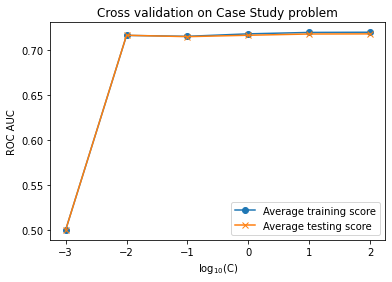

In [171]:
plt.plot(C_val_components, np.mean(cv_train_roc_auc, axis=0), '-o',
        label='Average training score')
plt.plot(C_val_components, np.mean(cv_test_roc_auc, axis=0), '-x',
        label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross validation on Case Study problem')

In [172]:
np.mean(cv_train_roc_auc, axis=0)

array([0.71997872, 0.71977193, 0.71819125, 0.71544094, 0.71646491,
       0.5       ])

In [173]:
np.mean(cv_test_roc_auc, axis=0)

array([0.7181628 , 0.71800662, 0.71662876, 0.71506529, 0.71661711,
       0.5       ])

<b>Up next, create interaction features for the case study data using scikit-learn's PolynomialFeatures. You should use 2 as the degree of polynomial features. Confirm that the number of new features makes sense.</b>

In [174]:
from sklearn.preprocessing import PolynomialFeatures

In [175]:
make_interactions = PolynomialFeatures(degree=2,interaction_only = True,include_bias=False)
X_interact = make_interactions.fit_transform(X)

<b>Finally, repeat the cross-validation procedure and observe the model performance now.</b>

In [176]:
# Using the new features, make a 80:20 train/test split using a random seed of 24.**
X_train,X_test,y_train,y_test = train_test_split(X_interact,df['default payment next month'].values,test_size=0.2,random_state=24)

In [177]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(21331, 153)
(5333, 153)
(21331,)
(5333,)


In [178]:
# Call the cross_val_C_search_pipe() function using the new training data.
# All other parameters should remain the same.
# Note that this training may take a few minutes due to the larger number of features.
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = \
cross_val_C_search_pipe(k_folds, C_vals, scale_lr_pipeline, X_train, y_train)

C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Done with C = 100.0


C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Done with C = 10.0


C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Done with C = 1.0
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001


Text(0.5, 1.0, 'Cross validation on Case Study problem')

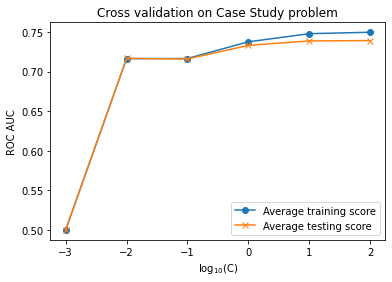

In [179]:
# Plot the average training and testing ROC AUC across folds, for each C value.
plt.plot(C_val_components, np.mean(cv_train_roc_auc, axis=0), '-o',
        label='Average training score')
plt.plot(C_val_components, np.mean(cv_test_roc_auc, axis=0), '-x',
        label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross validation on Case Study problem')

In [180]:
np.mean(cv_train_roc_auc, axis=0)

array([0.74972962, 0.7478995 , 0.73762779, 0.71652568, 0.71646491,
       0.5       ])

In [181]:
np.mean(cv_test_roc_auc, axis=0)

array([0.73920658, 0.73876379, 0.73309578, 0.71594255, 0.71661792,
       0.5       ])

<b>Take a look at the above graph. Does the average cross-validation testing performance improve with the interaction features? Is regularization useful?</b>

From the results, using polynomialFeatures or interaction we can say that the accuracy of the model has been increased or beeter compared to previous experiment on KFold CV

Clear the kernal and all output to run below code

# Cross-Validation Grid Search with Random Forest

 However, a common criticism of decision trees is that they overfit the training data. In order to remedy this issue, researchers have developed ensemble methods, such as random forests, that combine many decision trees to work together and make better predictions than any individual tree could

# Decision Trees

As you can see, decision trees have an intuitive structure and mimic the way that logical decisions might be made by humans. 

# The Terminology of Decision Trees and Connections to Machine Learning

<img src="https://cdn.filestackcontent.com/kZLGrn9NRX64Nj4R0r0j" width=600>

- Because there are two levels of decisions being made, based on cloud conditions at the first level, and temperature at the second level, we say that this decision tree has a depth of 2
- the quantities that are used to make decisions at the <b>nodes</b> (in other words, to split the nodes) are the features
- These binary decisions can be thought of as <b>"if, then"</b> rules. That is, if a certain criterion is met, do this, otherwise, do something else. 
- A tree that answers a binary yes/no type of question is a classification tree. However, decision trees are quite versatile and can also be used for multiclass classification and regression.
- The terminal nodes at the bottom of the tree are called leaves or leaf nodes.
-  In general, it should be clear that in a tree with n levels, where every node before the final level is split, there will be <b>2n leaf nodes.</b> 
-  This is important to bear in mind as the <b>maximum_depth</b> is one of the hyperparameters that you can set for a decision tree classifier in scikit-learn. 

# A Decision Tree in Scikit-Learn

In [1]:
import numpy as np #numerical computation
import pandas as pd #data wrangling
import matplotlib.pyplot as plt #plotting package
#Next line helps with rendering plots
%matplotlib inline
import matplotlib as mpl #add'l plotting functionality
mpl.rcParams['figure.dpi'] = 400 #high res figures
import graphviz #to visualize decision trees #pip install graphviz

In [2]:
df = pd.read_csv('cleaned_data.csv')

In [3]:
df.head(3)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,EDUCATION_CAT,graduate school,high school,others,university
0,798fc410-45c1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,1,university,0,0,0,1
1,8a8c8f3b-8eb4,120000,2,2,2,26,-1,2,0,0,...,1000,1000,0,2000,1,university,0,0,0,1
2,85698822-43f5,90000,2,2,2,34,0,0,0,0,...,1000,1000,1000,5000,0,university,0,0,0,1


In [4]:
#Get a list of column names of the DataFrame:
features_response = df.columns.tolist()

In [5]:
items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'EDUCATION_CAT', 'graduate school', 'high school', 'none',
                   'others', 'university']

In [6]:
features_response = [item for item in features_response if item not in items_to_remove]
features_response

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

In [7]:
from sklearn.model_selection import train_test_split
from sklearn import tree

In [8]:
X_train, X_test, y_train, y_test = \
train_test_split(df[features_response[:-1]].values, df['default payment next month'].values,
test_size=0.2, random_state=24)

Instantiate the decision tree class by specifying the max_depth parameter to be 2:

In [9]:
dt = tree.DecisionTreeClassifier(max_depth = 2)

In [10]:
dt.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=2)

In [11]:
dot_data = tree.export_graphviz(dt, out_file=None, filled=True, 
                                rounded = True, feature_names = features_response[:-1], 
                                proportion = True, class_names = ['Not defaulted', 'Defaulted'])

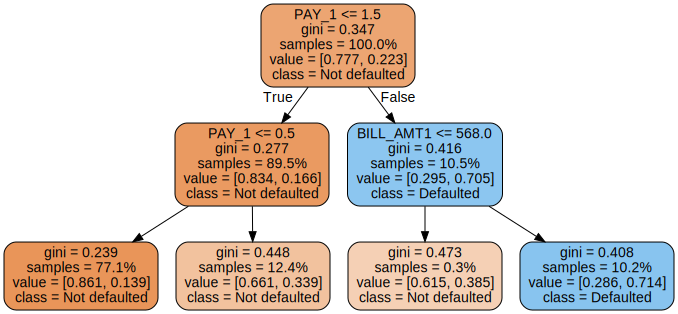

In [12]:
#dot_data #its a long string require graviz to display properly
# Warning : sometimes graphviz will not work, You have to go to search bar type graphviz and copy its full path, 
#then in system variables you have to edit environment variables path and paste the copied path of graphviz
graph = graphviz.Source(dot_data) 
graph

#pydot

Gini impurity = 1 - (probability of Yes ** 2 ) - (probability of No ** 2)

- All the samples where the value of the PAY_1 feature is less than or equal to the cut point of 1.5, will be represented as True
- In the top node, we are starting with all the samples ("samples = 100.0%"). Following the first split, 89.5% of the samples get sorted into the node on the left, while the remaining 10.5% go into the node on the right. 
- After the first split, the samples contained in each of the two nodes on the first level are split again. As further splits are made beyond the first split, smaller and smaller proportions of the training data will be assigned to any given node in the subsequent levels of a branch, as can be seen in the previous output.
- In each subsequent node, the class fraction of the samples that are contained in just that node are displayed.
- The lines starting with "value" give the class fractions of the response variable for the samples contained in each node. For example, in the top node, we see "value = [0.777, 0.223]". This is simply the class fraction for the overall training set.
- The class fractions are also how the nodes are colored: those with a higher proportion of the negative class than the positive class are orange, with darker orange signifying higher proportions, while those with a higher proportion of the positive class have a similar scheme using a blue color.
- Finally, the line starting with "class" indicates how the decision tree will make predictions from a given node, if that node were a leaf node.
- Decision trees for classification make predictions by determining which leaf node a sample will be sorted in to, given the values of the features, and then predicting the class of the majority of the training samples in that leaf node. This strategy means that the class proportions in each node are the necessary information that is needed to make a prediction.

In [50]:
features_response[:-1].index('PAY_1') #Lets identify its index

4

In [51]:
X_train.shape

(21331, 17)

In [53]:
#Use this code to confirm the proportion of samples after the first split of the decision tree:
sum(X_train[:,4] <= 1.5)/X_train.shape[0]
# We can see proportion we directly calculated here is showing in the left split

0.8946134733486475

- After the first split, the samples contained in each of the two nodes on the first level are split again. As further splits are made beyond the first split, smaller and smaller proportions of the training data will be assigned to any given node in the subsequent levels of a branch, as can be seen in the previous output.

In [12]:
#Calculate the class fraction in the training set with this code:
np.mean(y_train)
#his is equal to the second member of the pair of numbers following "value" in the top node;
#First number is just 1 - of this num 1-0.22310 = 0.777

0.223102526838873

###### Importance of max_depth

- Which is a hyperparameter, that is,the maximum depth to which the decision tree can be grown during the model training process.
- It turns out that this is one of the most important hyperparameters. Without placing a limit on the depth, the tree will be grown until one of the other limitations, specified by other hyperparameters, takes effect.
- This can lead to very deep trees, with very many nodes. For example, consider how many leaf nodes there could be in a tree with a depth of 20. This would be 220 leaf nodes, which is over 1 million! Do we even have 1 million training samples to sort into all these nodes? In this case, we do not.

#### Training Decision Trees: Node Impurity

##### But how are the splits decided during the training process?

- In practice, decision trees are actually trained using the inverse of purity, or node impurity. This is some measure of how far the node is from having 100% of the training samples -->> which is something like Cost function
- The most intuitive concept of node impurity is the misclassification rate

Let's visualize the misclassification rate as a way to start thinking about how decision trees are trained. 

In [13]:
pm0 = np.linspace(0.01,0.99,99)

In [14]:
pm0

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])

Then, the fraction of the positive class for this node is simply the rest of the samples:
<img src="https://cdn.filestackcontent.com/5nvrr9I4QiGk3qj7i422" width=200>

In [16]:
pm1 = 1 - pm0
misclassification_rate = np.minimum(pm0, pm1)
misclassification_rate

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.49, 0.48, 0.47, 0.46, 0.45,
       0.44, 0.43, 0.42, 0.41, 0.4 , 0.39, 0.38, 0.37, 0.36, 0.35, 0.34,
       0.33, 0.32, 0.31, 0.3 , 0.29, 0.28, 0.27, 0.26, 0.25, 0.24, 0.23,
       0.22, 0.21, 0.2 , 0.19, 0.18, 0.17, 0.16, 0.15, 0.14, 0.13, 0.12,
       0.11, 0.1 , 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01])

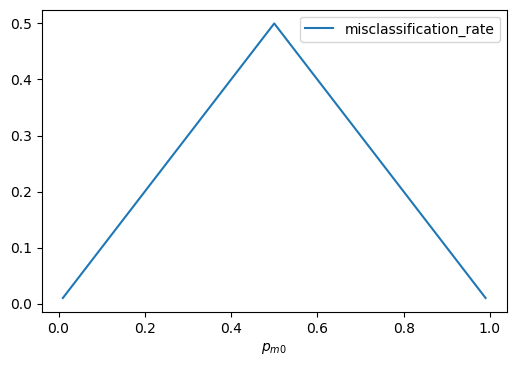

In [18]:
#What does the misclassification rate look like plotted against the possible class fractions of the negative class?
mpl.rcParams['figure.dpi'] = 100
plt.plot(pm0,misclassification_rate, label="misclassification_rate")
plt.xlabel('$p_{m0}$')
plt.legend()

- Now, it's clear that the closer the class fraction of the negative class, pm0, is to 0 or 1, the lower the misclassification rate will be. 
- Continuing for the moment with the idea of minimizing the misclassification rate, the decision tree training algorithm goes about node splitting by considering all the features. 
- Although, the algorithm may possibly only consider a randomly-selected subset if you set the max_features hyperparameter to anything less than the total number of features. 
- the algorithm then considers each possible threshold for every candidate feature and chooses the one that results in the lowest impurity
- calculated as the average impurity across the two possible new nodes, weighted by the number of samples in each node.
- The node splitting process is shown below. This process is repeated until a stopping criterion of the tree, such as max_depth, is reached:

<img src="https://cdn.filestackcontent.com/ejJUN8JcQQmsAzfZGzfa" width=400>

How to select a feature and threshold in order to split a node :

- While the misclassification rate is an intuitive measure of impurity, it happens that there are better measures that can be used to find splits during the model training process. 
    - The two options that are available in scikit-learn for the impurity calculation
        - the criterion keyword argument, are the Gini impurity and the cross-entropy options.
- The Gini impurity is calculated for a node m using the following formula:
    - <img src="https://cdn.filestackcontent.com/mfrpXfrLRq6MDB5c1yDB" width=250>

In [23]:
# Equation to calculate gini impurity
gini = (pm0*(1-pm0)) + (pm1*(1-pm1))
gini

array([0.0198, 0.0392, 0.0582, 0.0768, 0.095 , 0.1128, 0.1302, 0.1472,
       0.1638, 0.18  , 0.1958, 0.2112, 0.2262, 0.2408, 0.255 , 0.2688,
       0.2822, 0.2952, 0.3078, 0.32  , 0.3318, 0.3432, 0.3542, 0.3648,
       0.375 , 0.3848, 0.3942, 0.4032, 0.4118, 0.42  , 0.4278, 0.4352,
       0.4422, 0.4488, 0.455 , 0.4608, 0.4662, 0.4712, 0.4758, 0.48  ,
       0.4838, 0.4872, 0.4902, 0.4928, 0.495 , 0.4968, 0.4982, 0.4992,
       0.4998, 0.5   , 0.4998, 0.4992, 0.4982, 0.4968, 0.495 , 0.4928,
       0.4902, 0.4872, 0.4838, 0.48  , 0.4758, 0.4712, 0.4662, 0.4608,
       0.455 , 0.4488, 0.4422, 0.4352, 0.4278, 0.42  , 0.4118, 0.4032,
       0.3942, 0.3848, 0.375 , 0.3648, 0.3542, 0.3432, 0.3318, 0.32  ,
       0.3078, 0.2952, 0.2822, 0.2688, 0.255 , 0.2408, 0.2262, 0.2112,
       0.1958, 0.18  , 0.1638, 0.1472, 0.1302, 0.1128, 0.095 , 0.0768,
       0.0582, 0.0392, 0.0198])

#Cross entropy is calculated using this formula:
 <img src="https://cdn.filestackcontent.com/VlagIZLmQpaYRbV7cqTu" width=300>

In [25]:
#Cross entropy
cross_ent  = -1*((pm0*np.log(pm0)) + (pm1*np.log(pm1)))
cross_ent

array([0.05600153, 0.09803911, 0.13474217, 0.16794415, 0.19851524,
       0.22696752, 0.25363895, 0.27876937, 0.30253782, 0.32508297,
       0.34651534, 0.36692499, 0.38638671, 0.40496349, 0.42270909,
       0.43966988, 0.45588621, 0.47139349, 0.48622296, 0.50040242,
       0.51395667, 0.52690796, 0.53927634, 0.55107993, 0.56233514,
       0.57305692, 0.58325884, 0.59295332, 0.60215168, 0.6108643 ,
       0.61910066, 0.62686946, 0.63417864, 0.64103548, 0.64744664,
       0.65341819, 0.65895568, 0.66406413, 0.66874809, 0.67301167,
       0.67685855, 0.680292  , 0.68331491, 0.6859298 , 0.68813881,
       0.68994376, 0.6913461 , 0.69234697, 0.69294717, 0.69314718,
       0.69294717, 0.69234697, 0.6913461 , 0.68994376, 0.68813881,
       0.6859298 , 0.68331491, 0.680292  , 0.67685855, 0.67301167,
       0.66874809, 0.66406413, 0.65895568, 0.65341819, 0.64744664,
       0.64103548, 0.63417864, 0.62686946, 0.61910066, 0.6108643 ,
       0.60215168, 0.59295332, 0.58325884, 0.57305692, 0.56233

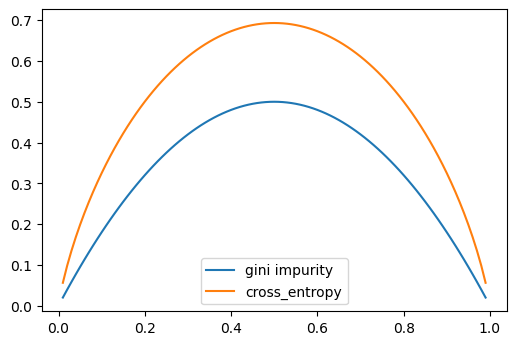

In [29]:
plt.plot(pm0, gini, label="gini impurity")
plt.plot(pm0, cross_ent, label="cross_entropy")
plt.legend()

- Like the misclassification rate, both the Gini impurity and the cross entropy are highest when the class fractions are equal at 0.5, and they decrease as the node becomes purer
-  when they contain a higher proportion of just one of the classes. However, the Gini impurity is somewhat steeper than the misclassification rate in certain regions of the class fraction, which enables it to more effectively find the best split. Cross-entropy looks even steeper. 
-  So, which one is better for your work? This is the kind of question that does not have a concrete answer across all datasets. You should consider both impurity metrics in a cross-validation search for hyperparameters in order to determine the appropriate one.
- Note that in scikit-learn, Gini impurity can be specified with the criterion argument using the 'gini' string, while cross entropy is just referred to as 'entropy'.

## Features Used for the First Splits: Connections to Univariate Feature Selection and Interactions

- Notice that PAY_1 was the feature chosen for the first split. This means that it was the best feature in terms of decreasing node impurity on the node containing all of the training samples.

# Training Decision Trees: A Greedy Algorithm

- There is no guarantee that a decision tree trained by the process described previously will be the best possible decision tree for finding leaf nodes with the lowest impurity.
- This is because the algorithm used to train decision trees is what is called a greedy algorithm.
- In this context, this means that, at each opportunity to split a node, the algorithm is looking for the best possible split at that point in time, without any regard to the fact that the opportunities for later splits are being affected.
- But what if we instead split on BILL_AMT_1, and then make subsequent splits on PAY_1 in the next level. <br>  Will this mean that the impurity of the leaf nodes will be lower? Even though the initial split on BILL_AMT_1 is not the best one available at first, the end result will be better if it is done this way. <br> The algorithm has no way of finding solutions like this, since it only considers the best possible split at each node. Just to be clear, 
- Instead of searching for the best split at each node, the splitter keyword argument to the decision tree class can be specified as random in order to choose a random feature to make a split on. However, the default is best, which searches all features for the best split. Another option, which we've already discussed, is to limit the number of features using the max_feature keyword, which will be searched at each splitting opportunity.

# Training Decision Trees: Different Stopping Criteria

from IPython.display import HTML, display
display(HTML("<table><tr>
             <td>
             <img src="https://cdn.filestackcontent.com/L9uXYcl2QoG01LPo3di6" width=800>
             </td>
             <td>
             <img src="https://cdn.filestackcontent.com/FG2FdaRQTBaZAdKZ8g9k" width=400>
             </td>
             <td>
             <img src="https://cdn.filestackcontent.com/MqDjPHCmR22dLIycdYvw" width=400>
             </td>
             <td>
             <img src="https://cdn.filestackcontent.com/R7oUHwaQ96On6Il6bnV3" width=400>
             </td>
             </tr></table>"))

# Using Decision Trees: Advantages and Predicted Probabilities


#### No Need to Scale Features

- Consider the reasons why we needed to scale features for logistic regression. One reason is that, for some of the solution algorithms based on gradient descent, it is necessary that features be on the same scale.
- Another is that when we are using L1 or L2 regularization to penalize coefficients, all the features must be on the same scale so they are penalized equally. 
- <b>With decision trees, the node splitting algorithm considers each feature individually and, therefore, it doesn't matter whether the features are on the same scale or not. </b>

##### Non-linear Relationships and Interactions

- decision trees can describe complex non-linear relationships of a single feature, as well as interactions between features.
- An example classification dataset, with the classes shown in red and blue :-

<img src="https://cdn.filestackcontent.com/s0uPayuqSsmOCuFIcmJk" width=200>


- lets try by applyig both decision tree and logistic regression :-

<img src="https://cdn.filestackcontent.com/kjaSRd1nQ6CFNRGYgxb4" width=400>

- In the figure above, the predicted probabilities for both models are colored so that darker red corresponds to a higher predicted probability for the red class, while darker blue corresponds to a higher predicted probability for the blue class.
- We can see that the decision tree can isolate the blue class in the middle of the circle of red points. This is because, by using thresholds for the x and y coordinates in the node-splitting process, a decision tree can mathematically model the fact that the location of the blue and red classes depend on both the x and y coordinates together (interactions), and that the likelihood of either class is not a linearly increasing or decreasing function of x or y (non-linearities). 

#### Predicted Probabilities

-  The probability is based on the proportion of the majority class in the leaf node. If the leaf node consisted 75% of the positive class, for example, the prediction for that node will be the positive class and the predicted probability will be 0.75. 
- The <b>predicted probabilities</b> from decision trees are not considered to be as <b>statistically rigorous</b> as those from generalized linear models, but they are still commonly used to measure the performance of models by methods that depend on varying the threshold for classification, such as the ROC curve or the precision-recall curve.

<blockquote>We are focusing here on decision trees for classification because of the nature of the case study. However, <b>decision trees can also be used for regression</b>,making them a versatile method. The tree-growing process is similar for regression as it is for classification, <b>except that instead of seeking to reduce node impurity, a regression tree seeks to minimize other metrics such as the mean squared error (MSE) or mean absolute error (MAE) of the predictions</b>, where the prediction for a node may be the average or median of the samples in the node, respectively</blockquote>

# A More Convenient Approach to Cross-Validation

- Instead of writing a function like i did in previous steps "kfold", scikit-learn offers a proper method for crossvalidation 
  which can handle hyperparameters very well - GridSearchCV
- GridSearchCV does what is called an exhaustive grid search over all the possible combinations of parameters that we supply. This means that if we supplied five different values for each of the two hyperparameters, the cross-validation procedure would be run 5 x 5 = 25 times.
-  If you are searching many values of many hyperparameters, the amount of cross-validation runs can grow very quickly. In these cases, you may wish to use RandomizedSearchCV, which searches a randomly selected number of hyperparameter combinations from the universe of all possibilities in the grid you supply.
- GridSearchCV can speed up your work by streamlining the cross-validation process. 

display(HTML("<table><tr>
             <td>
             <img src="https://cdn.filestackcontent.com/OTEKIvHyTS6wdFXIO4Yv" width=600>
             </td>
             <td>
             <img src="https://cdn.filestackcontent.com/UrbhjGyUR7eMmX5EQSwX" width=400>
             </td>
             <td>
             <img src="https://cdn.filestackcontent.com/oeT08e9jRoqZF5UD8WKL" width=400>
             </td>
             </tr></table>"))

# Finding Optimal Hyperparameters for a Decision Tree

- In this activity, i am going to use GridSearchCV to tune the hyperparameters for a decision tree model. 

In [15]:
from sklearn.model_selection import GridSearchCV

- The next step is to define the hyperparameters that we want to search using cross-validation. 
- will find the best maximum depth of tree, using the max_depth parameter. 
- Deeper trees have more node splits, which partition the training set into smaller and smaller subspaces using the features. While we don't know the best maximum depth ahead of time, it is helpful to consider some limiting cases when considering the range of parameters to use for the grid search.

In [16]:
X_train.shape

(21331, 17)

With 21,331 training samples and 4-fold cross-validation, there will be three-fourth of the samples, or about 16,000 samples, in each training fold.

# What does this mean for how deep we may wish to grow our tree?

- A theoretical limitation is that we need at least one sample in each leaf.
- we know a tree that splits at every node before the last level, with n levels, has 2n leaf nodes. Therefore, a tree with L leaf nodes has a depth of approximately log2(L). In the limiting case, if we grow the tree deep enough so that every leaf node has one training sample for a given fold, the depth will be log2(16,000) ≈ 14. So, 14 is the theoretical limit to the depth of a tree that we could grow in this case.
- Practically speaking, you will probably not want to grow a tree this deep, as the rules used to generate the decision tree will be very specific to the training data and the model is likely to be overfit. However, this gives you an idea of the range of values we may wish to consider for the max_depth hyperparameter. We will explore a range of depths from 1 up to 12.

In [17]:
#Define a dictionary with the key being the hyperparameter name and the value being the list of values of this hyperparameter that we want to search in cross-validation:
params = {'max_depth':[1,2,4,6,8,10,12]}

In [18]:
cv = GridSearchCV(dt, param_grid=params, scoring='roc_auc',
                 n_jobs=None, iid=False, refit=True, cv=4, verbose=1,
                 pre_dispatch=None, error_score=np.nan, return_train_score=True)
#we used the default arguments for all options but max_depth.
#The other notable options here are that we use the ROC AUC metric (scoring='roc_auc'), that we do a 4-fold cross-validation (cv=4), 
#and that we calculate training scores (return_train_score=True) to assess the bias-variance trade-off.

In [19]:
#Perform a 4-fold cross-validation to search for the optimal maximum depth using this code:
cv.fit(X_train, y_train)

Fitting 4 folds for each of 7 candidates, totalling 28 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    7.3s finished
C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(max_depth=2), iid=False,
             param_grid={'max_depth': [1, 2, 4, 6, 8, 10, 12]},
             pre_dispatch=None, return_train_score=True, scoring='roc_auc',
             verbose=1)

We had 4 folds and 7 hyperparameters, meaning 4 x 7 = 28 fits are performed. <br>
You can control how much output you get from this procedure with the verbose keyword argument; larger numbers mean more output.

- Now it's time to examine the results of the cross-validation procedure. 
- .cv_results_. This is a dictionary containing the names of results as keys and the results themselves as values. For example, <br> the mean_test_score key holds the average testing score across the folds for each of the seven hyperparameters. 

In [21]:
cv_results_df = pd.DataFrame(cv.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.051607,0.008330,0.145991,0.243616,1,{'max_depth': 1},0.639514,0.643398,0.651891,0.650753,0.646389,0.005136,7,0.648680,0.647384,0.644553,0.644934,0.646388,0.001712
1,0.096282,0.003782,0.002767,0.003000,2,{'max_depth': 2},0.695134,0.699022,0.713376,0.699510,0.701761,0.006917,5,0.704034,0.702700,0.698113,0.702535,0.701845,0.002232
2,0.152070,0.003630,0.011752,0.006785,4,{'max_depth': 4},0.732720,0.741078,0.746946,0.743731,0.741119,0.005276,2,0.756882,0.752421,0.749368,0.753055,0.752932,0.002673
3,0.218341,0.004186,0.010014,0.006426,6,{'max_depth': 6},0.744848,0.745757,0.752960,0.740677,0.746061,0.004420,1,0.782202,0.780125,0.775228,0.774750,0.778076,0.003178
4,0.299106,0.008161,0.000000,0.000000,8,{'max_depth': 8},0.728200,0.731886,0.749445,0.730359,0.734973,0.008458,3,0.811837,0.808353,0.803415,0.802326,0.806483,0.003836
5,0.345491,0.003247,0.011732,0.006774,10,{'max_depth': 10},0.710028,0.704876,0.715129,0.715340,0.711343,0.004297,4,0.848864,0.854183,0.841149,0.836056,0.845063,0.006966
6,0.405698,0.005619,0.005977,0.006746,12,{'max_depth': 12},0.675681,0.659012,0.677470,0.682915,0.673769,0.008927,6,0.887840,0.903307,0.885688,0.876154,0.888247,0.009744


You can see a lot of output for each row, such as the mean and standard deviation of the time in seconds that each of the four folds took for both training (fitting) and testing (scoring). 

In [22]:
cv_results_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

- Generally speaking, the "best" combination of hyperparameters is that with the highest average testing score. This is an estimation of how well the model, fit using these hyperparameters, could perform when scored on new data.
- Let's make a plot showing how the average testing score varies with the max_depth hyperparameter. We will also show the average training scores on the same plot, to see how bias and variance change as we allow deeper and more complex trees to be grown during model fitting.
- We include the standard deviations of the 4-fold training and testing scores as error bars, using the Matplotlib errorbar function. This gives you an indication of how variable the scores are across the folds. : >>

Text(0, 0.5, 'ROC AUC')

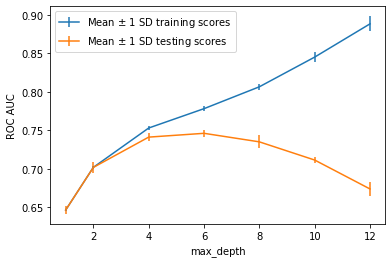

In [25]:
ax =plt.axes()
ax.errorbar(cv_results_df['param_max_depth'],
            cv_results_df['mean_train_score'],
            yerr = cv_results_df['std_train_score'],
            label = 'Mean $\pm$ 1 SD training scores')
ax.errorbar(cv_results_df['param_max_depth'],
            cv_results_df['mean_test_score'],
            yerr = cv_results_df['std_test_score'],
            label = 'Mean $\pm$ 1 SD testing scores')
ax.legend()
plt.xlabel('max_depth')
plt.ylabel('ROC AUC')

- The error bars indicate how variable the scores are across folds. If there was a large amount of variation across the folds, it would indicate that the nature of the data across the folds was different in a way that affected the ability of our model to describe it. 
- This could be concerning because it would indicate that we may not have enough data to train a model that would reliably perform on new data. 
- However, in our case here, there is not much variability between the folds, so this is not an issue.
- What about the general trends of the training and testing scores across the different values of max_depth? We can see that as we grow deeper and deeper trees, the model fits the training data better and better. As noted previously, if we grew trees deep enough so that each leaf node had just one training sample, we create a model that is very specific to the training data. In fact, it would fit the training data perfectly. We could say that such a model had extremely high variance.
- But this performance on the training set does not necessarily translate over to the testing set. In the previous output, it's apparent that increasing max_depth only increases testing scores up to a point, after which deeper trees in fact have lower testing performance. This is another example of how we can leverage the bias-variance trade-off to create a better predictive model
- But this is fine because if we accept some bias, we will have better performance on the testing data, which is ultimately the metric we use to select model hyperparameters.
- In this case, i would select max_depth = 6. 

### Comparison Between Models

- At this point, we've calculated a 4-fold cross-validation of several different machine learning models on the case study data. So, how are we doing? What's our best so far? In the last lesson, we got an average testing ROC AUC of 0.718 with logistic regression and 0.740 by engineering interaction features in a logistic regression. Here, with a decision tree, we can achieve 0.745. So, we are making gains in model performance. We will explore one more type of model to see if we can push performance even higher.

# Random Forests: Ensemble of Decision Trees

- As we saw in the previous activity, decision trees are prone to overfitting. This is one of the principle criticisms of their usage, despite the fact that they are highly interpretable. 
- We were able to limit this overfitting, to an extent, however, by limiting the maximum depth to which the tree could be grown.
- Random forests are examples of what are called ensemble models, because they are formed by combining other models.
- Once you understand decision trees, the concept behind random forests is actually quite simple. That is because random forests are just ensembles of many decision trees; 
- So, how many decision tree models will be included in a random forest? This is one of the hyperparameters, n_estimators, that needs to be specified when building a random forest model. 
- Generally speaking, the more trees, the better. As the number of trees increases, the variance of the overall ensemble will decrease. 
- This should result in the random forest model having better generalization to new data, which will be reflected in increased testing scores. However, there will be a point of diminishing returns after which increasing the number of trees does not result in a substantial improvement in model performance

- There are two principle ways in which the trees are different, one of which we are already familiar with:
    - The number of features considered at each split
    - The samples used to grow different trees

# The Number of Features Considered at each Split

- We are already familiar with this option from the DecisionTreeClassifier class: max_features. In our previous usage of this class, we left max_features at its default value of None
- which meant that all features were considered at each split. By using all the features to fit the training data, overfitting is possible. 
- By limiting the number of features considered at each split, some of the decision trees in a random forest will potentially find better splits.
- This is because, although they are still greedily searching for the best split, they are doing it with a limited selection of features. This may make certain splits possible later in the tree that may not have been found if all features were being searched at each split.
- There is a max_features option in the RandomForestClassifier class in scikit-learn just as there is for the DecisionTreeClassifier class and the options are similar. 
- However, for the random forest, the default setting is 'auto', which means the algorithm will only search a random selection of the square root of the number of possible features at each split, for example a random selection of \sqrt{9}=3
- a total of 9 possible features. Because each tree in the forest will likely choose different random selections of features to split as the trees are being grown, the trees in the forest will not be the same.

# The Samples Used to Grow Different Trees

- The other way that the trees in a random forest differ from each other is that they are usually grown with different training samples. To do this, a statistical procedure known as <b>bootstrapping</b> is used,
- which means to generate new synthetic datasets from the original data. The synthetic datasets are created by randomly selecting samples from the original dataset using replacement.
- Here, "replacement" means that if we select a certain sample, we will continue to consider it for selection, that is, it is "replaced" to the original dataset after we've sampled it. 
- The number of samples in the synthetic datasets are the same as those in the original dataset, but some samples may be repeated because of replacement.
- <b>The procedure of using random sampling to create synthetic datasets, and training models on them separately, is called bagging, which is short for bootstrapped aggregation</b>
- Bagging can, in fact, be used with any machine learning model, not just decision trees, and scikit-learn offers functionality to do this for both classification (BaggingClassifier) and regression (BaggingRegressor) problems.
-  In the case of random forest, bagging is turned on by default and the bootstrap option is set to True. But if you want all the trees in the forest to be grown using all of the training data, you can set this option to False.

- In addition to n_estimators and bootstrap, which we discussed previously, there are only two additional new options beyond what's available for decision trees:
- <b>oob_score</b>, a bool: This option controls whether or not to calculate an out of bag (OOB) score for each tree. This can be thought of as a testing score, where the samples that were not selected by the bagging procedure to grow a given tree are used to assess model performance of that tree. Here, use True to calculate the OOB score or False (the default) not to.
- <b>warm_start</b>, a bool: This is False by default – if you set this to True, then reusing the same random forest model object will cause additional trees to be added to the already-generated forest.

# Other Kinds of Ensemble Models

- Random forest, as we now know, is an example of a bagging ensemble. Another kind of ensemble is a <b>boosting ensemble.</b> The general idea of boosting is to use successive new models of the same type and to train them on the errors of previous models. This way, successive models learn where earlier models didn't do well and correct these errors. Boosting has enjoyed successful application with decision trees and is available in scikit-learn and another popular Python package called XGBoost
- Stacking ensembles are a somewhat more advanced kind of ensemble, where the different models (estimators) within the ensemble do not need to be of the same type as they do in bagging and boosting. For example, you could build a stacking ensemble with a random forest and a logistic regression. The predictions of the different members of the ensemble are combined for a final prediction using yet another model (the stacker), which considers the predictions of the stacked models as features.

# Random Forests: Predictions and Interpretability

- Since a random forest is just a collection of decision trees, somehow the predictions of all those trees must be combined to create the prediction of the random forest.
- After model training, classification trees will take an input sample and a produce a predicted class, for example, whether or not a credit account in our case study problem will default. 
- One intuitive approach to combining the predictions of these trees into the ultimate prediction of the forest is to take a majority vote. That is, whatever the most common prediction of all the trees is becomes the prediction of the forest.
- However, scikit-learn uses a somewhat different approach: adding up the predicted probabilities for each class and then choosing the one with the highest probability. This captures more information from each tree than just the predicted class.

# Interpretability of Random Forests

- One of the main advantages of decision trees is that it is straightforward to see how any individual prediction is made. You can trace the decision path for any predicted sample through the series of "if then" rules used to make a prediction and know exactly how it came to have that prediction
- By contrast, imagine that you have a random forest consisting of 1,000 trees. This would mean there are 1,000 sets of rules like this, which are much harder to communicate to human beings than 1 set of rules!
-  However, a simple way to interpret the way a random forest works, that is available in scikit-learn, is to observe the feature importance. The feature importance of a random forest are a measure of how useful each of the features were when growing the trees in the forest. This usefulness is measured by using a combination of the fraction of training samples that were split using that feature, and the decrease in node impurity that resulted.
- Because of the feature importance calculation, which can be used to rank features by how useful they are to the random forest model, random forests can also be used for feature selection

# Fitting a Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
rf = RandomForestClassifier(
    n_estimators=10, criterion='gini', max_depth=3,
    min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
    max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
    min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None,
    random_state=4, verbose=0, warm_start=False, class_weight=None)

- For this activity, we'll use mainly the default options. However, note that we will set max_depth = 3. Here, we are only going to explore the effect of using different numbers of trees, which we will illustrate with relatively shallow trees for the sake of shorter runtimes. To find the best model performance, we'd typically try more and deeper depths of trees.
- We also set random_state for predictable results across runs

In [28]:
#Create a parameter grid for this activity in order to search the numbers of trees ranging from 10 to 100:
rf_params_ex = {'n_estimators':list(range(10,110,10))}
# For the hyperparameter, n_estimators = 100, we have grown a total of 400 trees across all the cross-validation splits.

We use Python's range() function to create an iterator for the integer values we want, and then convert it to a list using list().

- Instantiate a grid search cross-validation object for the random forest model using the parameter grid from the previous step.
- Otherwise, you can use the same options that were used for the cross-validation of the decision tree:

In [29]:
cv_rf_ex = GridSearchCV(rf, param_grid=rf_params_ex, scoring='roc_auc',
                        n_jobs=None, iid=False, refit=True, cv=4, verbose=1,
                        pre_dispatch=None, error_score=np.nan, return_train_score=True)

In [30]:
cv_rf_ex.fit(X_train, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   59.8s finished
C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_depth=3, n_estimators=10,
                                              random_state=4),
             iid=False,
             param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100]},
             pre_dispatch=None, return_train_score=True, scoring='roc_auc',
             verbose=1)

- You probably noticed that, although we are only cross-validating over 10 hyperparameter values, comparable to the 7 values that we examined for the decision tree in the previous activity, this cross-validation took noticeably longer. Consider how many trees we are growing in this case. For the last hyperparameter, n_estimators = 100, we have grown a total of 400 trees across all the cross-validation splits.

In [32]:
cv_rf_ex_results_df = pd.DataFrame(cv_rf_ex.cv_results_)
cv_rf_ex_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.287250,0.011250,0.016396,0.001508,10,{'n_estimators': 10},0.739183,0.746599,0.772127,0.771322,0.757308,0.014656,10,0.767973,0.767158,0.760550,0.763683,0.764841,0.002955
1,0.576620,0.046269,0.027557,0.005109,20,{'n_estimators': 20},0.745612,0.753712,0.777616,0.771737,0.762169,0.012998,9,0.772819,0.771499,0.765944,0.765395,0.768914,0.003284
2,0.754780,0.085100,0.033444,0.011755,30,{'n_estimators': 30},0.747259,0.754154,0.777954,0.771825,0.762798,0.012524,7,0.774655,0.772100,0.765026,0.766697,0.769620,0.003910
3,0.954341,0.043489,0.040771,0.009225,40,{'n_estimators': 40},0.746682,0.754553,0.777709,0.773134,0.763020,0.012813,4,0.774300,0.772642,0.765051,0.765876,0.769467,0.004057
4,1.172972,0.089347,0.046844,0.002189,50,{'n_estimators': 50},0.748009,0.755878,0.779465,0.771250,0.763651,0.012379,1,0.775241,0.774025,0.765732,0.766947,0.770486,0.004191
5,1.359597,0.023157,0.049444,0.001935,60,{'n_estimators': 60},0.748437,0.755604,0.779478,0.770978,0.763624,0.012252,2,0.775419,0.773615,0.766133,0.767032,0.770550,0.004031
6,1.557494,0.012648,0.062460,0.002480,70,{'n_estimators': 70},0.747491,0.754465,0.779104,0.771023,0.763021,0.012620,3,0.774420,0.773379,0.765960,0.766174,0.769983,0.003934
7,2.136592,0.182883,0.091653,0.024356,80,{'n_estimators': 80},0.747424,0.754488,0.778753,0.770872,0.762884,0.012502,5,0.774234,0.773257,0.765978,0.766220,0.769922,0.003840
8,2.136194,0.089871,0.080440,0.009300,90,{'n_estimators': 90},0.747097,0.753794,0.778507,0.770426,0.762456,0.012571,8,0.774095,0.772973,0.766022,0.765748,0.769709,0.003846
9,2.213850,0.011654,0.079675,0.003082,100,{'n_estimators': 100},0.747221,0.753924,0.779195,0.770937,0.762819,0.012811,6,0.774340,0.773598,0.766103,0.766914,0.770238,0.003750


- You can examine the whole DataFrame in the accompanying Jupyter notebook. Here, we move directly to creating plots of the quantities of interest. We'll make a line plot, with symbols, of the mean fit time across the folds for each hyperparameter, contained in the column mean_fit_time, as well as an error bar plot of testing scores, which we've already done for decision trees. Both plots will be against max_depth on the x axis.

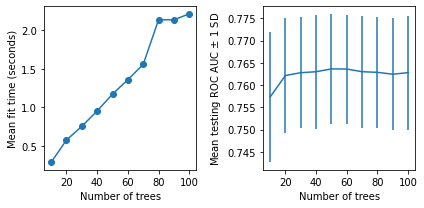

In [37]:
#Create two subplots, of the mean time and mean testing scores with standard deviation:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
axs[0].plot(cv_rf_ex_results_df['param_n_estimators'],
            cv_rf_ex_results_df['mean_fit_time'],
            '-o')
axs[0].set_xlabel('Number of trees')
axs[0].set_ylabel('Mean fit time (seconds)')
axs[1].errorbar(cv_rf_ex_results_df['param_n_estimators'],
                cv_rf_ex_results_df['mean_test_score'],
                yerr=cv_rf_ex_results_df['std_test_score'])
axs[1].set_xlabel('Number of trees')
axs[1].set_ylabel('Mean testing ROC AUC $\pm$ 1 SD ')
plt.tight_layout()

There are several things to note about these visualizations. First of all, we can see that by using a random forest, we have increased model performance on the cross-validation testing folds above that of any of our previous efforts. While we haven't made an attempt to tune the random forest hyperparameters to achieve the best model performance we can, this is a promising result and indicates that a random forest will be a valuable addition to our modeling efforts.

- However, along with these higher model testing scores, notice that there is also more variability between the folds than what we saw with the decision tree; this variability is visible as larger standard deviations in model testing scores across the folds.
- While this indicates that there is a wider range in model performance that might be expected from using this model, 
-  you are encouraged to examine the model testing scores of the folds directly in the pandas DataFrame in the Jupyter notebook. You should see that even the lowest score from an individual fold is still higher than the average testing score from the decision tree, indicating that it will be better to use a random forest.
- But is this additional computational time worth it in terms of increased model performance? The subplot on the right of the output shows that beyond about 20 trees, it's not clear that adding more trees reliably improves testing performance. While the model with 50 trees has the highest score, the fact that adding more trees actually decreases the testing score somewhat indicates that the gain in ROC AUC for 50 trees may just be due to randomness, as adding more trees theoretically should increase model performance. Based on this reasoning, if we were limited to max_depth= 3, we may choose a forest of 20 or perhaps 50 trees and proceed. 
- the training scores are higher than the testing scores, indicating that some amount of overfitting is happening. While this may be the case, it's still true that the testing scores for this random forest model are higher than those that we've observed for any other model.

In [39]:
# to see the best hyperparameters from cross-validation:
cv_rf_ex.best_params_

{'n_estimators': 50}

In [40]:
#to create a DataFrame of the feature names and importance, and then show it sorted by importance:
feat_imp_df = pd.DataFrame({
    'Feature name':features_response[:-1],
    'Importance':cv_rf_ex.best_estimator_.feature_importances_
})
feat_imp_df.sort_values('Importance', ascending=False)

,Feature name,Importance
4,PAY_1,0.609609
11,PAY_AMT1,0.094123
0,LIMIT_BAL,0.079265
13,PAY_AMT3,0.047067
12,PAY_AMT2,0.035393
6,BILL_AMT2,0.022422
14,PAY_AMT4,0.021164
15,PAY_AMT5,0.015962
10,BILL_AMT6,0.014293
8,BILL_AMT4,0.013454


- Notice that the top 5 most important features from the random forest, are the same as the top 5 chosen by an ANOVA F-test <br>
although they are in a somewhat different order. This is good confirmation between the different methods.

# Checkerboard Graph

- illustrate a visualization technique in Matplotlib. Plotting a two-dimensional grid with colored squares or other shapes on it, can be useful when you want to show three dimensions of data. Here, color illustrates the third dimension. For example, you may want to visualize model testing scores over a grid of two hyperparameters. This is, in fact, the use case in Cross-Validation Grid Search with Random Forest.

In [42]:
xx_example, yy_example = np.meshgrid(range(5), range(5))
print(xx_example)
print(yy_example)

[[0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]]
[[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]]


In [43]:
z_example = np.arange(1,17).reshape(4,4)
z_example

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12],
       [13, 14, 15, 16]])

Text(0, 0.5, 'Y coordinate')

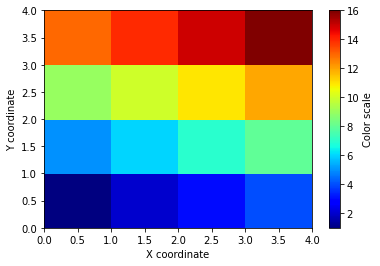

In [44]:
ax = plt.axes()
pcolor_ex = ax.pcolormesh(xx_example, yy_example, z_example, cmap=plt.cm.jet)
plt.colorbar(pcolor_ex, label='Color scale')
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')

# Summary

Although a single decision tree is prone to overfitting, the random forest ensemble method has been shown to reduce this high-variance issue. Random forests are built by training many trees. The decreased variance of the ensemble of trees is achieved by increasing the bias of the individual trees in the forest, by only training them on a portion of the available training set (bootstrapped aggregation or bagging) and only considering a reduced number of features at each node split.

# Task - 6

Restart kernal and Clear ouputs to run the code

In [1]:
%autosave 10

Autosaving every 10 seconds


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
df = pd.read_csv('cleaned_data.csv')

<b>Run the following 3 cells to create a list of features, create a train/test split, and instantiate a random forest classifier. </b>

In [4]:
features_response = df.columns.tolist()
items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'EDUCATION_CAT', 'graduate school', 'high school', 'none',
                   'others', 'university']
features_response = [item for item in features_response if item not in items_to_remove]
features_response

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df[features_response[:-1]].values,
    df['default payment next month'].values,
    test_size=0.2, random_state=24
)

In [7]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=10, criterion='gini', max_depth=3,
    min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
    max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
    min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None,
    random_state=4, verbose=0, warm_start=False, class_weight=None
)

<b>Create a dictionary representing the grid for the max_depth and n_estimators hyperparameters that will be searched. Include depths of 3, 6, 9, and 12, and 10, 50, 100, and 200 trees.</b>

In [9]:
rf_params_ex = {'n_estimators':[10,50,100,200],
               'max_depth':[3,6,9,12]}

<b>Instantiate a GridSearchCV object using the same options that we have previously in this course, but with the dictionary of hyperparameters created above. Set verbose=2 to see the output for each fit performed</b>

In [14]:
from sklearn.model_selection import GridSearchCV

In [15]:
cv_rf_ex = GridSearchCV(rf, param_grid=rf_params_ex, scoring='roc_auc',
                        n_jobs=None, iid=False, refit=True, cv=4, verbose=2,
                        pre_dispatch=None, error_score=np.nan, return_train_score=True)

<b>Fit the GridSearchCV object on the training data.</b>

In [16]:
cv_rf_ex.fit(X_train, y_train)

Fitting 4 folds for each of 16 candidates, totalling 64 fits
[CV] max_depth=3, n_estimators=10 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... max_depth=3, n_estimators=10, total=   0.2s
[CV] max_depth=3, n_estimators=10 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ..................... max_depth=3, n_estimators=10, total=   0.3s
[CV] max_depth=3, n_estimators=10 ....................................
[CV] ..................... max_depth=3, n_estimators=10, total=   0.2s
[CV] max_depth=3, n_estimators=10 ....................................
[CV] ..................... max_depth=3, n_estimators=10, total=   0.2s
[CV] max_depth=3, n_estimators=50 ....................................
[CV] ..................... max_depth=3, n_estimators=50, total=   0.8s
[CV] max_depth=3, n_estimators=50 ....................................
[CV] ..................... max_depth=3, n_estimators=50, total=   0.8s
[CV] max_depth=3, n_estimators=50 ....................................
[CV] ..................... max_depth=3, n_estimators=50, total=   0.8s
[CV] max_depth=3, n_estimators=50 ....................................
[CV] ..................... max_depth=3, n_estimators=50, total=   0.8s
[CV] max_depth=3, n_estimators=100 ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:  3.3min finished
C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_depth=3, n_estimators=10,
                                              random_state=4),
             iid=False,
             param_grid={'max_depth': [3, 6, 9, 12],
                         'n_estimators': [10, 50, 100, 200]},
             pre_dispatch=None, return_train_score=True, scoring='roc_auc',
             verbose=2)

<b>Put the results of the grid search in a pandas DataFrame.</b>

In [17]:
cv_rf_ex_results_df = pd.DataFrame(cv_rf_ex.cv_results_)
cv_rf_ex_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.218793,0.029740,0.011841,0.001739,3,10,"{'max_depth': 3, 'n_estimators': 10}",0.739183,0.746599,0.772127,0.771322,0.757308,0.014656,15,0.767973,0.767158,0.760550,0.763683,0.764841,0.002955
1,0.790486,0.022006,0.031411,0.000291,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.748009,0.755878,0.779465,0.771250,0.763651,0.012379,12,0.775241,0.774025,0.765732,0.766947,0.770486,0.004191
2,1.565470,0.071396,0.062878,0.004555,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.747221,0.753924,0.779195,0.770937,0.762819,0.012811,13,0.774340,0.773598,0.766103,0.766914,0.770238,0.003750
3,3.139541,0.103102,0.104012,0.011338,3,200,"{'max_depth': 3, 'n_estimators': 200}",0.747454,0.753057,0.777644,0.771729,0.762471,0.012550,14,0.774453,0.773534,0.766139,0.767404,0.770382,0.003653
4,0.274975,0.001794,0.009733,0.001072,6,10,"{'max_depth': 6, 'n_estimators': 10}",0.752905,0.758904,0.780036,0.774017,0.766466,0.010980,11,0.795911,0.796476,0.793695,0.796446,0.795632,0.001141
5,1.376101,0.080106,0.037513,0.009054,6,50,"{'max_depth': 6, 'n_estimators': 50}",0.760089,0.765251,0.788567,0.778669,0.773144,0.011193,8,0.807081,0.805109,0.799176,0.801229,0.803149,0.003113
6,2.646569,0.081792,0.071464,0.007354,6,100,"{'max_depth': 6, 'n_estimators': 100}",0.760964,0.765515,0.788793,0.778936,0.773552,0.011004,7,0.808194,0.806130,0.800846,0.803123,0.804573,0.002808
7,5.324975,0.181735,0.139531,0.012143,6,200,"{'max_depth': 6, 'n_estimators': 200}",0.761481,0.765319,0.787854,0.779745,0.773600,0.010682,6,0.808276,0.806853,0.800682,0.804006,0.804954,0.002906
8,0.380583,0.016497,0.015457,0.000288,9,10,"{'max_depth': 9, 'n_estimators': 10}",0.757853,0.755444,0.781544,0.773823,0.767166,0.010899,10,0.854161,0.856197,0.850317,0.852039,0.853178,0.002211
9,1.777066,0.012878,0.041571,0.006379,9,50,"{'max_depth': 9, 'n_estimators': 50}",0.763956,0.764420,0.786690,0.780255,0.773830,0.009908,4,0.867242,0.871380,0.868213,0.867390,0.868557,0.001672


<b>Find the best hyperparameters from the cross-validation.</b>

In [18]:
cv_rf_ex.best_params_

{'max_depth': 9, 'n_estimators': 200}

<b>Create a pcolormesh visualization of the mean testing score for each combination of hyperparameters.</b>

In [21]:
xx_example, yy_example = np.meshgrid(range(5), range(5))
z_example = np.arange(1,17).reshape(4,4)

TypeError: Dimensions of C (16, 20) are incompatible with X (5) and/or Y (5); see help(pcolormesh)

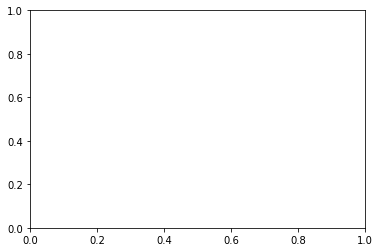

In [22]:
ax = plt.axes()
pcolor_ex = ax.pcolormesh(xx_example, yy_example, cv_rf_ex_results_df['mean_test_score'].values.reshape(4,4), cmap=plt.cm.jet)
plt.colorbar(pcolor_ex, label='Mean test score')
ax.set_xlabel('Number of trees')
ax.set_ylabel('Maximum depth')

<b>Conclude which set of hyperparameters to use.</b>

In [23]:
# Create a dataframe of the feature names and importance
# Sort values by importance
feat_imp_df = pd.DataFrame({
    'Feature name':features_response[:-1],
    'Importance':cv_rf_ex.best_estimator_.feature_importances_
})
feat_imp_df.sort_values('Importance', ascending=False)

,Feature name,Importance
4,PAY_1,0.437439
0,LIMIT_BAL,0.059961
11,PAY_AMT1,0.059434
12,PAY_AMT2,0.045518
13,PAY_AMT3,0.043299
5,BILL_AMT1,0.042195
6,BILL_AMT2,0.041562
7,BILL_AMT3,0.037268
14,PAY_AMT4,0.034321
8,BILL_AMT4,0.034123


# Problem Statement

#### Deriving Financial Insights

-  we can generate some additional insights from these results, to provide the client with more context around how the predictive model we built can generate value for them
- In particular, we have looked at results for the testing set we reserved from model building
- The client may have more accounts than those they supplied to us, as representative of their business. We should report to them results that could be easily scaled to however big their business is, in terms of number of accounts.
- We can also help them understand how much this program will cost; while the net savings are an important number to consider, the client will have to fund the counseling program before any of these savings will be obtained. Finally, we will link the financial analysis back to standard machine learning model performance metrics.

Once you complete the challenge, you should be able to communicate the initial cost of the counseling program to the client, as well as obtain plots of precision and recall such as this:

<img src="https://cdn.filestackcontent.com/GoUjSVNbSka4mBsIhPq1" width=500>

<img src="https://3.bp.blogspot.com/--jLXutUe5Ss/VvPIO6ZH2tI/AAAAAAAACkU/pvVL4L-a70gnFEURcfBbL_R-GnhBR6f1Q/w1200-h630-p-k-no-nu/ConfusionMatrix.png" width=500>

Expected precision-recall curve
This curve will be useful in interpreting the value created by the model at different thresholds.

#### Imputation of Missing Data, Financial Analysis, and Delivery to Client

- Compare the results of all models built for a case study
- Replace missing data using a range of imputation strategies
- Build a multiclass classification model
- Conduct financial analysis to find the optimal threshold for binary classification
- Derive financial insight from the model to help the client guide budgeting and operational strategy
- Deliver the model and make recommendations for usage
- This lesson presents a comparison of the results from the various models built for a study, describes the financial insights derived from the final model, and outlines the final steps of the project needed to satisfy the client's requirements.

# Review of Modeling Results

<img src="https://cdn.filestackcontent.com/4sNCKS5xQEKH6WwVJED6" width=400>

- When presenting results to the client, it would usually be better to only present the first and last columns of the figure. The client is likely not interested in all the details in the "Tuned hyperparameters" column, unless they are technically inclined. You should be prepared to interpret results for business partners at all levels of technical familiarity, including those with very little technical background.
- ROC AUC measure. In this case, you would need to explain that it's a metric that can vary between 0.5 and 1 and give intuitive explanations for these limits: 0.5 is no better than a coin flip and 1 is perfection, which is essentially unattainable. Our results are somewhere in between, getting closer to 0.8 with the best model we developed. While this number is not necessarily meaningful by itself, taken together with all the models we tried and the limitations on the ROC AUC measure.
-   you would want to try as many modeling methods as possible. More advanced methods, such as gradient-boosted decision trees or neural networks for classification, may yield improved performance on this problem. 

- Therefore, our conclusion is that a random forest model, with the hyperparameters we determined in cross-validation (200 trees and a maximum depth of 9), will be the model we recommend.

#### Dealing with Missing Data: Imputation Strategies

<img src="https://cdn.filestackcontent.com/SoHWx4gUQFOoNR7KNHY8" width=500>

Strategies for imputting missing values of features

- The simplest way to deal with samples that have missing values for certain features is to remove these samples from the dataset or to remove the features that have the missing values, While this approach allows you to immediately proceed, it has the undesirable effect of discarding potentially useful data from the dataset.
- The simplest types of imputation involve using a summary statistic of the non-missing feature values, as the single constant value with which to replace all the missing values. This summary statistic may be the mean, median, or mode for continuous features. <b>For categorial features, the mode is an option, as well as the median for ordinal categoricals.</b>
- An important additional case of imputation with a constant value for categorial variables is to create a new level of the categorical variable, to indicate data is missing. For example, if the EDUCATION feature had missing data, we could create a new level indicating that EDUCATION data was "missing," in addition to the existing levels of the EDUCATION feature.<br>
This may be the best approach when missing data for a feature indicates something about the response variable. In this case, the fact that values are missing represents important information that should not be replaced with other values for a feature. To make a decision on which method to use for imputation with a constant value, you can try cross-validation just like you would for the choice of model hyperparameters.
- More sophisticated methods of imputation can be used to fill in missing values with non-constant values. These methods reflect an acknowledgment that the missing values may not all be equal. The simplest way to do this is to fill in missing values using a random draw from the set of non-missing values, with replacement. This way, the relative frequency of different values chosen to fill in missing data will be similar to the existing data for that feature.
-  In case samples are located within time or space, such as a time series or geolocated data, then temporal or spatial interpolation methods may be used. These methods follow the general idea that a missing data point is probably located somewhere between the values of adjacent data points in time or space. There is a rich set of interpolation methods available in NumPy and Pandas that you may wish to explore if you are working with missing data for time series or geolocated data.
- Lastly, perhaps the most sophisticated way to fill in missing data is to view the imputation problem as a predictive modeling "problem within a problem." In this method, the feature with missing values is considered the response variable, while the features with no missing values are considered the features of this sub-problem.
- ou can take the samples with known values for all features, split them up in to training and testing sets similar to how you would with any other supervised learning problem, and develop a predictive model for the feature with missing values. Then, you can use this model to predict the unknown values of the feature. Because this method relies on predictive modeling, we'll refer to it as <b>model-based imputation.</b> We will use this method later on, with the case study data, to clarify how it works.

#### Preparing Samples with Missing Data

- In order to test out different imputation strategies on the case study data and <b>see how they affect the predictive capability of the modeling approach we will use, we need to replace samples with missing data back in to the dataset.</b> In order to do this, we need to use the same data cleaning procedures 

#### Cleaning the Dataset

In [2]:
#Load the original dataset from the beginning of our exploration, before any cleaning takes place:
import pandas as pd
df_orig = pd.read_excel('default_of_credit_card_clients.xls')

- we need to repeat all the data cleaning steps we took, with the exception of removing the samples where the PAY_1 feature had missing values. As a first step, we identify and drop any samples where the values of all the features are equal to 0. We had determined that this was an effective way to remove duplicate account IDs from the dataset.

Make a Boolean array indicating where entries of the DataFrame are equal to 0:

In [3]:
df_zero_mask = df_orig == 0

In [4]:
#Collapse this 2-dimensional Boolean array to 1 dimension by indicating which rows have 0s in all columns, 
#starting with the second column. 
#This array tells which rows have a value of 0 for all the features and need to be removed:
feature_zero_mask = df_zero_mask.iloc[:,1:].all(axis=1)
feature_zero_mask

0        False
1        False
2        False
3        False
4        False
         ...  
29995    False
29996    False
29997    False
29998    False
29999    False
Length: 30000, dtype: bool

In [5]:
#Check that the number of rows with all 0 values for the features is the same as what we found in Data Exploration and Cleaning:
sum(feature_zero_mask)
#This is the same as that in Data Exploration and Cleaning.

315

Use this mask to select all the other rows, that is, those that don't have values of zero for all features, and check the shape of the resulting DataFrame:

In [6]:
df_clean = df_orig.loc[~feature_zero_mask,:].copy()
df_clean.shape

(29685, 25)

In addition to getting rid of clearly invalid data (samples with all features equal to 0), the goal of this procedure was to eliminate duplicate account IDs.

In [7]:
df_clean['ID'].nunique()
#This is the same as the number of rows of the DataFrame, indicating the data has been cleansed of duplicated account IDs.

29685

Replace the undocumented values of EDUCATION and MARRIAGE features with the documented value for "unknown." We simply repeat the code from Data Exploration and Cleaning that does this:

In [8]:
df_clean['EDUCATION'].replace(to_replace=[0, 5, 6], value=4, inplace=True)
df_clean['MARRIAGE'].replace(to_replace=0, value=3, inplace=True)

The data is now in a cleaned state. The question at this point is how to include the samples with missing values for PAY_1, with the rest of the data.

- We have reserved an unseen test set from all modeling activities so far. The samples in this dataset are only to be used after we have selected our final model and wish to see if the <b>out-of-sample performance</b> that we estimated with cross-validation is reflected in the new data.

- So, it would be best to continue to keep these samples isolated from the modeling work, including the selection of an imputation strategy. In order to do this, we will subset the samples from our cleaned dataset df_clean that have missing values for PAY_1 and add them to the training and testing sets later, so that the proportion of training and testing data remains the same.

In [9]:
df_clean['PAY_1'].value_counts()

0                13087
-1                5047
1                 3261
Not available     3021
-2                2476
2                 2378
3                  292
4                   63
5                   23
8                   17
6                   11
7                    9
Name: PAY_1, dtype: int64

- Before we proceed to isolate samples where the value of PAY_1 is missing, first note that the mode of non-missing values of PAY_1, in other words the most prevalent value, is 0. We will use this fact later when trying different imputation strategies.
- The missing values in PAY_1 are indicated by the string 'Not available'.

In [10]:
missing_pay_1_mask = df_clean['PAY_1'] == 'Not available'

In [11]:
sum(missing_pay_1_mask)

3021

Make a copy of these rows in a new DataFrame which we can add to the data we've been using for modeling:

In [12]:
df_missing_pay_1 = df_clean.loc[missing_pay_1_mask,:].copy()
df_missing_pay_1.head(2)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
17,f0ba5e02-0c0f,320000,1,1,1,49,Not available,0,0,-1,...,70074,5856,195599,10358,10000,75940,20000,195599,50000,0
28,aecb449b-a999,50000,2,3,1,47,Not available,-1,-1,-1,...,2040,30430,257,3415,3421,2044,30430,257,0,0


- Load the cleaned data that we've been working with in other lessons. This data has had the 3,021 samples with a missing value of PAY_1 already removed from it, so it is an entirely different set of samples than what we've got stored in df_missing_pay_1:

In [13]:
df = pd.read_csv('cleaned_data.csv')

- Make a list of the column names of this DataFrame and then remove the strings that are not part of the set of features and the response variable. Here are the column names:

In [14]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'EDUCATION_CAT', 'graduate school',
       'high school', 'others', 'university'],
      dtype='object')

Assign the column names to a list:

In [15]:
features_response = df.columns.tolist()

- Then, make a list of column names that are not the features or the response, so we can remove them:

In [16]:
items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'EDUCATION_CAT', 'graduate school', 'high school', 'none',
                   'others', 'university']

- Use a list comprehension to remove the unwanted column names and display the result:

In [17]:
features_response = [item for item in features_response if item not in items_to_remove]
features_response

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

- This list of column names will come in handy when we are selecting data from the DataFrames including missing and non-missing values for PAY_1, in order to combine them and test different imputation strategies, which will be done in the following activity.

#### Mode and Random Imputation of PAY_1

- In this example, we will try some of the simpler imputation strategies available for PAY_1 and see their effects on cross-validation performance. The first steps will be to append the samples with missing values for PAY_1 to the end of the testing set we've been working with, that has non-missing PAY_1. We'll need to shuffle this when performing cross-validation so that the samples with missing PAY_1 don't all wind up in the same fold, which would create a situation where data in one of the folds was different that the others.
- Although PAY_1 has numeric values, it's a sort of hybrid between a categorical and a numerical feature as we discussed previously. We will basically treat it as categorical for the purposes of imputation, since if we were to take an average of the non-missing values of PAY_1, for example, the result might not be an integer, which would not be interpretable given the definition of PAY_1. Therefore, the simplest imputation strategies we have available are mode and median. A slightly more complex one is a random selection from the samples with non-missing PAY_1. We'll explore these here. Perform the following steps to complete the activity:

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = \
train_test_split(df[features_response[:-1]].values, df['default payment next month'].values,
test_size=0.2, random_state=24)

In [20]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(21331, 17)
(5333, 17)
(21331,)
(5333,)


In [21]:
features_response[4]

'PAY_1'

In [22]:
#Find the values of PAY_1 we may use for imputation. First check, what the median of PAY_1 is using the following code:
np.median(X_train[:,4])

0.0

- We see that the median of the non-missing values of PAY_1 is 0. Recall from our value_counts of PAY_1 above, that the mode of non-missing PAY_1 is also 0.
Since the median and mode are the same, we only have two imputation strategies to test in this activity: the mode/median and a random selection of non-missing.

- Create a list of values to test for imputation. We can use a single numerical value of 0 representing the median and mode, as well as use NumPy's random.choice function to take a random sample of non-missing PAY_1:

In [23]:
np.random.seed(seed=1)
fill_values = [0, np.random.choice(X_train[:,4], size=(3021,), replace=True)]
fill_values

[0, array([ 0,  0,  0, ...,  2,  0, -2], dtype=int64)]

- Notice here, for the random sample, that we've seeded the random number generator for consistent results across runs, indicated the array to take the random selection from (the non-missing values of PAY_1 in the training data: X_train[:,4]), indicated the size of the random sample to be the same length as the column of missing PAY_1 values in df_missing_pay_1 (3,021), and that we would like to sample with replacement.

Create a list of names for the imputation strategies to help keep track of them:

In [24]:
fill_strategy = ['mode', 'random']

- Examine the second element of the fill_values list, which is the array of random selections of PAY_1

- The output looks as expected; these values are integers in the range [-2, 8] as we know PAY_1 is. However, it would be better to view a summary graphic of all the imputed values, to compare them to the distribution of PAY_1. This would allow us to confirm the distributions are the same, as is intended by random imputation done in this way.

- Use histograms to examine the distributions of the original non-missing PAY_1 feature in the training set and the randomly selected imputed values:

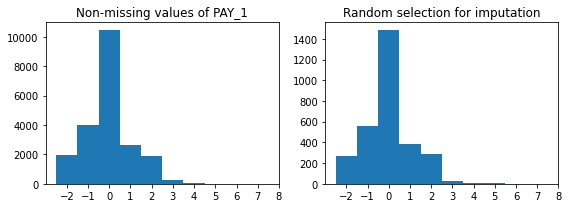

In [33]:
import matplotlib.pyplot as plt #plotting package
%matplotlib inline
fig, axs = plt.subplots(1,2, figsize=(8,3))
bin_edges = np.arange(-2,9)
axs[0].hist(X_train[:,4], bins=bin_edges, align='left')
axs[0].set_xticks(bin_edges)
axs[0].set_title('Non-missing values of PAY_1')
axs[1].hist(fill_values[-1], bins=bin_edges, align='left')
axs[1].set_xticks(bin_edges)
axs[1].set_title('Random selection for imputation')
plt.tight_layout()

- These two distributions look very similar. Only the scale of the y-axis indicates that there are fewer imputed values than in the original dataset. This shows that we have selected values for PAY_1 that faithfully imitate the relative frequency of different values of this feature in the data. Now, we are ready to set up the cross-validation we can use to compare imputation methods.

- We do not need to do a cross-validation search for hyperparameters here, as we did with the scikit-learn function GridSearchCV. At this point, we already know that random forest is the model we will use, and we know what hyperparameters we should use. We just want to perform cross-validation with one set of hyperparameters, in order to have several estimates of the out-of-sample testing score. For this, we can use a similar, but simpler class called cross_validate, in combination with the KFold class. These classes can help us carry out cross-validation like GridSearchCV, but do not involve a search over a grid of hyperparameters

In [25]:
from sklearn.model_selection import KFold

In [26]:
k_folds = KFold(n_splits=4, shuffle=True, random_state=1)

- We also say that we would like to shuffle the data before splitting in to folds. This is important because we will append the samples with imputed values to the end of the training features and response arrays. However, when we perform cross-validation, we'd like these samples to be "mixed up" throughout the four folds so that each fold has some imputed values in it. We also set the random seed for repeatability.

In [27]:
from sklearn.model_selection import cross_validate

In [28]:
from sklearn.ensemble import RandomForestClassifier

Instantiate the random forest class, using the hyperparameters we've determined are best for the case study data: 200 trees with maximum depth 9:

In [29]:
rf = RandomForestClassifier(
    n_estimators=200, criterion='gini', max_depth=9,
    min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
    max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
    min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None,
    random_state=4, verbose=1, warm_start=False, class_weight=None)

- While we are working with slightly different data, due to the imputed values, we will assume that the hyperparameters we determined for the random forest are still the right ones to use. Now, we will embark on the cross-validation. This is a long code cell, so we will split it up over several steps.
- Open a for, loop. This loop will work over the different imputation strategies we have, of which there are two:

In [30]:
for counter in range(len(fill_values)):
        #Copy the data frame with missing PAY_1 and assign imputed values
        df_fill_pay_1_filled = df_missing_pay_1.copy()
        df_fill_pay_1_filled['PAY_1'] = fill_values[counter]
        
        #Split imputed data in to training and testing, using the same
        #80/20 split we have used for the data with non-missing PAY_1
        X_fill_pay_1_train, X_fill_pay_1_test, y_fill_pay_1_train, y_fill_pay_1_test = \
        train_test_split(
            df_fill_pay_1_filled[features_response[:-1]].values,
            df_fill_pay_1_filled['default payment next month'].values,
            test_size=0.2, random_state=24)
            #Concatenate the imputed data with the array of non-missing data
        X_train_all = np.concatenate((X_train, X_fill_pay_1_train), axis=0)
        y_train_all = np.concatenate((y_train, y_fill_pay_1_train), axis=0)
        
        #Use the KFolds splitter and the random forest model to get
        #4-fold cross-validation scores for both imputation methods
        imputation_compare_cv = cross_validate(rf, X_train_all, y_train_all, scoring='roc_auc',
        cv=k_folds, n_jobs=-1, verbose=1,
        return_train_score=True, return_estimator=True,
        error_score='raise-deprecating')
 
        test_score = imputation_compare_cv['test_score']
        print(fill_strategy[counter] + ' imputation: ' +
          'mean testing score ' + str(np.mean(test_score)) +
          ', std ' + str(np.std(test_score)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   23.2s remaining:   23.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   23.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


mode imputation: mean testing score 0.772866246168149, std 0.0031479941297533737


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   21.0s remaining:   21.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   21.2s finished


random imputation: mean testing score 0.7692540439833129, std 0.003660875187678248


- n_jobs=-1, indicating to run jobs in parallel to make things go more quickly.
- The printed output here indicates that these two imputation strategies have very similar performances. However, the simplest imputation strategy, just filling in all missing values of PAY_1 with the most common value of 0 from the non-missing samples, performs the best: the average testing score (ROC AUC) across the four folds is 0.773 for mode imputation, versus 0.769 using random imputation.
- What about the average testing score here, where we've included the samples with missing data, versus the average testing score we observed when only using the data where all the values of the features were known? That was 0.776. So, we have experienced a little degradation in the estimate of out-of-sample model testing performance. This is to be expected, as we are now including data that has issues and uncertainties. However, this is still within 0.006 ROC AUC units of the best score we observed when working with the non-missing data, so it's not too much lower. 

#### A Predictive Model for PAY_1 

The most accurate, but also the most labor-intensive way to impute a feature with missing values is to create a predictive model for that feature. You can think of this as a natural extension of simpler methods, using progressively more information from the dataset when imputing the missing values:

- The simplest methods like mean, median, mode, and random selection just use information from non-missing values of the feature.
- Intermediately complex methods like interpolation use additional information about how "close" a given sample is to other samples, in the spatial or temporal context, and leverage this for more accurate imputation.
- Finally, model-based imputation additionally uses all features without missing values, to predict the missing values of the affected feature. Therefore, model-based imputation is similar to any other predictive model, where we consider the feature with missing values to be the response variable.

- As we consider how to create a predictive model for PAY_1, think about how this model would be similar to, or different from, other models we've considered.The different types of supervised machine learning models are regression and classification. As we discussed earlier, we would not consider PAY_1 to be a numerical feature. Taking an average for imputation, which may lead to a decimal value, will not make sense according to the definition of this feature. We will face this same issue if we tried to model PAY_1 on a continuous scale, as would be done using regression algorithms. Therefore, when considering what kind of supervised learning model to use for PAY_1, we know it should be a classification model
- However, the classification model for PAY_1 will be different than the classification model for credit account default that we have built for the case study data. This is because, unlike the credit default problem, where the response variable can only take on two values (account defaults or account does not default), there are more than two values for PAY_1. These include all the levels of this variable from -2 through 8. Therefore, as opposed to a binary classification problem, the model for PAY_1 will be a multiclass classification problem.

In [31]:
pay_1_df = df.copy()

In [32]:
features_for_imputation = pay_1_df.columns.tolist()

- We subset this down to the list of features for the imputation model by removing the names of all metadata, as well as 'default payment next month' which we don't need here and 'PAY_1' which is the response variable for this problem:

In [33]:
items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'EDUCATION_CAT', 'graduate school', 'high school', 'none',
                   'others', 'university', 'default payment next month', 'PAY_1']

In [34]:
features_for_imputation = [item for item in features_for_imputation if item not in items_to_remove]
features_for_imputation

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

#### Building a Multiclass Classification Model for Imputation

In [35]:
X_impute_train, X_impute_test, y_impute_train, y_impute_test = \
train_test_split(
    pay_1_df[features_for_imputation].values,
    pay_1_df['PAY_1'].values,
test_size=0.2, random_state=24)

In [36]:
rf_impute_params = {'max_depth':[3, 6, 9, 12],
             'n_estimators':[10, 50, 100, 200]}

In [37]:
from sklearn.model_selection import GridSearchCV
cv_rf_impute = GridSearchCV(rf, param_grid=rf_impute_params, scoring='accuracy', n_jobs=-1, iid=False, refit=True,
cv=4, verbose=2, error_score=np.nan, return_train_score=True)

-  All the options should be at their defaults except n_estimators and max_depth, which will be varied here though the grid-search process.
- When we instantiate the GridSearchCV class, we do so in a similar way to before, but here we use the accuracy method as noted earlier. We also allow for parallel processing with n_jobs=-1

In [38]:
cv_rf_impute.fit(X_impute_train, y_impute_train)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:  2.3min finished
C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   21.3s finished


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_depth=9, n_estimators=200,
                                              random_state=4, verbose=1),
             iid=False, n_jobs=-1,
             param_grid={'max_depth': [3, 6, 9, 12],
                         'n_estimators': [10, 50, 100, 200]},
             return_train_score=True, scoring='accuracy', verbose=2)

In [39]:
#Observe the hyperparameters from the best model of cross-validation:
cv_rf_impute.best_params_

{'max_depth': 12, 'n_estimators': 200}

In [40]:
#See what the accuracy score of the best model is:
cv_rf_impute.best_score_

0.7344242187492307

In [41]:
pay_1_value_counts = pay_1_df['PAY_1'].value_counts().sort_index()
pay_1_value_counts

-2     2476
-1     5047
 0    13087
 1     3261
 2     2378
 3      292
 4       63
 5       23
 6       11
 7        9
 8       17
Name: PAY_1, dtype: int64

In [42]:
pay_1_value_counts/pay_1_value_counts.sum()

-2    0.092859
-1    0.189281
 0    0.490812
 1    0.122300
 2    0.089184
 3    0.010951
 4    0.002363
 5    0.000863
 6    0.000413
 7    0.000338
 8    0.000638
Name: PAY_1, dtype: float64

- So, using mode imputation, the imputation value would be expected to be correct about 49% of the time. However, using a model to impute the values of PAY_1, our results in step 6 indicate we can be correct 73% of the time. So, one benefit of using model-based imputation is that we can make more accurate fill values for the unknown values of a feature.

- To check that the cross-validation accuracy generalizes to the test set, we need to make predictions on the test set:

In [43]:
y_impute_predict = cv_rf_impute.predict(X_impute_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.2s finished


In [44]:
y_impute_predict

array([-1,  1,  0, ..., -1,  1,  0], dtype=int64)

In [45]:
from sklearn import metrics
metrics.accuracy_score(y_impute_test, y_impute_predict)

0.7391711981998875

The accuracy on the test set of 74% is comparable to, and a little higher than, the average cross-validation accuracy of 73%.

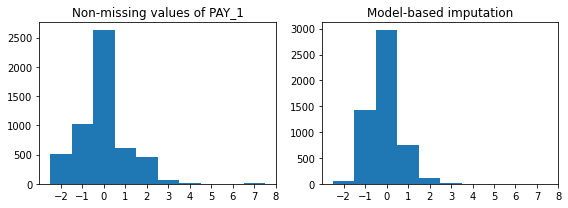

In [57]:
fig, axs = plt.subplots(1,2, figsize=(8,3))
axs[0].hist(y_impute_test, bins=bin_edges, align='left')
axs[0].set_xticks(bin_edges)
axs[0].set_title('Non-missing values of PAY_1')
axs[1].hist(y_impute_predict, bins=bin_edges, align='left')
axs[1].set_xticks(bin_edges)
axs[1].set_title('Model-based imputation')
plt.tight_layout()

- Collect all the values with known PAY_1 to train the final version of the imputation model:

In [46]:
X_impute_all = pay_1_df[features_for_imputation].values
y_impute_all = pay_1_df['PAY_1'].values

Define a random forest model with the optimal hyperparameters for imputation:

In [47]:
rf_impute = RandomForestClassifier(n_estimators=100, max_depth=12)

Fit the imputation model on all available data:

In [48]:
rf_impute.fit(X_impute_all, y_impute_all)

RandomForestClassifier(max_depth=12)

- This model is now ready to be used for imputation.

#### Using the Imputation Model and Comparing it to Other Methods

- We created the model for model-based imputation, so we may now use model-imputed values for PAY_1 in cross-validation with the credit account default model and see how the performance is, in comparison to the simpler imputation methods we already tried. To start, make a copy of the DataFrame with missing PAY_1:

In [49]:
df_fill_pay_1_model = df_missing_pay_1.copy()

In [50]:
df_fill_pay_1_model['PAY_1'].head()

17    Not available
28    Not available
29    Not available
54    Not available
60    Not available
Name: PAY_1, dtype: object

In [51]:
df_fill_pay_1_model['PAY_1'] = rf_impute.predict(df_fill_pay_1_model[features_for_imputation].values)

In [52]:
df_fill_pay_1_model['PAY_1']

17       0
28      -1
29       0
54       0
60       0
        ..
29949    0
29956   -1
29967    0
29973    1
29984   -1
Name: PAY_1, Length: 3021, dtype: int64

In [53]:
df_fill_pay_1_model['PAY_1'].head()

17    0
28   -1
29    0
54    0
60    0
Name: PAY_1, dtype: int64

- This shows the values were imputed as desired. We can see from the output that not all the values are the same, as we'd expect. We can make a quick examination of the predictions using the value_counts method:

In [54]:
df_fill_pay_1_model['PAY_1'].value_counts().sort_index()

-2      30
-1     763
 0    1715
 1     438
 2      64
 3       7
 4       2
 6       1
 8       1
Name: PAY_1, dtype: int64

- From the output, we can see that there is a range of prediction values of PAY_1 from the imputation model, roughly in the relative frequencies that we expect. Now, we need to take an 80% sample of these to combine with the model training data for the case study, to examine how this imputation method affects model performance, as we did for mode and random imputation.

- Split the model-imputed data as follows:

In [55]:
X_fill_pay_1_train, X_fill_pay_1_test, y_fill_pay_1_train, y_fill_pay_1_test = \
train_test_split(
    df_fill_pay_1_model[features_response[:-1]].values,
    df_fill_pay_1_model['default payment next month'].values,
    test_size=0.2, random_state=24)

Combine this with the data with known PAY_1 as before:

In [56]:
X_train_all = np.concatenate((X_train, X_fill_pay_1_train), axis=0)
y_train_all = np.concatenate((y_train, y_fill_pay_1_train), axis=0)

- Confirm that the rf object still holds the model with optimal hyperparameters for the case study problem:

- The rf object holds a random forest classifier with 200 trees and maximum depth of 9, as expected. Now, use this model with the combined imputed and non-missing training data in cross-validation as we did with the other imputation methods, to test model-based imputation:

In [57]:
imputation_compare_cv = cross_validate(rf, X_train_all, y_train_all, scoring='roc_auc',
cv=k_folds, n_jobs=-1, verbose=1,
    return_train_score=True, return_estimator=True,
    error_score='raise-deprecating')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   20.9s remaining:   20.9s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   21.0s finished


- When this process completes, you can examine the average model testing score across the four folds as follows:

In [58]:
np.mean(imputation_compare_cv['test_score'])

0.7726757126815554

- How does the result of model-based imputation compare with the simpler mode and random methods? An average cross-validated ROC AUC here of 0.7727 is very close to, but slightly worse than, our previous best result of 0.7729 from mode-based imputation.
- For all intents and purposes, mode-based and model-based imputations have essentially the same performance. Note that the standard deviation for cross-validation score with mode-based imputation calculated above is 0.003, so the average model-based imputation score is within one standard deviation of the best method. Which should we use?
- From a simplicity standpoint, the mode-based imputation is the clear favorite. The code to implement this is much more concise than the model-based imputation we've just completed. The only reason to go with model-based imputation would be if the client knows we could also make predictions for PAY_1 and would like to have them. We consult with our client about this and learn that they are only interested in the predictions of credit default. So, we move forward with the simpler imputation method.

- First, reassign the filled values using imputation with the mode of 0:

In [59]:
df_fill_pay_1_model['PAY_1'] = np.zeros_like(df_fill_pay_1_model['PAY_1'].values)

- The zeros_like function of Numpy creates an array of zeros in the same shape as the input array. Check that this worked:

In [60]:
df_fill_pay_1_model['PAY_1'].unique()

array([0], dtype=int64)

In [61]:
X_fill_pay_1_train, X_fill_pay_1_test, y_fill_pay_1_train, y_fill_pay_1_test = \
train_test_split(
    df_fill_pay_1_model[features_response[:-1]].values,
    df_fill_pay_1_model['default payment next month'].values,
test_size=0.2, random_state=24)

- and combined with the non-missing data, this time including the unseen test set which we'll use shortly:

In [62]:
X_train_all = np.concatenate((X_train, X_fill_pay_1_train), axis=0)
X_test_all = np.concatenate((X_test, X_fill_pay_1_test), axis=0)
y_train_all = np.concatenate((y_train, y_fill_pay_1_train), axis=0)
y_test_all = np.concatenate((y_test, y_fill_pay_1_test), axis=0)

- Just to confirm that the data has been restored to the state it was in when we tested mode-based imputation earlier, we run the cross-validation to confirm that we get the same score:

In [63]:
imputation_compare_cv = cross_validate(rf, X_train_all, y_train_all, scoring='roc_auc',
cv=k_folds, n_jobs=-1, verbose=1,
    return_train_score=True, return_estimator=True,
    error_score='raise-deprecating')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   20.7s remaining:   20.7s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   20.8s finished


- After running the cross-validation, compute the average score:

In [64]:
np.mean(imputation_compare_cv['test_score'])

0.772866246168149

- We have now completed the selection of imputation strategy.

#### Confirming Model Performance on the Unseen Test Set

- We are nearly done building the model for the case study data. The final step in the model building process is to examine model performance on the test set, which we have reserved from using for any model-building activities up till now.

- This is typical, as one would like to make sure that the testing data are cleaned in the same way the training data have been.

-  the test set gives us a way to truly see how the model performs on data that was never used to fit the model. 

- Now that we have assembled all the non-imputed and imputed data for training and testing, we can train the final model like this:

In [65]:
rf.fit(X_train_all, y_train_all)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   16.0s finished


RandomForestClassifier(max_depth=9, n_estimators=200, random_state=4, verbose=1)

- Finally, we make predictions for credit default on the testing set. We need to predict probabilities so we can calculate ROC AUC:

In [66]:
y_test_all_predict_proba = rf.predict_proba(X_test_all)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


- Import the roc_auc_score function and calculate the testing score:

In [67]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test_all, y_test_all_predict_proba[:,1])

0.7696243835824927

- What has the testing score revealed? The appropriate comparison to make here is with the cross-validated testing score we computed using the mode-imputed PAY_1, which was 0.773. We can see that the testing score here, of 0.770, is roughly within 1 standard deviation of the cross-validation estimate. We conclude that the model is robust and is ready for delivery to the client.

- At this point, model building activities have completed. A final step before delivering a trained scikit-learn model would be to fit it on all of the available data, including the unseen test set. This would be done by concatenating the training and testing data features (X_train_all, X_test_all) and labels (y_train_all, y_test_all), and using them to fit a model.

# Financial Analysis

- the data scientist needs to know the answers to, in order to figure out how to apply the model for the client:<br>
    
    - What kinds of decisions does the client want to use the model to help them make?
    - How can the predicted probabilities of a binary classification model be used to help make these decisions?
    - Are they yes/no decisions? Then choosing a single threshold of predicted probability will be sufficient.
    - Are there more than two levels of activity that will be decided on, based on model results? Then choosing 2 or more             thresholds, for example to sort predictions in to low, medium, and high risk, may be the solution. In this case,               predicted probabilities below 0.5 may be considered low risk, those between 0.5 and 0.75 medium risk, and those above           0.75 high risk.
    - What are the costs of taking all the different courses of action that are available, based on model guidance?    
    - What are the potential benefits to be gained from successful actions taken as a result of model guidance?

# Financial Conversation with the Client

- We ask the case study client about the points outlined above and learn the following: for credit accounts that are at a high risk of default, the client is designing a new program to provide individualized counseling for the account holder, to encourage them to pay their bill on time or provide alternative payment options if that will not be possible. Credit counseling is performed by trained customer service representatives who work in a call center. The cost per attempted counseling session is NT$7,500 and the expected success rate of a session is 70%, meaning that on average 70% of the recipients of phone calls offering counseling will pay their bill on time, or make alternative arrangements that are acceptable to the creditor. The potential benefits of successful counseling are that the amount of an account's monthly bill will be realized as savings, if it was going to default but instead didn't, as a result of the counseling. Currently, the monthly bills for accounts that default are reported as losses.
- After having the above conversation with the client, we have the materials we need to make a financial analysis. The client would like us to help them decide which members to contact and offer credit counseling to. If we can help them narrow down the list of people who will be contacted for counseling, we can help save them money by avoiding unnecessary and expensive contacts. The clients' limited resources for counseling will be more appropriately spent on accounts that are at higher risk of default. This should create greater savings due to prevented defaults. Additionally, the client lets us know that our analysis can help them request a budget for the counseling program, if we can give them an idea of how many counseling sessions it would be worthwhile to offer.
- As we proceed to the financial analysis, we see that the decision that the model will help the client make, on an account by account basis, is a yes/no decision: whether to offer counseling to the holder of a given account. Therefore, our analysis should focus on finding an appropriate threshold of predicted probability, by which we may divide our accounts in to two groups: higher risk accounts that will receive counseling and lower risk ones that won't

# Characterizing Costs and Savings

- Create a range of thresholds to calculate expected costs and benefits of counseling with this code

In [68]:
thresholds = np.linspace(0, 1, 101)
thresholds

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

- Now, we need to know the potential savings of a prevented default. To calculate this precisely, we would need to know the next month's monthly bill. However, the client has informed us that this will not be available at the time they need to create the list of account holders to be contacted. Therefore, in order to estimate the potential savings, we will use the average amount of the most recent monthly bill across all accounts, to represent the potential savings of a prevented default for each account.
- In reality, some accounts will have larger monthly bill amounts and others will have smaller ones. If there were an important relationship between the bill amount and the probability of default, using an average bill amount to calculate savings for all accounts may not produce accurate results. In this case, a predictive modeling activity could be attempted to estimate the next month's bill for each account, and thus make a more accurate guess as to the potential savings per account. However, bill amounts were not among the top five features for the random forest model, so the association with probability of default is not as strong as with other features. Consequently, this simplifying assumption will probably not affect the results too much.

We will use the testing data to create this analysis, as this provides a simulation of how the model will be used after we deliver it to the client: on new accounts that weren't used for model training.

In [69]:
df[features_response[:-1]].columns[5]

'BILL_AMT1'

This is the most recent months' bill.

Capture the average bill amount as the potential savings per default and observe it:

In [70]:
savings_per_default = np.mean(X_test_all[:, 5])
savings_per_default

51601.7433479286

The average of the most recent months' bill across all accounts is NT\$51,602. So, using the assumption that this is the opportunity for savings of a prevented default for each account, the net savings after a cost of NT$7,500 for credit counseling will be NT$44,102. This indicates a potential for net savings in the credit counseling program.

The issue is that not all accounts will default. For an account that wouldn't default, a counseling session represents a wasted NT$7,500. Our analysis needs to balance the costs of counseling with the risk of default.

Store the cost of counseling in a variable to use for analysis:

In [71]:
cost_per_counseling = 7500

We also know from the client that the counseling program isn't 100% effective. We should take this in to account in our analysis.

Store the effectiveness rate the client gave us for use in analysis:

In [72]:
effectiveness = 0.70

Now, we will calculate costs and savings for each of the thresholds. We'll step through each calculation and explain it, but for now, we need to create empty arrays to hold the results for each threshold.

Create empty arrays to store analysis results. We'll explain what each one will hold in the following steps:

In [73]:
n_pos_pred = np.empty_like(thresholds)
cost_of_all_counselings = np.empty_like(thresholds)
n_true_pos = np.empty_like(thresholds)
savings_of_all_counselings = np.empty_like(thresholds)
savings_based_on_balances = np.empty_like(thresholds)

These create empty arrays with the same number of elements as there are thresholds in our analysis. We will loop through each threshold value to fill these arrays.

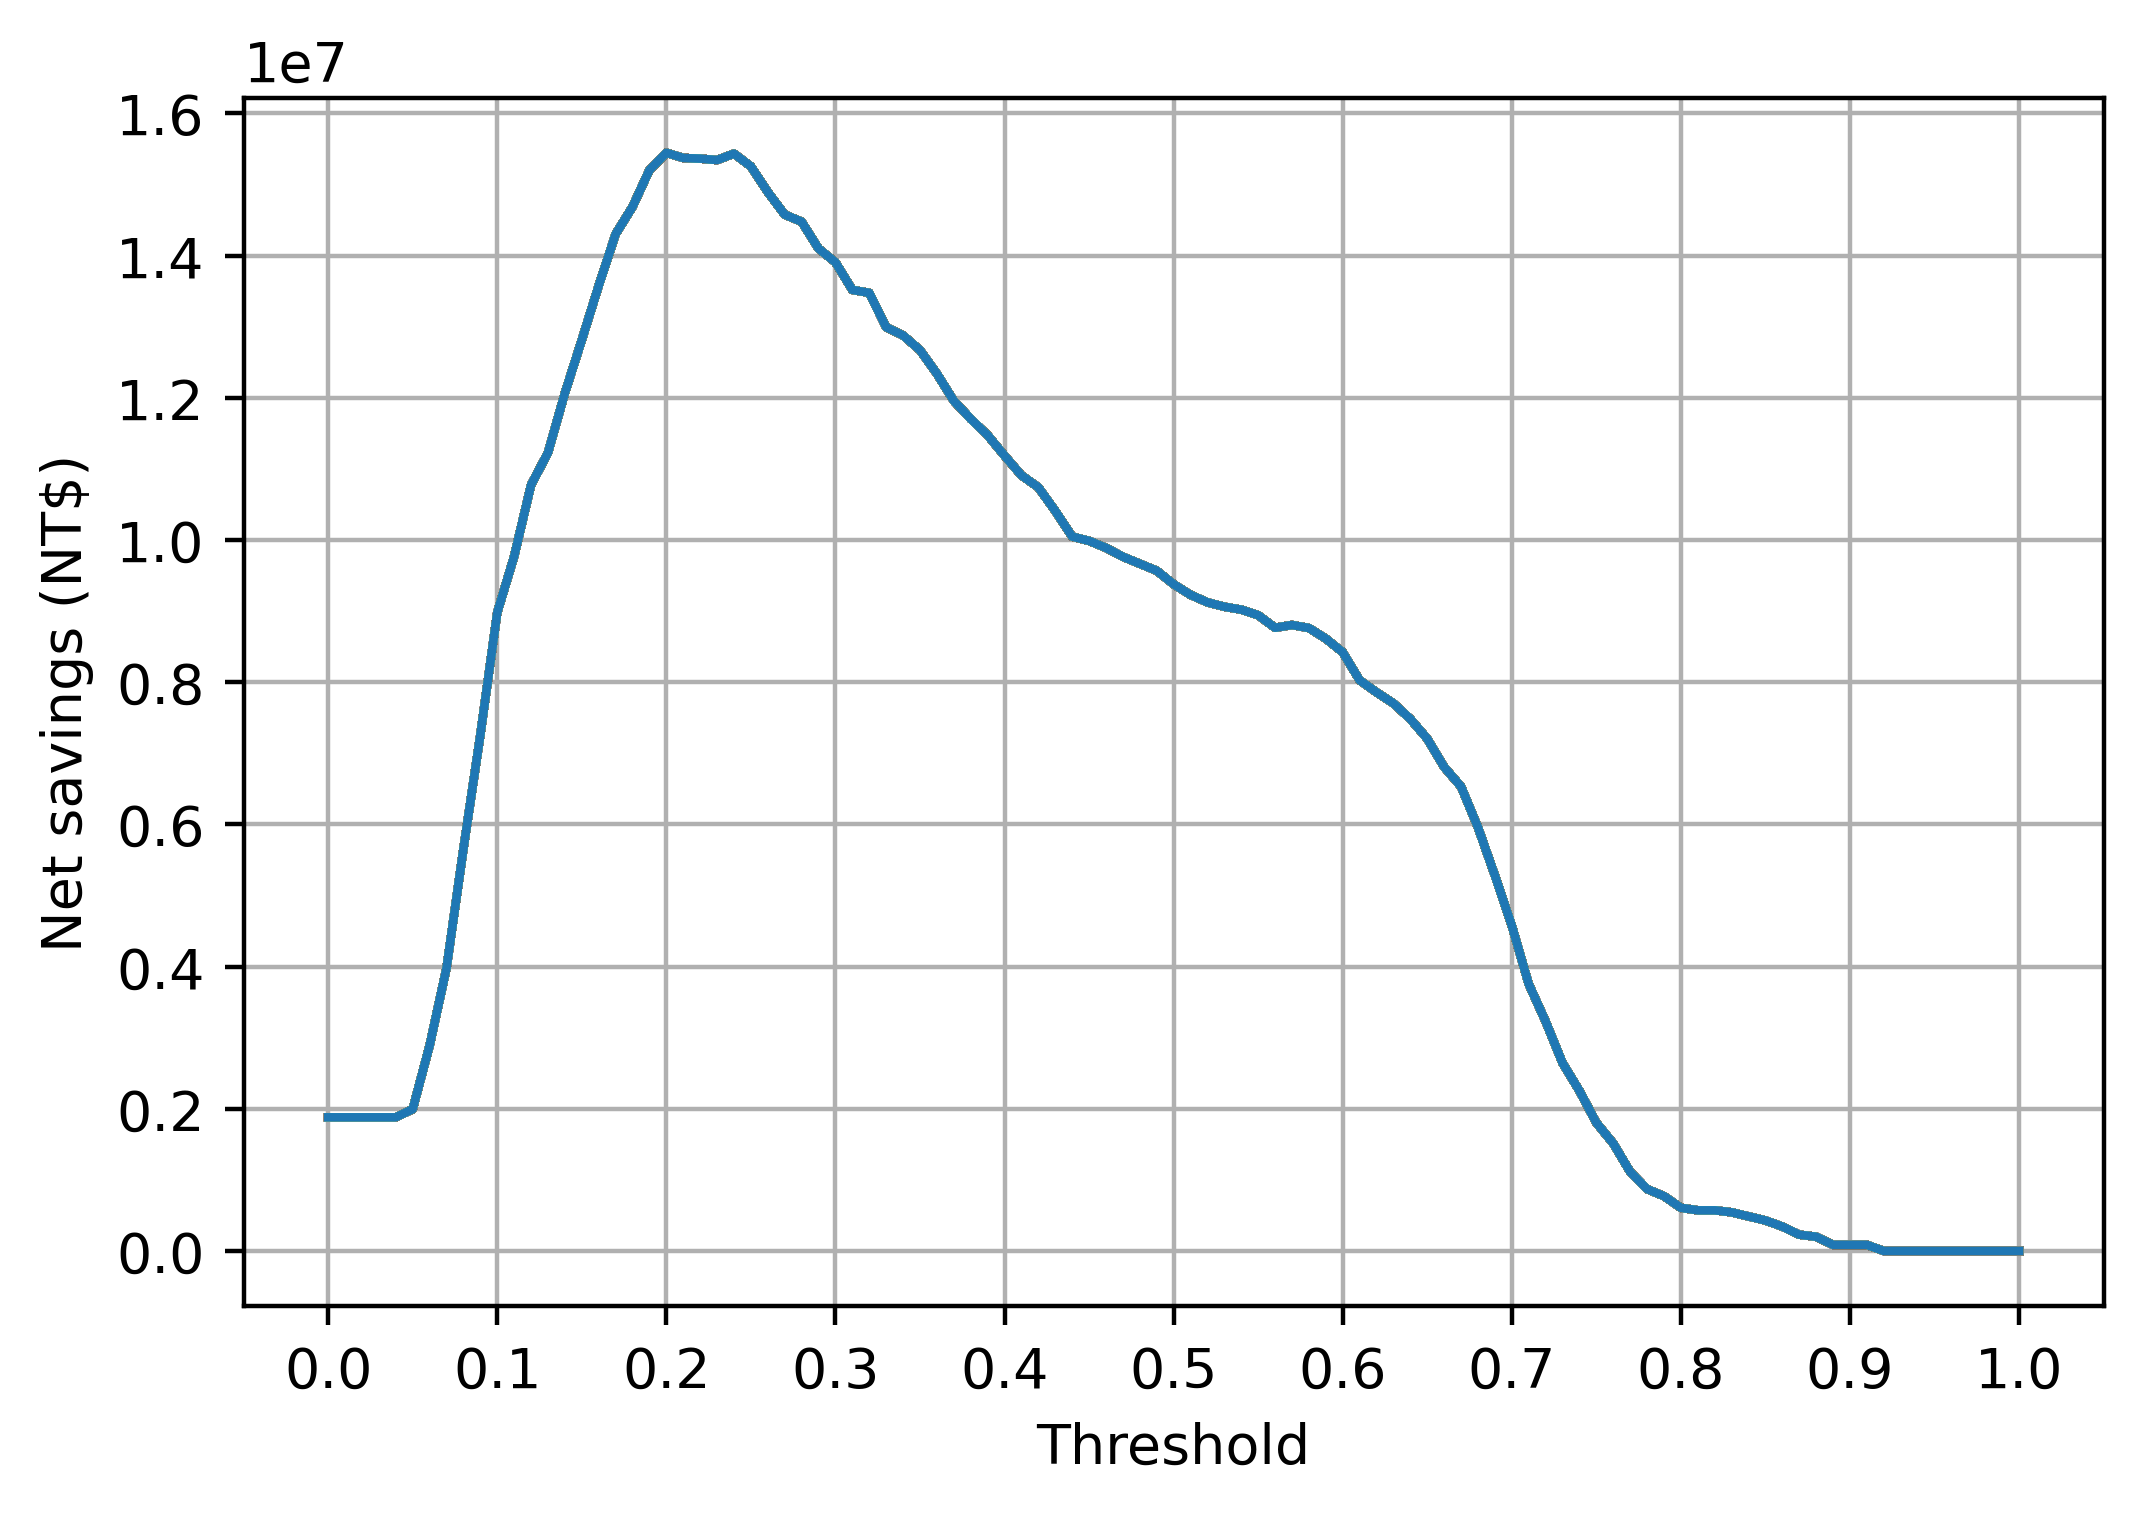

In [78]:
counter = 0
for threshold in thresholds:
        pos_pred = y_test_all_predict_proba[:,1]>threshold
        n_pos_pred[counter] = sum(pos_pred)
        cost_of_all_counselings[counter] = n_pos_pred[counter] * cost_per_counseling
        true_pos = pos_pred & y_test_all.astype(bool)
        n_true_pos[counter] = sum(true_pos)
        #Calculate the anticipated savings at this threshold using the number of true positives, the savings per prevented default, and the effectiveness rate of counseling:
        savings_of_all_counselings[counter] = n_true_pos[counter] * savings_per_default * effectiveness
        counter += 1
        #Calculate net savings for all the thresholds by subtracting the savings and cost arrays:
        net_savings = savings_of_all_counselings - cost_of_all_counselings
        import matplotlib as mpl
        import matplotlib.pyplot as plt
        mpl.rcParams['figure.dpi'] = 400
        plt.plot(thresholds, net_savings)
        plt.xlabel('Threshold')
        plt.ylabel('Net savings (NT$)')
        plt.xticks(np.linspace(0,1,11))
        plt.grid(True)


Now, we're in a position to visualize how much money we might help our client save by providing counseling to the appropriate account holders. Let's visualize this.
Plot the net savings against the thresholds as follows:

- The plot indicates that the choice of threshold is important. While it will be possible to create net savings at many different values of the threshold, it looks like the highest net savings will be generated by setting the threshold somewhere in the range of about 0.2 to 0.25.

Let's confirm the optimal threshold for creating the greatest savings and see how much the savings are.

Find the index of the largest element of the net savings array using NumPy's argmax:

In [79]:
max_savings_ix = np.argmax(net_savings)

Display the threshold that results in the greatest net savings:

In [80]:
thresholds[max_savings_ix]

0.2

Display the greatest possible net savings:

In [81]:
net_savings[max_savings_ix]

15446325.35991916

- We see that the greatest net savings occurs at a threshold of 0.2 of predicted probability of default. The amount of net savings realized at this threshold is over NT$15 million, for the testing dataset of accounts. These savings would need to be scaled by the number of accounts served by the client, to estimate the total possible savings, assuming the data we are working with is representative of all these accounts.

- Note, however, that the savings is about the same up to a threshold of about 0.25, as seen in the plot of net savings versus thresholds.

<blockquote>As the threshold increases, we are "raising the bar" for how risky a client must be, in order for us to contact them and offer counseling. Increasing the threshold from 0.2 to 0.25 means we would be only contacting riskier clients whose probability is > 0.25. This means contacting fewer clients, reducing the up-front cost of the program. The plot of net savings versus thresholds indicates that we may be still able to create the same amount of net savings, by contacting fewer people. While the net effect is the same, the initial expenditure on counseling will be smaller. This may be desirable to the client. We explore this concept further in the following challenge.</blockquote>

# Final Thoughts on Delivering the Predictive Model to the Client

- A key contribution is the predictive capability embodied in the trained model. Assuming the client has the capability to work with the trained model object we created in scikit-learn, this model could be saved to disk and sent to the client. Then, the client would be in a position to use it within their workflow. Alternatively, it may be necessary to express the model as a mathematical equation (i.e. logistic regression) or a set of if-then statements (i.e. decision tree or random forest) that the client could use to implement the predictive capability in SQL. While expressing random forests in SQL code is cumbersome due to the possibility of having many trees with many levels, there are software packages which will create this representation for you.
- Before using the model to make predictions, the client would need to ensure that the data were prepared in the same way they were for the model building we have done. For example, the removal of samples with values of 0 for all the features, the cleaning of the EDUCATION and MARRIAGE features, and the imputation of PAY_1, would all have to be done in the same way we demonstrated earlier in this lesson. Alternatively, there are other possible ways to deliver model predictions, such as an arrangement where the client delivers data to the data scientist and receives the predictions back.
- Another important consideration for the discussion of deliverables is: what format should the predictions be delivered in? A typical delivery format for predictions from a binary classification model, like that we've created for the case study, is to rank accounts on their predicted probability of default. The predicted probability should be supplied along with the account ID and whatever other columns the client would like. This way, when the call center is working their way through the list of account holders to offer counseling to, they can contact those at highest risk for default first and proceed to lower priority account holders as time and resources allow. The client has been informed of which threshold to use for predicted probabilities, to result in the highest net savings. This threshold would represent the stopping point on the list of account holders to contact, if it is ranked on predicted probability of default.
- Finally, depending on how long the client has engaged the data scientist for, it is always beneficial to monitor the performance of the model over time, as it is being used. Does predictive capability remain the same or degrade over time? When assessing this, it's important to keep in mind that if account holders are receiving counseling, their probability of default would be expected to be lower than the predicted probability indicates, due to the intended effects of the new counseling program. For this reason, and also to test the effectiveness of the counseling program, it is good practice to reserve a randomly chosen portion of account holders who will not receive any counseling, regardless of credit default risk. This group will be known as the control group and should be small compared to the rest of the population who receives counseling, but large enough to draw statistically significant inferences from
- <b>A relatively simple way to monitor a model implementation is to see if the nature of model predictions is changing over time, as compared to the population used for model training. This can be done by plotting the predicted probabilities, using a histogram:</b>

Text(0, 0.5, 'Number of accounts')

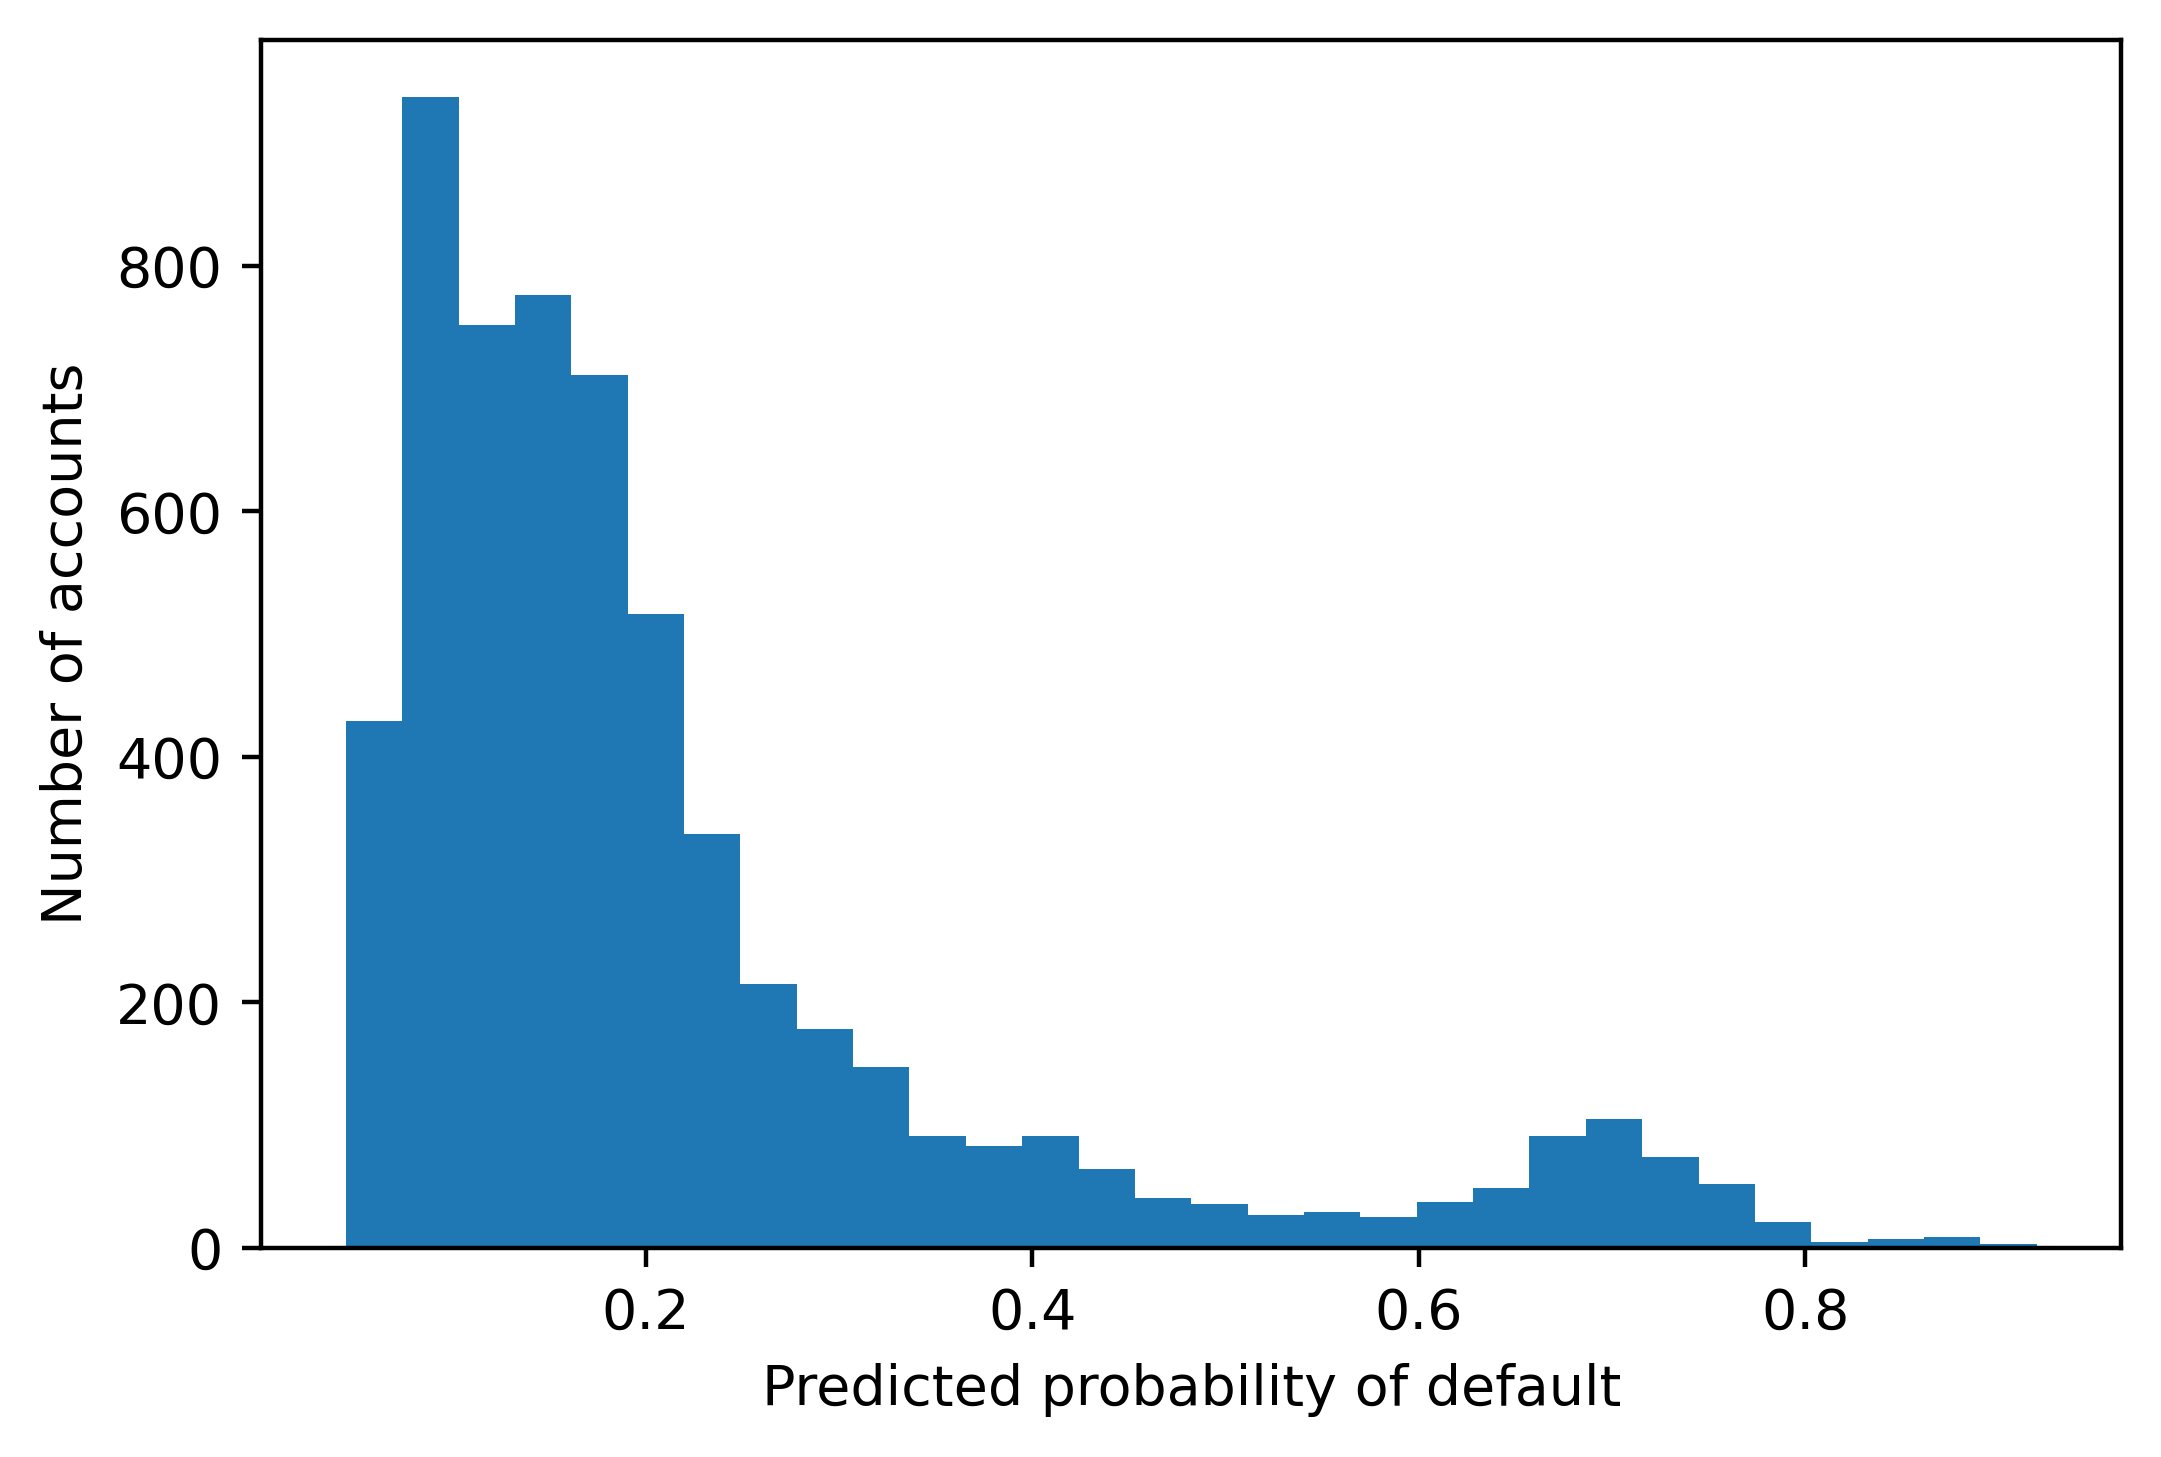

In [82]:
plt.hist(y_test_all_predict_proba[:,1], bins=30)
plt.xlabel('Predicted probability of default')
plt.ylabel('Number of accounts')

- If the shape of the histogram of predicted probabilities changes substantially, it may be a sign that the relationship between the features and response in the population of accounts has changed and the model may need to be re-trained or rebuilt. This may also become evident if the number of accounts predicted to default, according to a chosen threshold, changes in a noticeable way.

# summary

- Congratulations, you have now completed the project and are ready to deliver your findings to the client! Along with trained models saved to disk, or other data products or services you may provide to the client, you will probably also want to create a presentation, typically a slide show, detailing your progress. Contents of such presentations usually include a problem statement, results of data exploration and cleaning, a comparison of different models you built, any other necessary steps such as imputation, and the financial analysis which shows how valuable your work is. As you craft presentations of your work, it's usually better to tell your story with pictures as opposed to a lot of text. We've demonstrated many visualization techniques throughout the course that you can use to do this, and you should continue to explore ways to depict data and modeling results.
- Always be sure to ask the client which specific things they may want to see in a presentation and be sure to answer all their questions. When a client sees that you can create value for them in an understandable way, you have succeeded.

# Task - 7

Restart Kernal and crear the output to run below code

<b>Import the necessary packages</b>

In [84]:
import numpy as np #numerical computation
import pandas as pd #data wrangling
import matplotlib.pyplot as plt #plotting package
#Next line helps with rendering plots
%matplotlib inline
import matplotlib as mpl #add'l plotting functionality
mpl.rcParams['figure.dpi'] = 400 #high res figures
import graphviz #to visualize decision trees

<b>Cleaning the Dataset</b>

In [85]:
df_orig = pd.read_excel('default_of_credit_card_clients.xls')

In [86]:
df_zero_mask = df_orig == 0

In [87]:
feature_zero_mask = df_zero_mask.iloc[:,1:].all(axis=1)

In [88]:
sum(feature_zero_mask)
# 315

315

Remove all the rows with all zero features and response, confirm this that gets rid of the duplicate IDs.

In [89]:
df_clean = df_orig.loc[~feature_zero_mask,:].copy()

In [90]:
df_clean.shape
# (29685, 25)

(29685, 25)

In [91]:
df_clean['ID'].nunique()
# 29685

29685

Clean up the EDUCATION and MARRIAGE features as in Chapter 1

In [92]:
df_clean['EDUCATION'].value_counts()
# 2    13884
# 1    10474
# 3     4867
# 5      275
# 4      122
# 6       49
# 0       14
# Name: EDUCATION, dtype: int64

2    13884
1    10474
3     4867
5      275
4      122
6       49
0       14
Name: EDUCATION, dtype: int64

"Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)"

Assign unknown categories to other.

In [93]:
df_clean['EDUCATION'].replace(to_replace=[0, 5, 6], value=4, inplace=True)

In [94]:
df_clean['EDUCATION'].value_counts()
# 2    13884
# 1    10474
# 3     4867
# 4      460
# Name: EDUCATION, dtype: int64

2    13884
1    10474
3     4867
4      460
Name: EDUCATION, dtype: int64

Examine and clean marriage feature as well:

In [95]:
df_clean['MARRIAGE'].value_counts()
# 2    15810
# 1    13503
# 3      318
# 0       54
# Name: MARRIAGE, dtype: int64

2    15810
1    13503
3      318
0       54
Name: MARRIAGE, dtype: int64

In [96]:
#Should only be (1 = married; 2 = single; 3 = others).
df_clean['MARRIAGE'].replace(to_replace=0, value=3, inplace=True)

In [97]:
df_clean['MARRIAGE'].value_counts()
# 2    15810
# 1    13503
# 3      372
# Name: MARRIAGE, dtype: int64

2    15810
1    13503
3      372
Name: MARRIAGE, dtype: int64

Now instead of removing rows with PAY_1 = 'Not available', as done in Chapter 1, here select these out for addition to training and testing splits.

In [98]:
df_clean['PAY_1'].value_counts()
# 0                13087
# -1                5047
# 1                 3261
# Not available     3021
# -2                2476
# 2                 2378
# 3                  292
# 4                   63
# 5                   23
# 8                   17
# 6                   11
# 7                    9
# Name: PAY_1, dtype: int64

0                13087
-1                5047
1                 3261
Not available     3021
-2                2476
2                 2378
3                  292
4                   63
5                   23
8                   17
6                   11
7                    9
Name: PAY_1, dtype: int64

In [99]:
missing_pay_1_mask = df_clean['PAY_1'] == 'Not available'

In [100]:
sum(missing_pay_1_mask)
# 3021

3021

In [101]:
df_missing_pay_1 = df_clean.loc[missing_pay_1_mask,:].copy()

In [102]:
df_missing_pay_1.shape
# (3021, 25)

(3021, 25)

In [103]:
df_missing_pay_1['PAY_1'].head(3)

17    Not available
28    Not available
29    Not available
Name: PAY_1, dtype: object

In [104]:
df_missing_pay_1['PAY_1'].value_counts()

Not available    3021
Name: PAY_1, dtype: int64

In [105]:
df_missing_pay_1.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

Load cleaned data

In [106]:
df = pd.read_csv('cleaned_data.csv')

In [107]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'EDUCATION_CAT', 'graduate school',
       'high school', 'others', 'university'],
      dtype='object')

In [108]:
features_response = df.columns.tolist()

In [109]:
items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'EDUCATION_CAT', 'graduate school', 'high school', 'none',
                   'others', 'university']

In [110]:
features_response = [item for item in features_response if item not in items_to_remove]
features_response

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

<b>Mode and Random Imputation of PAY_1</b>

In [111]:
from sklearn.model_selection import train_test_split

In [112]:
X_train, X_test, y_train, y_test = \
train_test_split(df[features_response[:-1]].values, df['default payment next month'].values,
test_size=0.2, random_state=24)

In [115]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
# (21331, 17)
# (5333, 17)
# (21331,)
# (5333,)

(21331, 17)
(5333, 17)
(21331,)
(5333,)


In [116]:
df_missing_pay_1.shape

(3021, 25)

In [117]:
features_response[4]

'PAY_1'

In [118]:
np.median(X_train[:,4])

0.0

In [119]:
np.random.seed(seed=1)
fill_values = [0, np.random.choice(X_train[:,4], size=(3021,), replace=True)]

In [120]:
fill_strategy = ['mode', 'random']

In [121]:
fill_values[-1]

array([ 0,  0,  0, ...,  2,  0, -2], dtype=int64)

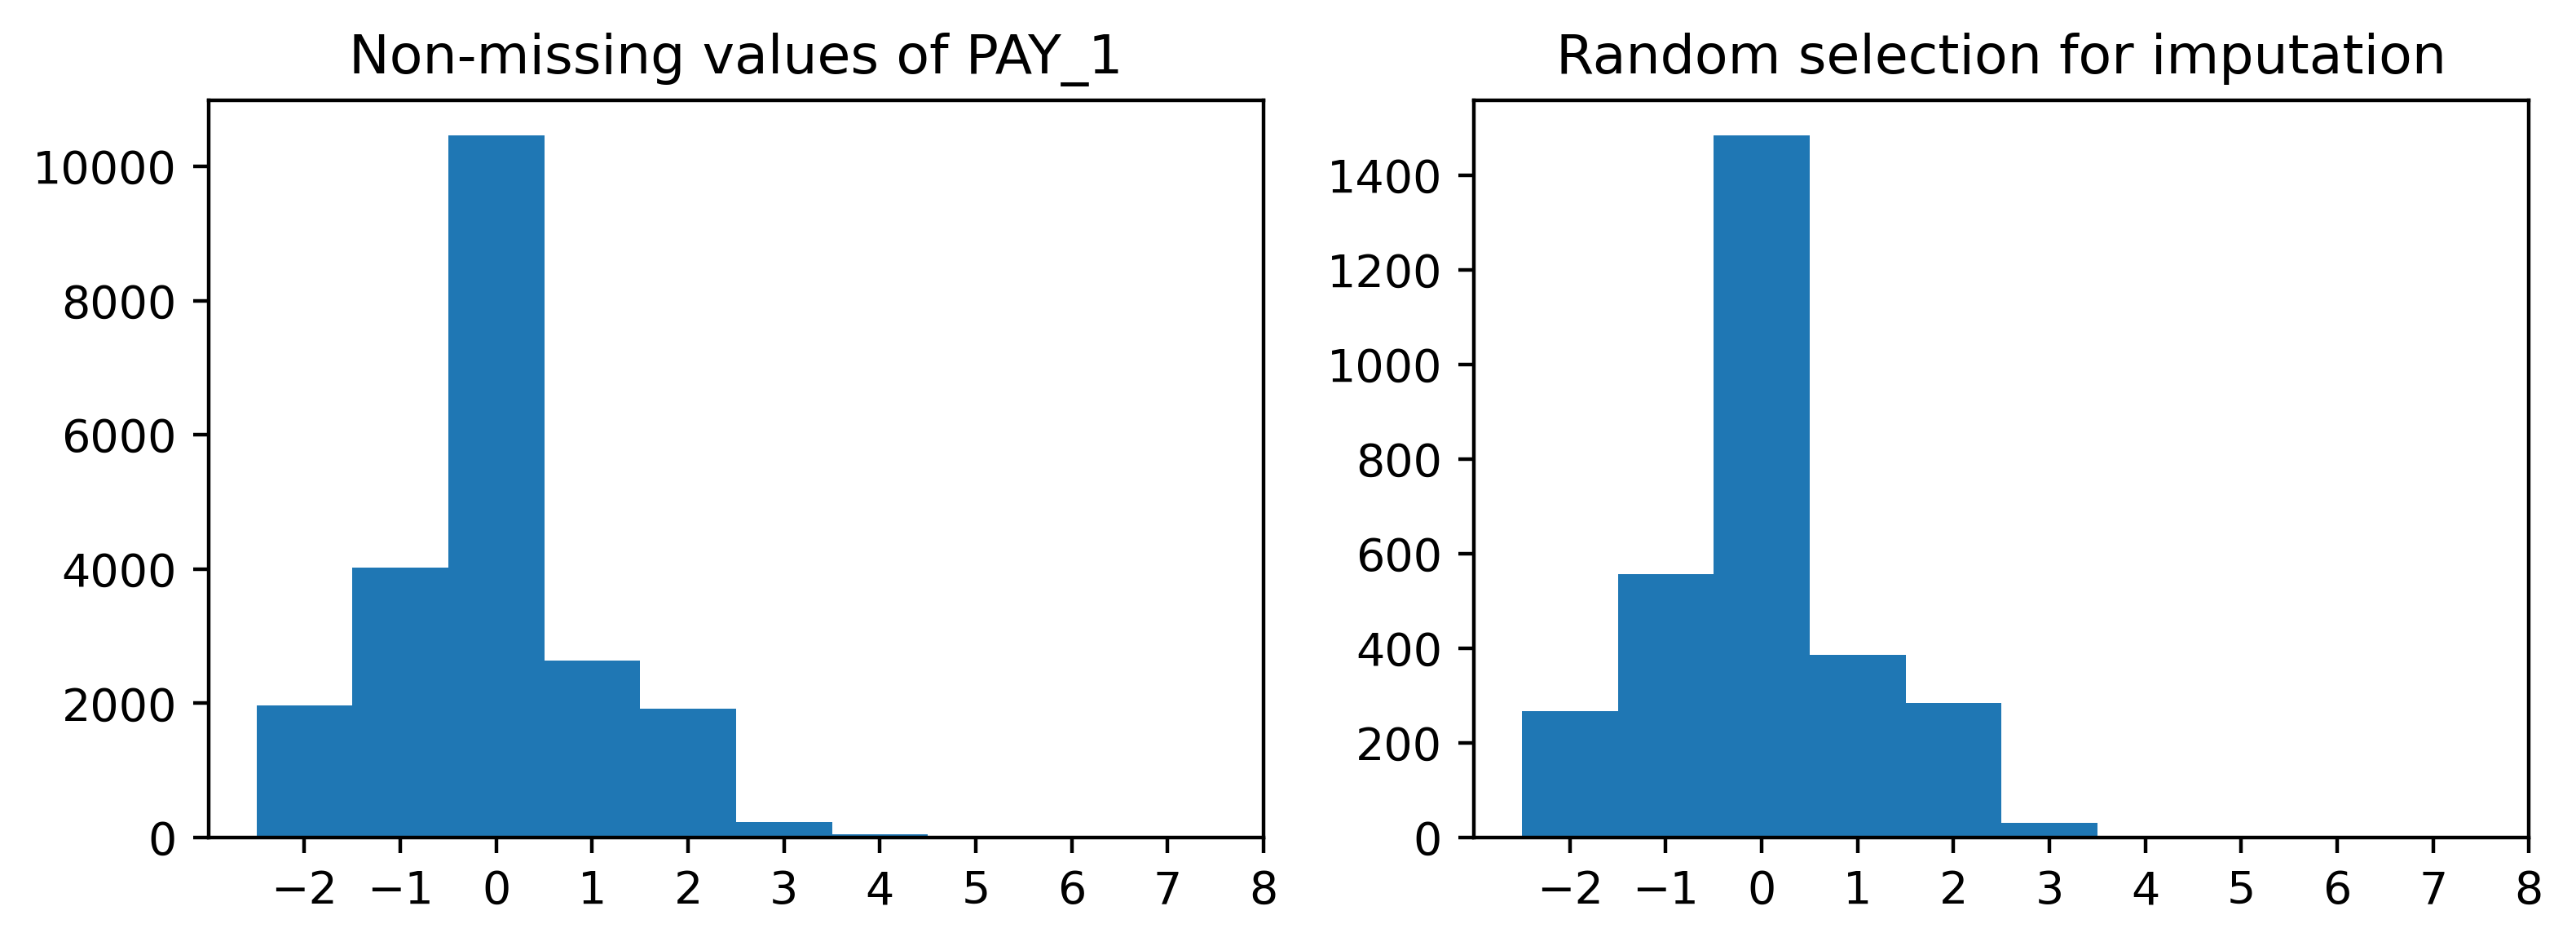

In [122]:
fig, axs = plt.subplots(1,2, figsize=(8,3))
bin_edges = np.arange(-2,9)
axs[0].hist(X_train[:,4], bins=bin_edges, align='left')
axs[0].set_xticks(bin_edges)
axs[0].set_title('Non-missing values of PAY_1')
axs[1].hist(fill_values[-1], bins=bin_edges, align='left')
axs[1].set_xticks(bin_edges)
axs[1].set_title('Random selection for imputation')
plt.tight_layout()

To do cross-validation on the training set, now we need to shuffle since all the samples with missing PAY_1 were concatenated on to the end

In [123]:
from sklearn.model_selection import KFold

In [124]:
k_folds = KFold(n_splits=4, shuffle=True, random_state=1)

Don't need to do a grid search, so we can use cross_validate

In [125]:
from sklearn.model_selection import cross_validate

For the estimator, set the optimal hyperparameters determined in previous chapter.

In [126]:
from sklearn.ensemble import RandomForestClassifier

In [127]:
rf = RandomForestClassifier\
(n_estimators=200, criterion='gini', max_depth=9,
min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None,
random_state=4, verbose=1, warm_start=False, class_weight=None)

In [128]:
for counter in range(len(fill_values)):
    #Copy the data frame with missing PAY_1 and assign imputed values
    df_fill_pay_1_filled = df_missing_pay_1.copy()
    df_fill_pay_1_filled['PAY_1'] = fill_values[counter]
    
    #Split imputed data in to training and testing, using the same
    #80/20 split we have used for the data with non-missing PAY_1
    X_fill_pay_1_train, X_fill_pay_1_test, y_fill_pay_1_train, y_fill_pay_1_test = \
    train_test_split(
        df_fill_pay_1_filled[features_response[:-1]].values,
        df_fill_pay_1_filled['default payment next month'].values,
    test_size=0.2, random_state=24)
    
    #Concatenate the imputed data with the array of non-missing data
    X_train_all = np.concatenate((X_train, X_fill_pay_1_train), axis=0)
    y_train_all = np.concatenate((y_train, y_fill_pay_1_train), axis=0)
    
    #Use the KFolds splitter and the random forest model to get
    #4-fold cross-validation scores for both imputation methods
    imputation_compare_cv = cross_validate(rf, X_train_all, y_train_all, scoring='roc_auc',
                                       cv=k_folds, n_jobs=-1, verbose=1,
                                       return_train_score=True, return_estimator=True,
                                       error_score='raise-deprecating')
    
    test_score = imputation_compare_cv['test_score']
    print(fill_strategy[counter] + ' imputation: ' +
          'mean testing score ' + str(np.mean(test_score)) +
          ', std ' + str(np.std(test_score)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   23.3s remaining:   23.3s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   23.4s finished


mode imputation: mean testing score 0.772866246168149, std 0.0031479941297533737


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


random imputation: mean testing score 0.7692540439833129, std 0.003660875187678248


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   21.0s remaining:   21.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   21.1s finished


<b>A Predictive Model for PAY_1</b>

In [129]:
pay_1_df = df.copy()

In [130]:
features_for_imputation = pay_1_df.columns.tolist()

In [131]:
items_to_remove_2 = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'EDUCATION_CAT', 'graduate school', 'high school', 'none',
                   'others', 'university', 'default payment next month', 'PAY_1']

In [132]:
features_for_imputation = [item for item in features_for_imputation if item not in items_to_remove_2]
features_for_imputation

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

<b>Building a Multiclass Classification Model for Imputation</b>

In [133]:
X_impute_train, X_impute_test, y_impute_train, y_impute_test = \
train_test_split(
    pay_1_df[features_for_imputation].values,
    pay_1_df['PAY_1'].values,
test_size=0.2, random_state=24)

In [134]:
rf_impute_params = {'max_depth':[3, 6, 9, 12],
             'n_estimators':[10, 50, 100, 200]}

In [135]:
from sklearn.model_selection import GridSearchCV

Need to use accuracy here as ROC AUC is not supported for multiclass. Need to use multiclass and not regression because need to limit to integer values of PAY_1.

In [136]:
cv_rf_impute = GridSearchCV(rf, param_grid=rf_impute_params, scoring='accuracy',
                            n_jobs=-1, iid=False, refit=True,
                            cv=4, verbose=2, error_score=np.nan, return_train_score=True)

In [137]:
cv_rf_impute.fit(X_impute_train, y_impute_train)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:  2.2min finished
C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   21.3s finished


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_depth=9, n_estimators=200,
                                              random_state=4, verbose=1),
             iid=False, n_jobs=-1,
             param_grid={'max_depth': [3, 6, 9, 12],
                         'n_estimators': [10, 50, 100, 200]},
             return_train_score=True, scoring='accuracy', verbose=2)

In [138]:
impute_df = pd.DataFrame(cv_rf_impute.cv_results_)
impute_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.395696,0.010165,0.014292,0.003500,3,10,"{'max_depth': 3, 'n_estimators': 10}",0.664729,0.669417,0.671479,0.664291,0.667479,0.003061,15,0.669396,0.670146,0.665146,0.670042,0.668682,0.002062
1,2.121474,0.041308,0.092163,0.013433,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.657979,0.660229,0.660604,0.651350,0.657540,0.003712,16,0.664521,0.657145,0.654082,0.660854,0.659150,0.003920
2,4.010039,0.045804,0.155450,0.007201,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.672605,0.673542,0.675792,0.667854,0.672448,0.002894,13,0.677835,0.675147,0.670521,0.676167,0.674918,0.002713
3,8.187933,0.059826,0.324678,0.022757,3,200,"{'max_depth': 3, 'n_estimators': 200}",0.664917,0.666042,0.675792,0.666354,0.668276,0.004372,14,0.672334,0.668896,0.669021,0.672605,0.670714,0.001758
4,0.687864,0.014872,0.018277,0.008013,6,10,"{'max_depth': 6, 'n_estimators': 10}",0.710294,0.706919,0.713482,0.700675,0.707843,0.004744,12,0.717027,0.717027,0.718465,0.711607,0.716032,0.002621
5,3.336491,0.069815,0.093074,0.002349,6,50,"{'max_depth': 6, 'n_estimators': 50}",0.708419,0.709732,0.713107,0.703863,0.708780,0.003314,11,0.716652,0.716090,0.719777,0.715982,0.717125,0.001552
6,7.062857,0.103069,0.183490,0.015318,6,100,"{'max_depth': 6, 'n_estimators': 100}",0.709544,0.709544,0.714420,0.705926,0.709859,0.003019,10,0.718777,0.716777,0.719152,0.718420,0.718282,0.000906
7,14.313547,0.150511,0.369759,0.019689,6,200,"{'max_depth': 6, 'n_estimators': 200}",0.710669,0.709357,0.715170,0.705551,0.710187,0.003436,9,0.719152,0.717652,0.719715,0.718107,0.718657,0.000818
8,0.966386,0.031776,0.030519,0.004370,9,10,"{'max_depth': 9, 'n_estimators': 10}",0.719670,0.725858,0.721920,0.720743,0.722048,0.002339,7,0.767721,0.773722,0.767221,0.771611,0.770069,0.002709
9,4.679735,0.045749,0.121971,0.005803,9,50,"{'max_depth': 9, 'n_estimators': 50}",0.726608,0.728296,0.725858,0.731808,0.728142,0.002293,6,0.770284,0.774347,0.771471,0.770611,0.771678,0.001601


In [139]:
cv_rf_impute.best_params_
# {'max_depth': 12, 'n_estimators': 100}

{'max_depth': 12, 'n_estimators': 200}

In [140]:
cv_rf_impute.best_score_
# 0.7337676389523727

0.7344242187492307

In [141]:
pay_1_value_counts = pay_1_df['PAY_1'].value_counts().sort_index()

In [142]:
pay_1_value_counts

-2     2476
-1     5047
 0    13087
 1     3261
 2     2378
 3      292
 4       63
 5       23
 6       11
 7        9
 8       17
Name: PAY_1, dtype: int64

In [143]:
pay_1_value_counts/pay_1_value_counts.sum()

-2    0.092859
-1    0.189281
 0    0.490812
 1    0.122300
 2    0.089184
 3    0.010951
 4    0.002363
 5    0.000863
 6    0.000413
 7    0.000338
 8    0.000638
Name: PAY_1, dtype: float64

In [144]:
y_impute_predict = cv_rf_impute.predict(X_impute_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.3s finished


In [145]:
from sklearn import metrics

In [146]:
metrics.accuracy_score(y_impute_test, y_impute_predict)

0.7391711981998875

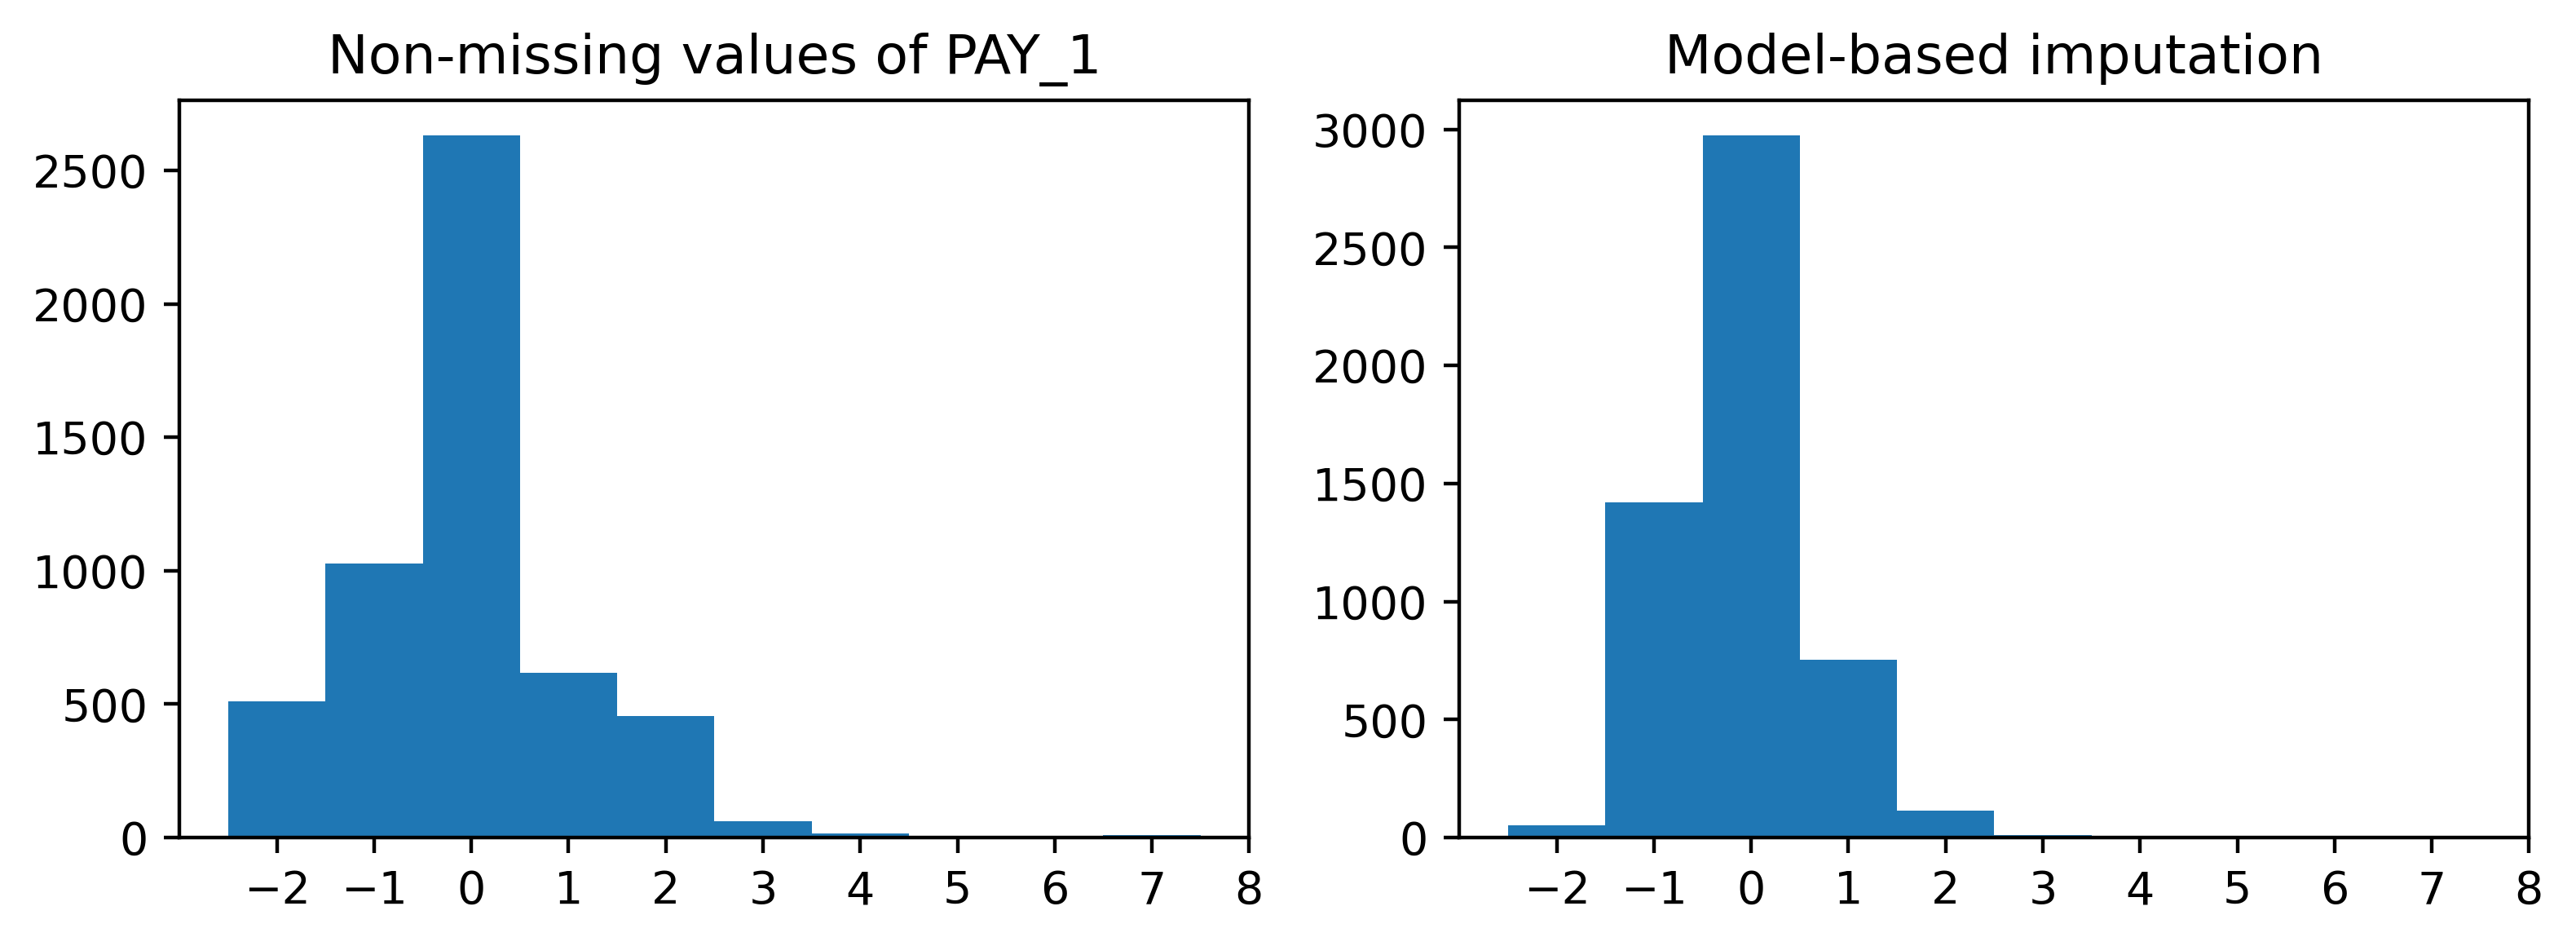

In [147]:
fig, axs = plt.subplots(1,2, figsize=(8,3))
axs[0].hist(y_impute_test, bins=bin_edges, align='left')
axs[0].set_xticks(bin_edges)
axs[0].set_title('Non-missing values of PAY_1')
axs[1].hist(y_impute_predict, bins=bin_edges, align='left')
axs[1].set_xticks(bin_edges)
axs[1].set_title('Model-based imputation')
plt.tight_layout()

In [148]:
X_impute_all = pay_1_df[features_for_imputation].values
y_impute_all = pay_1_df['PAY_1'].values

In [149]:
rf_impute = RandomForestClassifier(n_estimators=100, max_depth=12)

In [150]:
rf_impute

RandomForestClassifier(max_depth=12)

In [151]:
rf_impute.fit(X_impute_all, y_impute_all)

RandomForestClassifier(max_depth=12)

<b>Using the Imputation Model and Comparing it to Other Methods</b>

In [153]:
df_fill_pay_1_model = df_missing_pay_1.copy()

In [154]:
df_fill_pay_1_model['PAY_1'].head()

17    Not available
28    Not available
29    Not available
54    Not available
60    Not available
Name: PAY_1, dtype: object

In [155]:
df_fill_pay_1_model['PAY_1'] = rf_impute.predict(df_fill_pay_1_model[features_for_imputation].values)

In [156]:
df_fill_pay_1_model['PAY_1'].head()

17    0
28   -1
29    0
54    0
60    0
Name: PAY_1, dtype: int64

In [157]:
df_fill_pay_1_model['PAY_1'].value_counts().sort_index()

-2      30
-1     763
 0    1715
 1     438
 2      64
 3       7
 4       2
 6       1
 8       1
Name: PAY_1, dtype: int64

In [158]:
X_fill_pay_1_train, X_fill_pay_1_test, y_fill_pay_1_train, y_fill_pay_1_test = \
train_test_split(
    df_fill_pay_1_model[features_response[:-1]].values,
    df_fill_pay_1_model['default payment next month'].values,
test_size=0.2, random_state=24)

In [159]:
print(X_fill_pay_1_train.shape)
print(X_fill_pay_1_test.shape)
print(y_fill_pay_1_train.shape)
print(y_fill_pay_1_test.shape)

(2416, 17)
(605, 17)
(2416,)
(605,)


In [160]:
X_train_all = np.concatenate((X_train, X_fill_pay_1_train), axis=0)
y_train_all = np.concatenate((y_train, y_fill_pay_1_train), axis=0)

In [161]:
print(X_train_all.shape)
print(y_train_all.shape)

(23747, 17)
(23747,)


In [162]:
rf

RandomForestClassifier(max_depth=9, n_estimators=200, random_state=4, verbose=1)

In [163]:
imputation_compare_cv = cross_validate(rf, X_train_all, y_train_all, scoring='roc_auc',
                                       cv=k_folds, n_jobs=-1, verbose=1,
                                       return_train_score=True, return_estimator=True,
                                       error_score='raise-deprecating')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   24.3s remaining:   24.3s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   24.6s finished


In [164]:
imputation_compare_cv['test_score']
# array([0.76890992, 0.77309591, 0.77166336, 0.77703366])

array([0.76890992, 0.77309591, 0.77166336, 0.77703366])

In [165]:
np.mean(imputation_compare_cv['test_score'])
# 0.7726757126815554

0.7726757126815554

In [166]:
np.std(imputation_compare_cv['test_score'])
# 0.002931480680760725

0.002931480680760725

Reassign values using mode imputation

In [167]:
df_fill_pay_1_model['PAY_1'] = np.zeros_like(df_fill_pay_1_model['PAY_1'].values)

In [168]:
df_fill_pay_1_model['PAY_1'].unique()

array([0], dtype=int64)

In [169]:
X_fill_pay_1_train, X_fill_pay_1_test, y_fill_pay_1_train, y_fill_pay_1_test = \
train_test_split(
    df_fill_pay_1_model[features_response[:-1]].values,
    df_fill_pay_1_model['default payment next month'].values,
test_size=0.2, random_state=24)

In [170]:
X_train_all = np.concatenate((X_train, X_fill_pay_1_train), axis=0)
X_test_all = np.concatenate((X_test, X_fill_pay_1_test), axis=0)
y_train_all = np.concatenate((y_train, y_fill_pay_1_train), axis=0)
y_test_all = np.concatenate((y_test, y_fill_pay_1_test), axis=0)

In [171]:
print(X_train_all.shape)
print(X_test_all.shape)
print(y_train_all.shape)
print(y_test_all.shape)

(23747, 17)
(5938, 17)
(23747,)
(5938,)


In [172]:
imputation_compare_cv = cross_validate(rf, X_train_all, y_train_all, scoring='roc_auc',
                                       cv=k_folds, n_jobs=-1, verbose=1,
                                       return_train_score=True, return_estimator=True,
                                       error_score='raise-deprecating')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   21.4s remaining:   21.4s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   21.5s finished


In [173]:
np.mean(imputation_compare_cv['test_score'])

0.772866246168149

<b>Confirming Model Performance on the Unseen Test Set </b>

In [174]:
thresholds = np.linspace(0, 1, 101)

Use mean bill amount to estimate savings per prevented default

In [175]:
df[features_response[:-1]].columns[5]

'BILL_AMT1'

In [176]:
savings_per_default = np.mean(X_test_all[:, 5])
savings_per_default
# 51601.7433479286

51601.7433479286

In [177]:
cost_per_counseling = 7500

In [178]:
effectiveness = 0.70

In [179]:
n_pos_pred = np.empty_like(thresholds)
cost_of_all_counselings = np.empty_like(thresholds)
n_true_pos = np.empty_like(thresholds)
savings_of_all_counselings = np.empty_like(thresholds)

In [180]:
counter = 0
for threshold in thresholds:
    pos_pred = y_test_all_predict_proba[:,1]>threshold
    n_pos_pred[counter] = sum(pos_pred)
    cost_of_all_counselings[counter] = n_pos_pred[counter] * cost_per_counseling
    true_pos = pos_pred & y_test_all.astype(bool)
    n_true_pos[counter] = sum(true_pos)
    savings_of_all_counselings[counter] = n_true_pos[counter] * savings_per_default * effectiveness
    
    counter += 1

In [181]:
net_savings = savings_of_all_counselings - cost_of_all_counselings

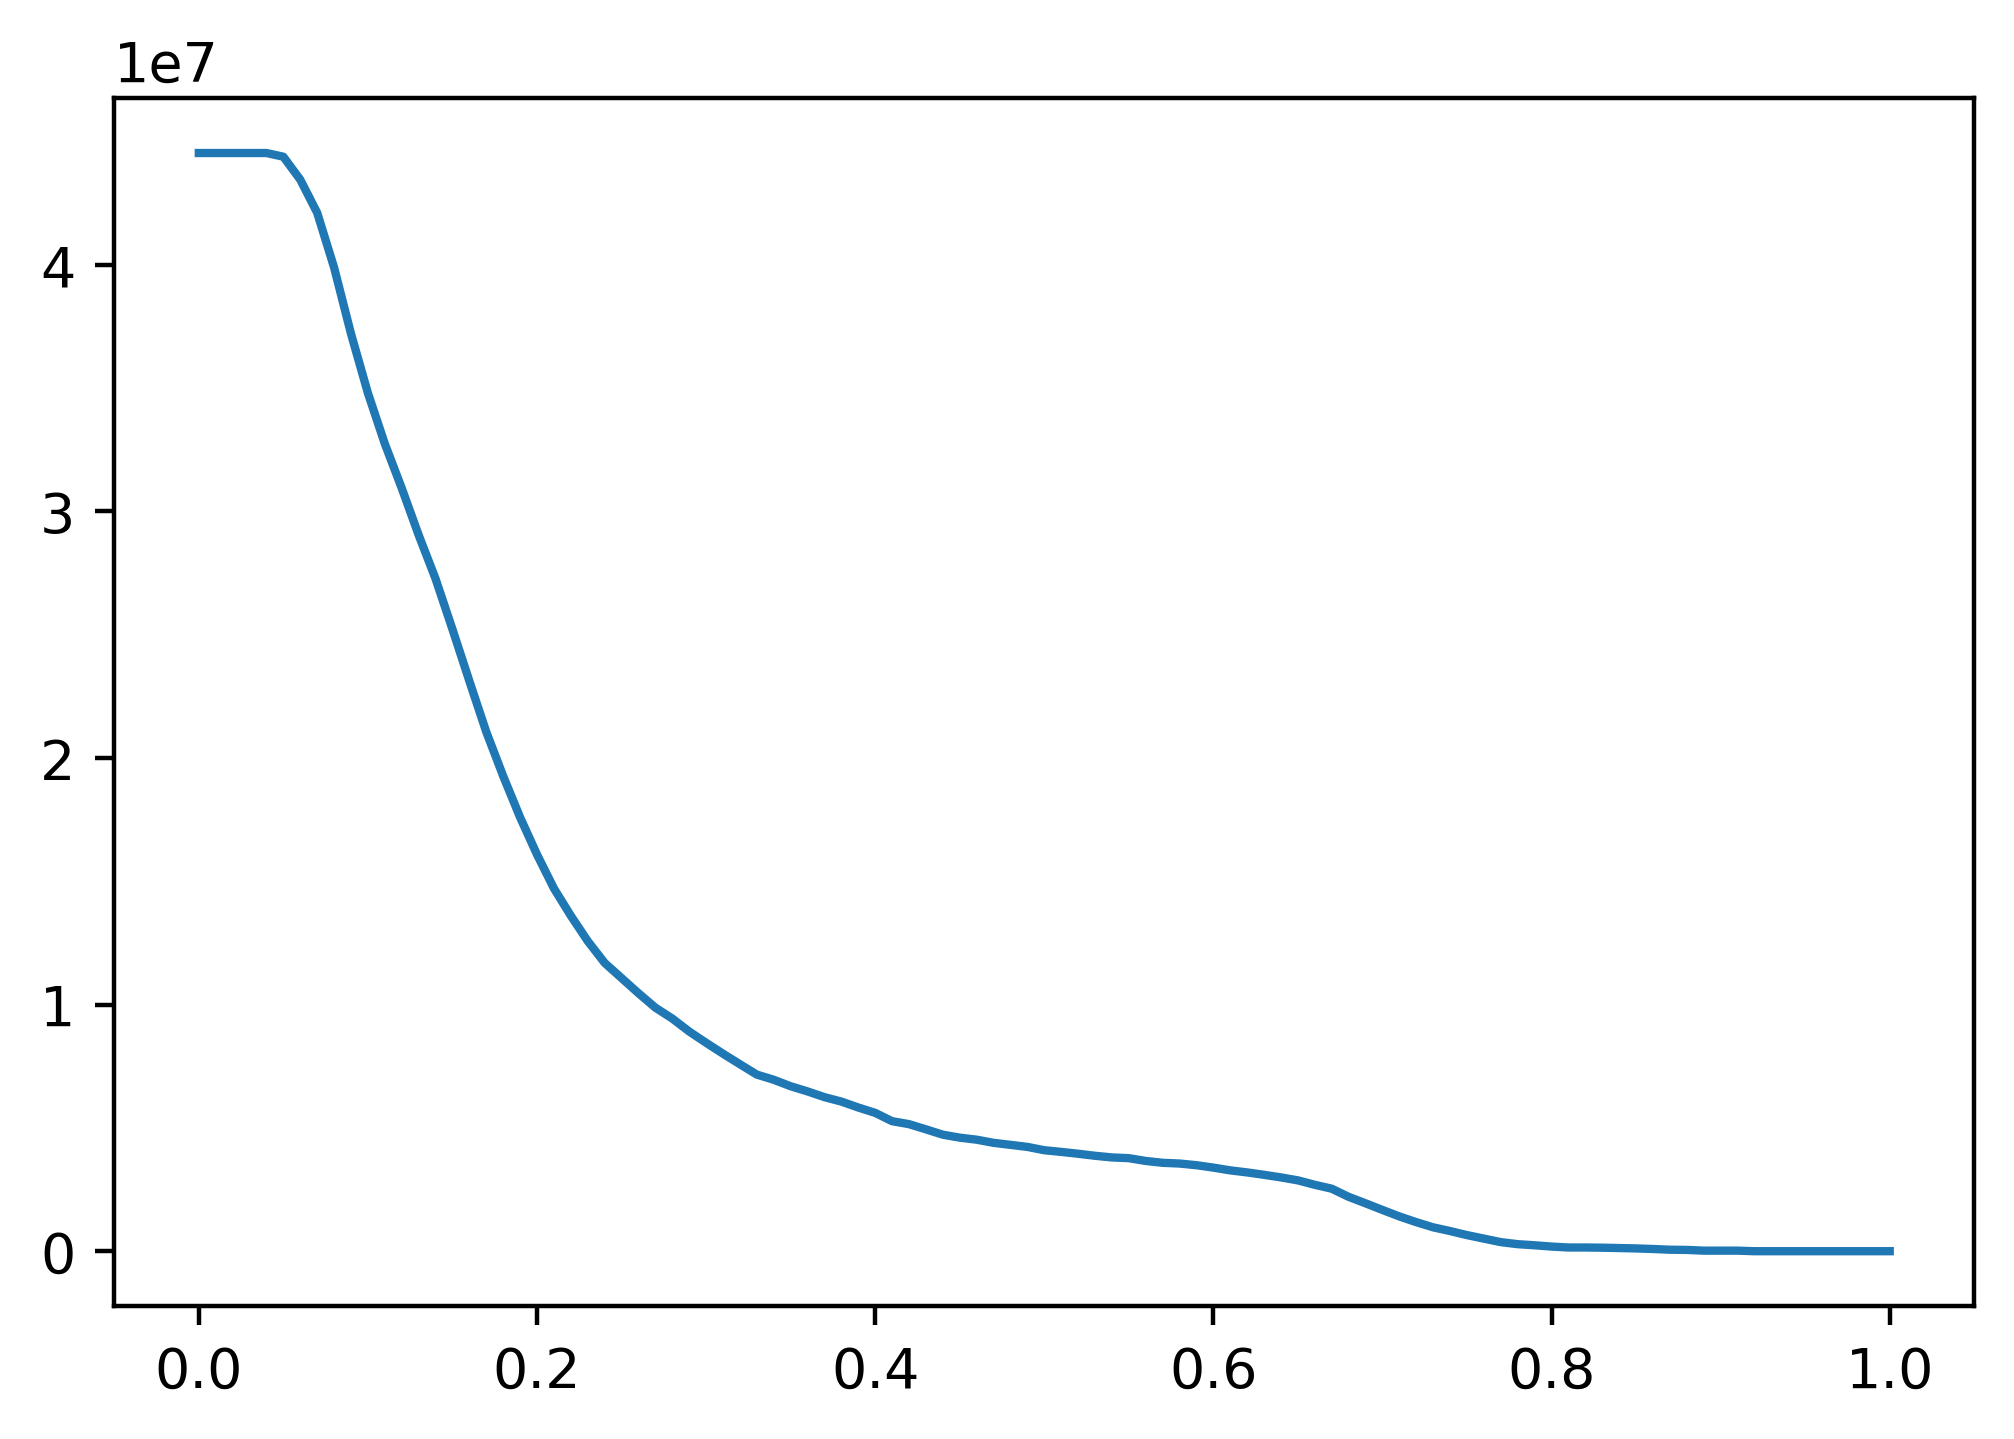

In [182]:
plt.plot(thresholds, cost_of_all_counselings)

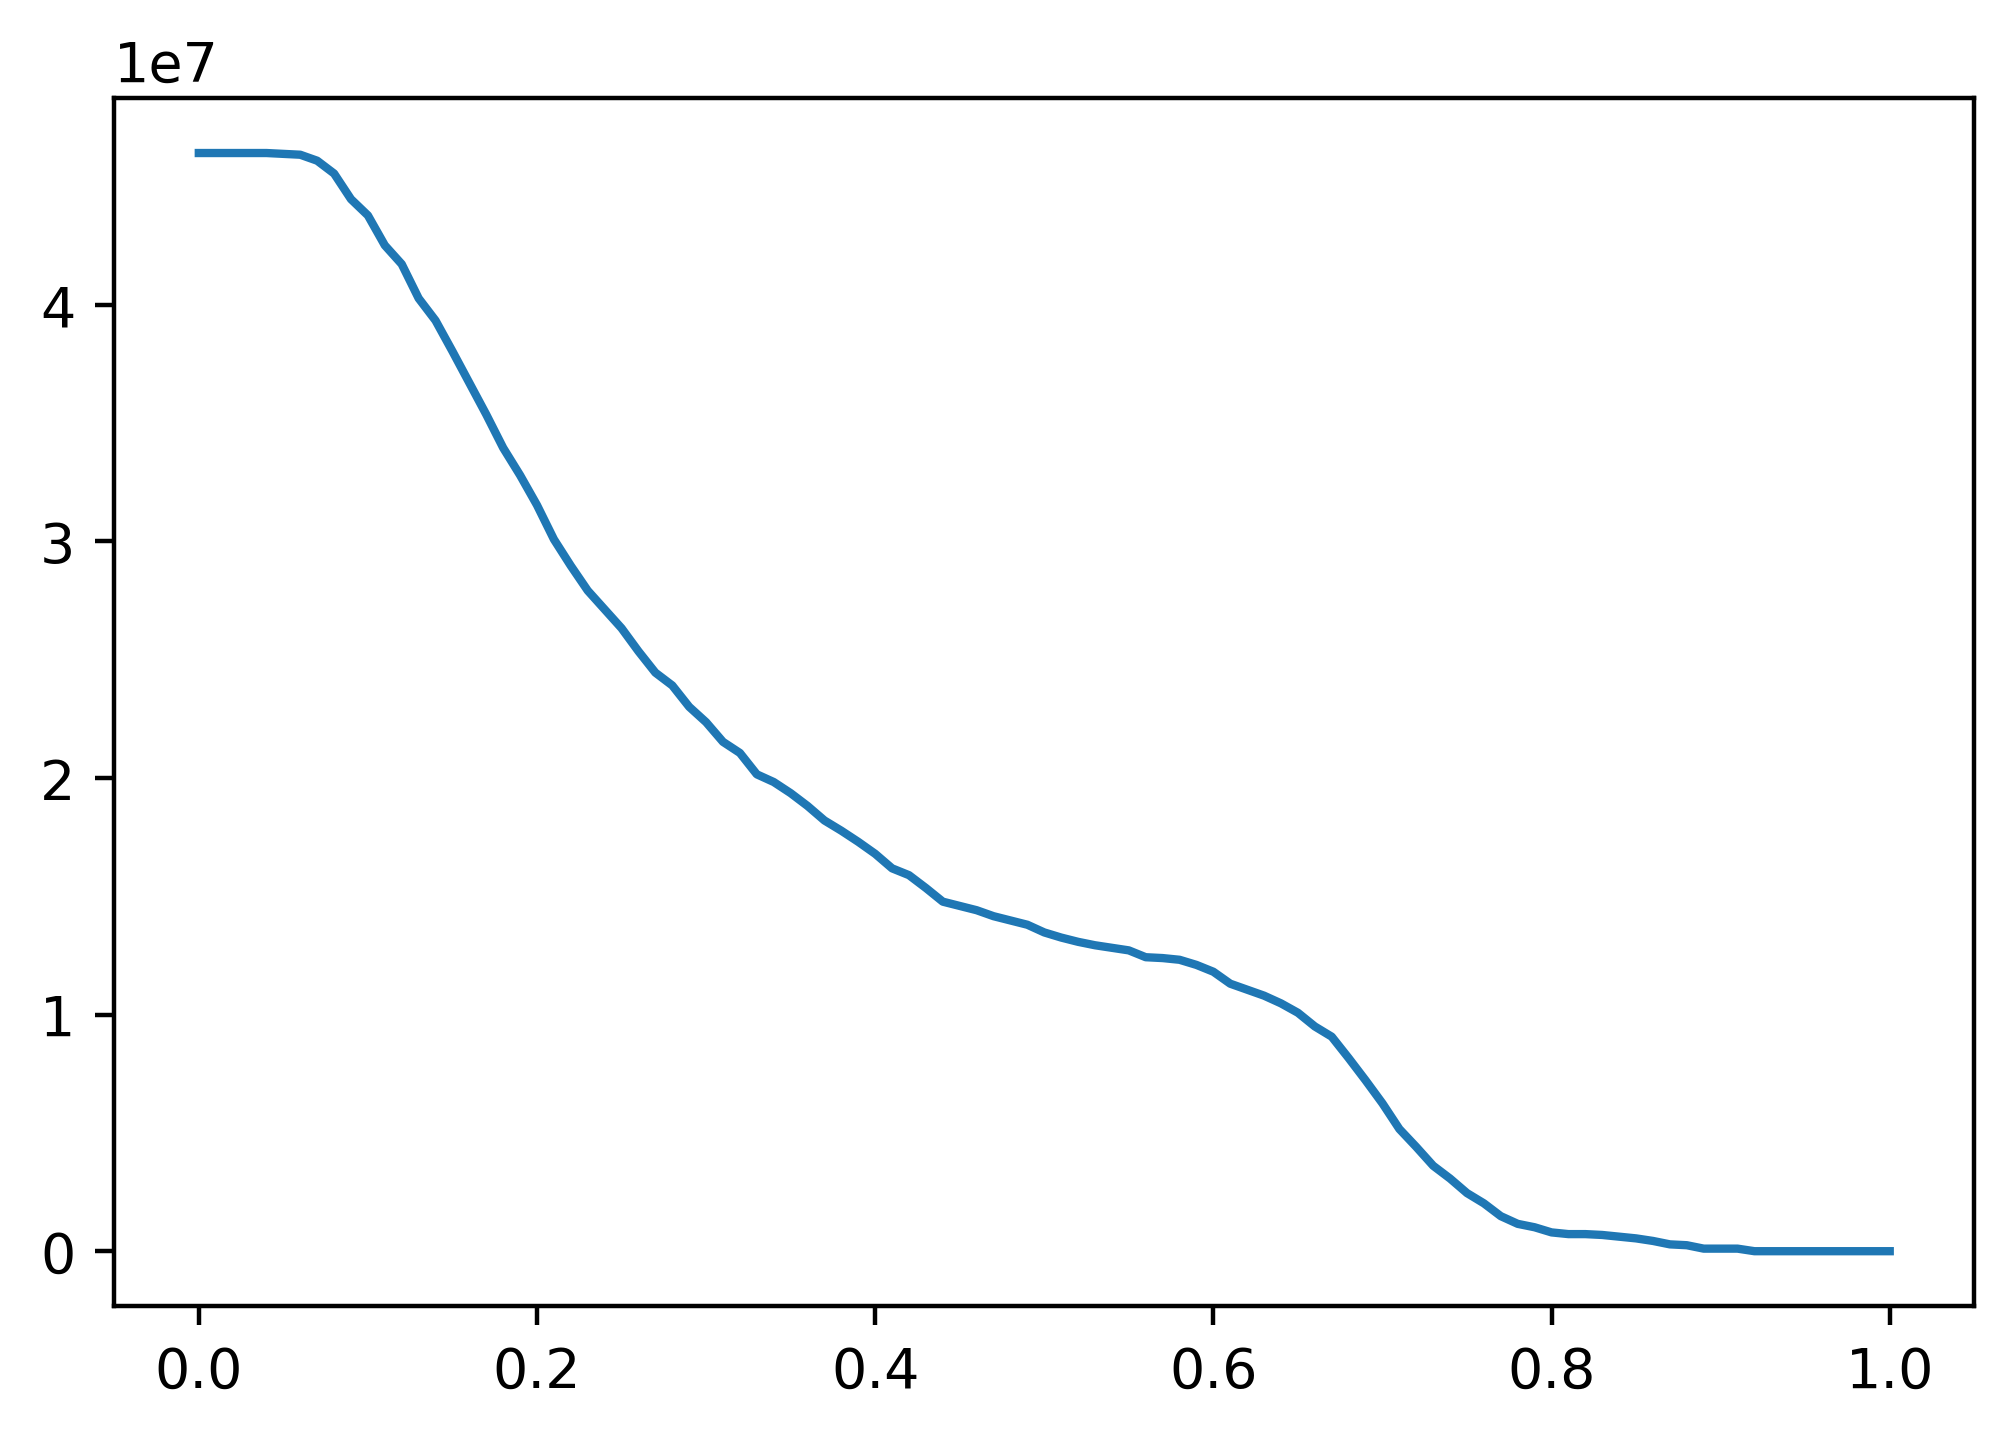

In [183]:
plt.plot(thresholds, savings_of_all_counselings)

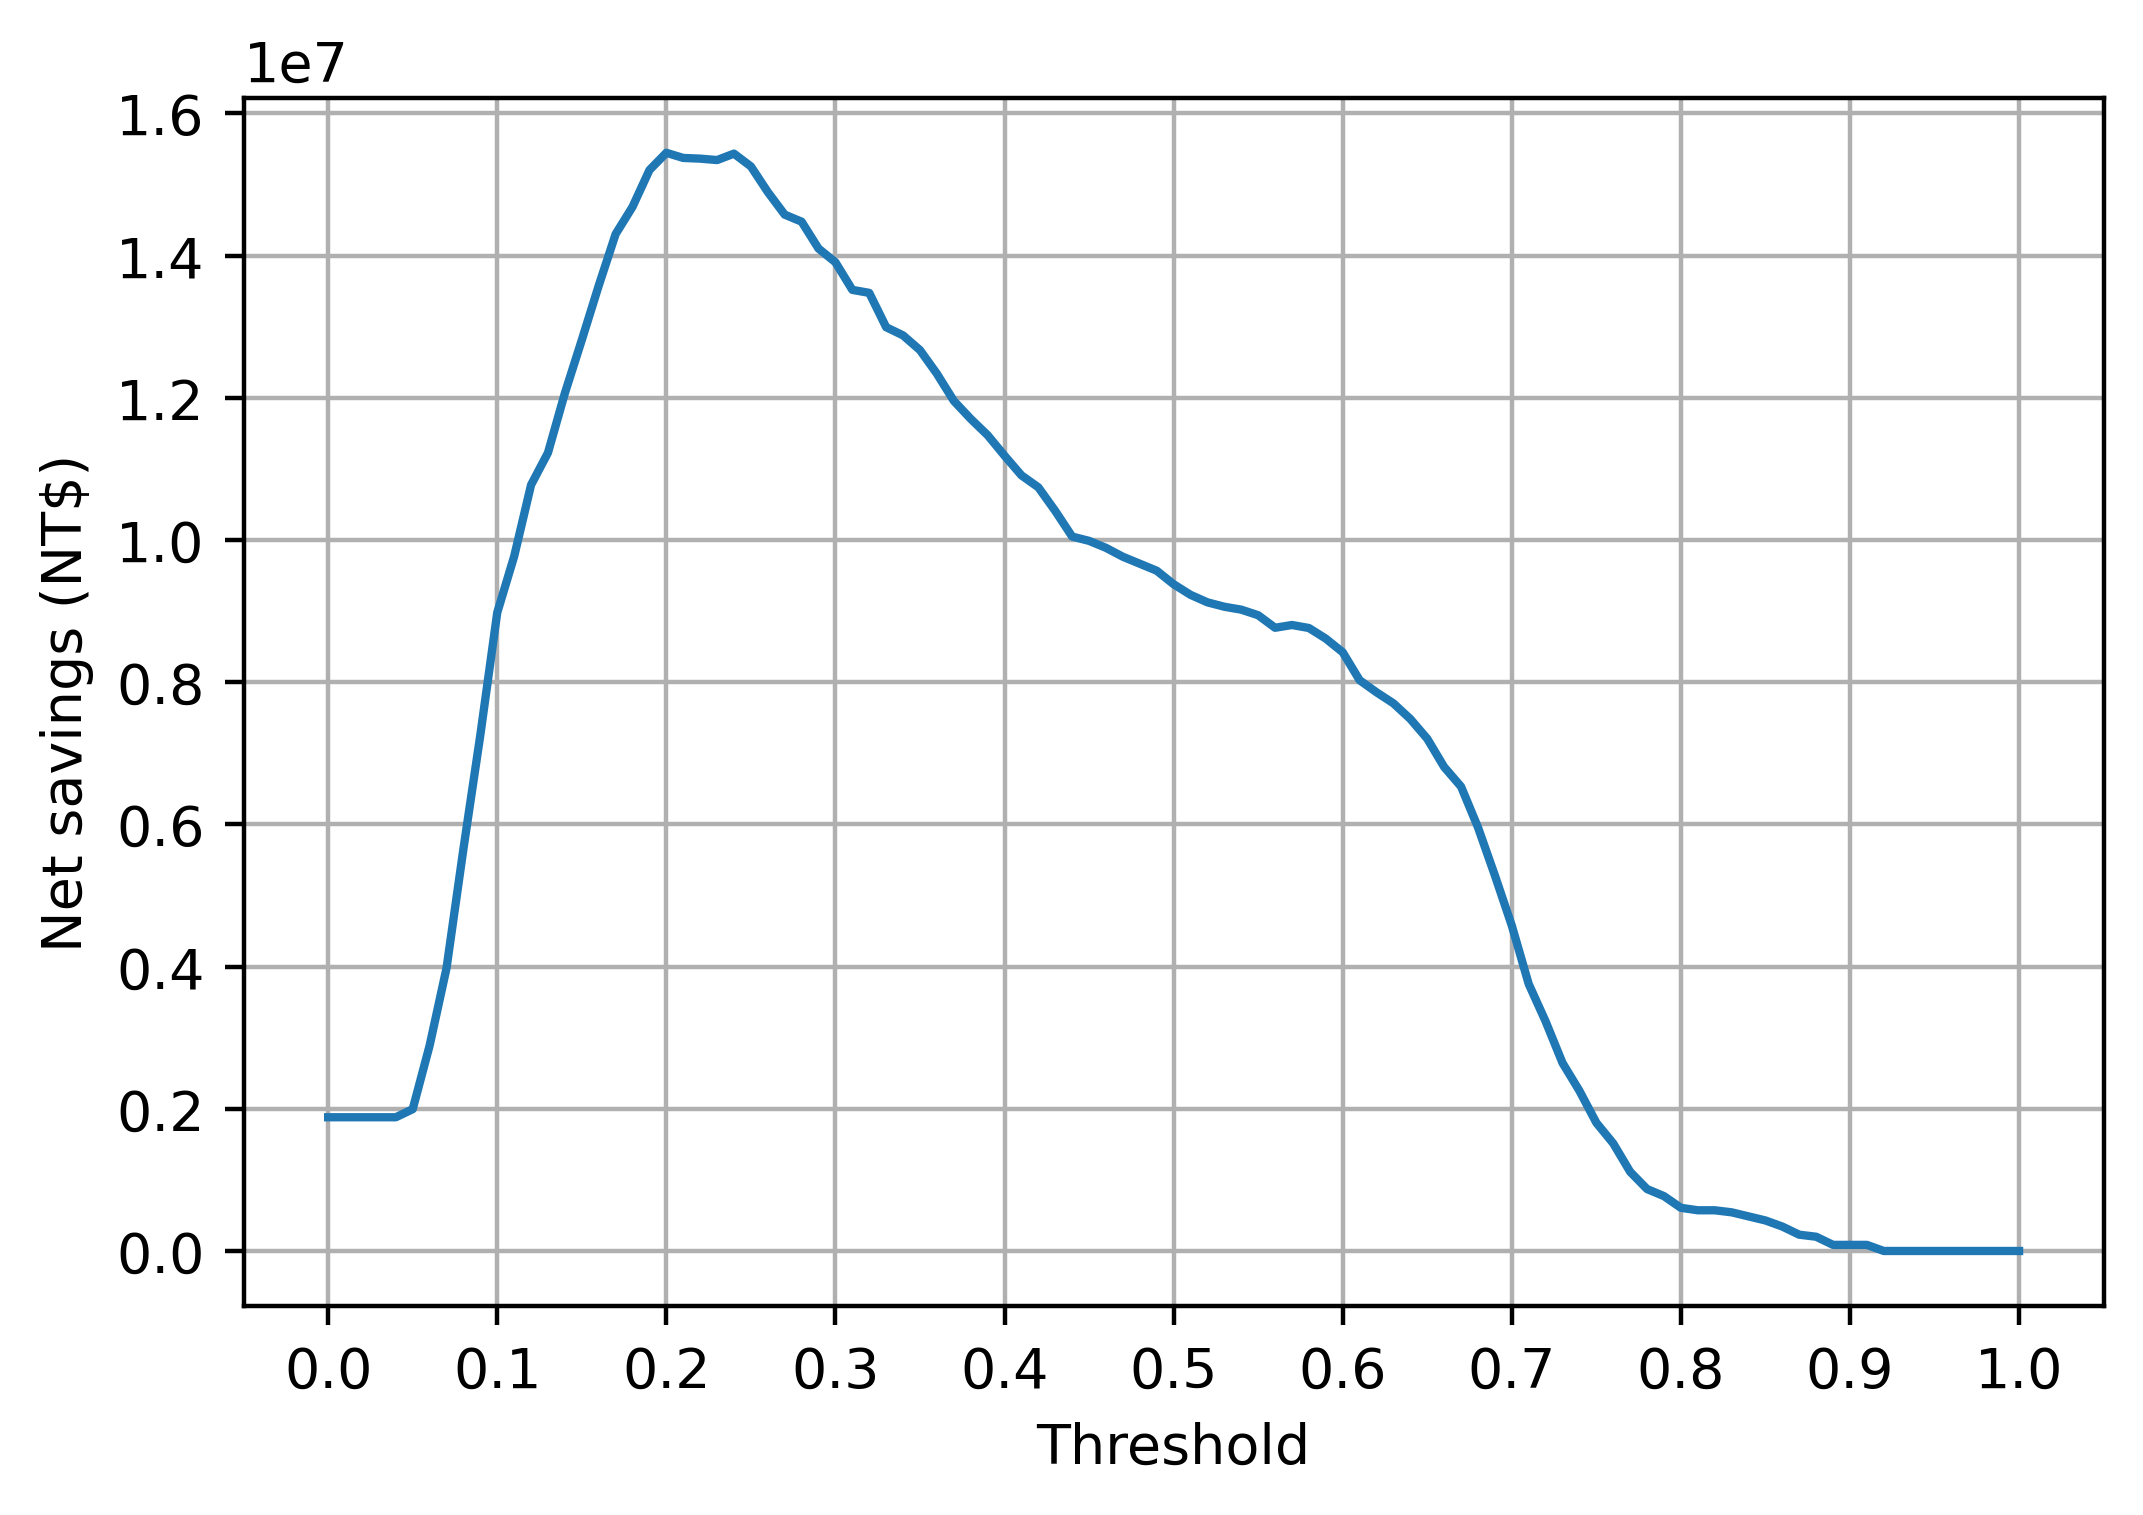

In [184]:
mpl.rcParams['figure.dpi'] = 400
plt.plot(thresholds, net_savings)
plt.xlabel('Threshold')
plt.ylabel('Net savings (NT$)')
plt.xticks(np.linspace(0,1,11))
plt.grid(True)

In [185]:
max_savings_ix = np.argmax(net_savings)

What is the threshold at which maximum savings is achieved?

In [186]:
thresholds[max_savings_ix]
# 0.2

0.2

What is the maximum possible savings?

In [187]:
net_savings[max_savings_ix]
# 15446325.35991916

15446325.35991916

# Challenge: Deriving Financial Insights

Everything that is needed prior to this challenge has been included in the notebook above. You should run all the necessary portions of the provided code before beginning these tasks.

In [188]:
# This will autosave your notebook every ten seconds
%autosave 10

Autosaving every 10 seconds


<b>Using the testing set, calculate the cost of all defaults if there were no counseling program and output your result.</b>

In [192]:
cost_of_all_defaults = sum(y_test_all)*savings_per_default 
cost_of_all_defaults

66308240.202088244

<b>Next, calculate by what percent can the cost of defaults be decreased by the counseling program and output you result.</b>

In [202]:
net_savings[max_savings_ix]/cost_of_all_defaults

0.2329472975431598

<b>Then, calculate the net savings per account at the optimal threshold and output your result.<b>

In [203]:
net_savings[max_savings_ix]/len(y_test_all)

2601.2673223171373

<b>Now, plot the net savings per account against the cost of counseling per account for each threshold.</b>

Text(0, 0.5, 'net savings per account (NT$)')

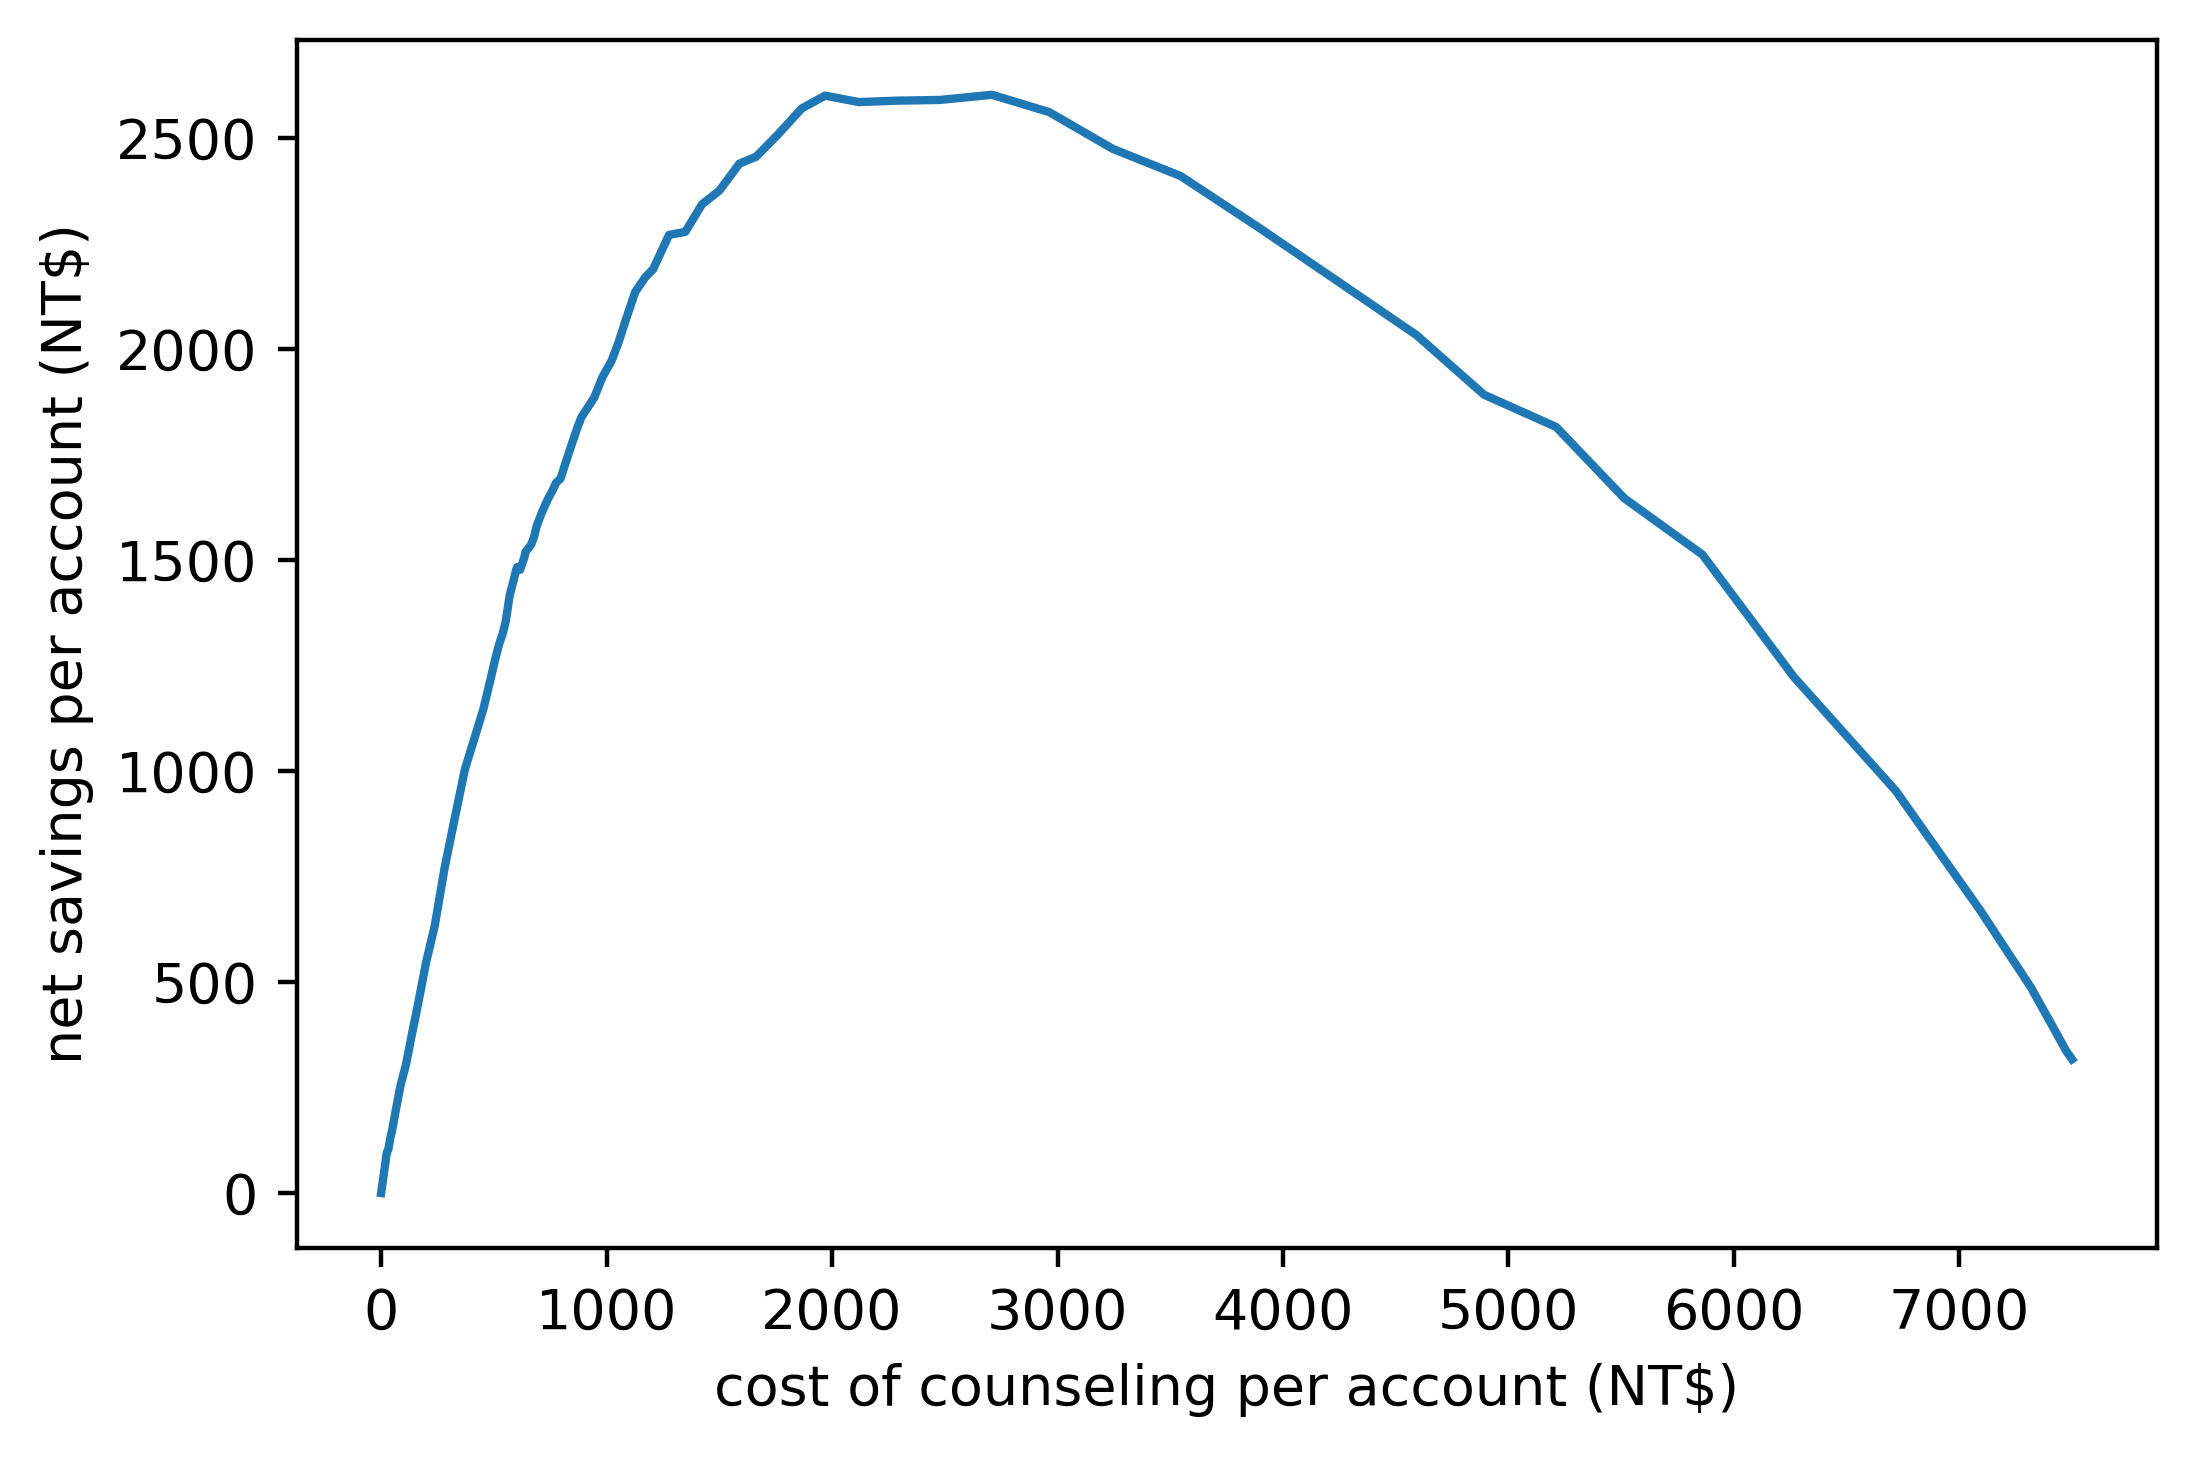

In [211]:
plt.plot((cost_of_all_counselings)/len(y_test_all),(net_savings/len(y_test_all)))
plt.xlabel('cost of counseling per account (NT$)')
plt.ylabel('net savings per account (NT$)')

<b>Next, plot the fraction of accounts predicted as positive (this is called the "flag rate") at each threshold.</b>

Text(0, 0.5, 'flag rate')

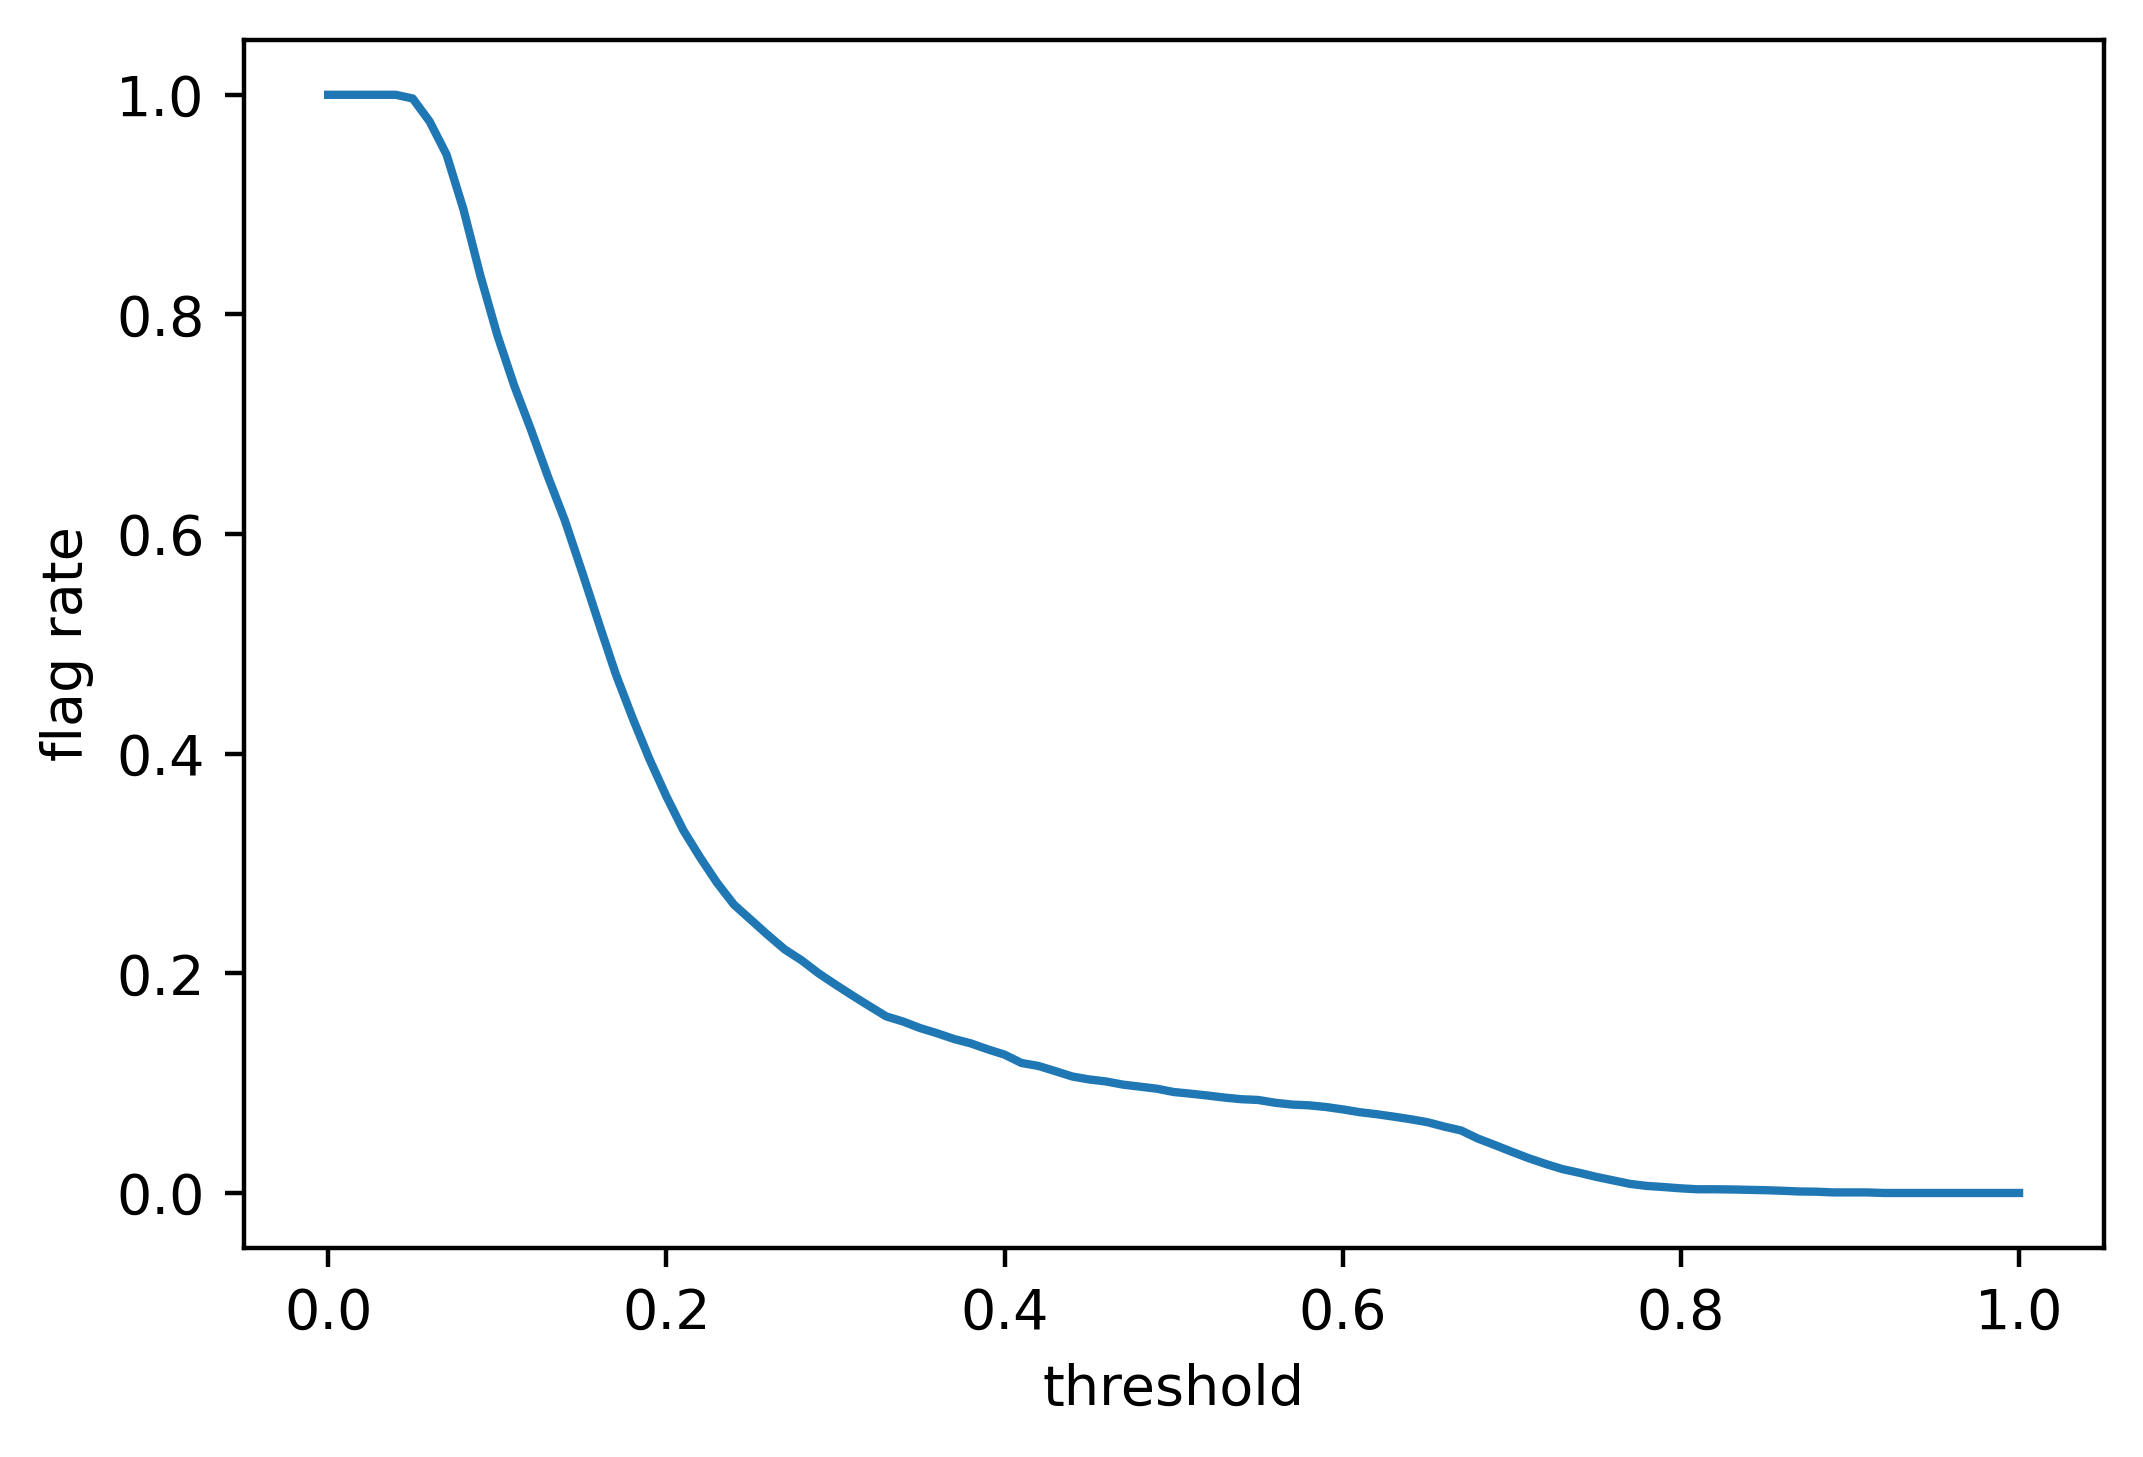

In [212]:
plt.plot(thresholds,n_pos_pred/len(y_test_all))
plt.xlabel('threshold')
plt.ylabel('flag rate')

<b>Next, plot a precision-recall curve for the testing data. </b>

C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Precision')

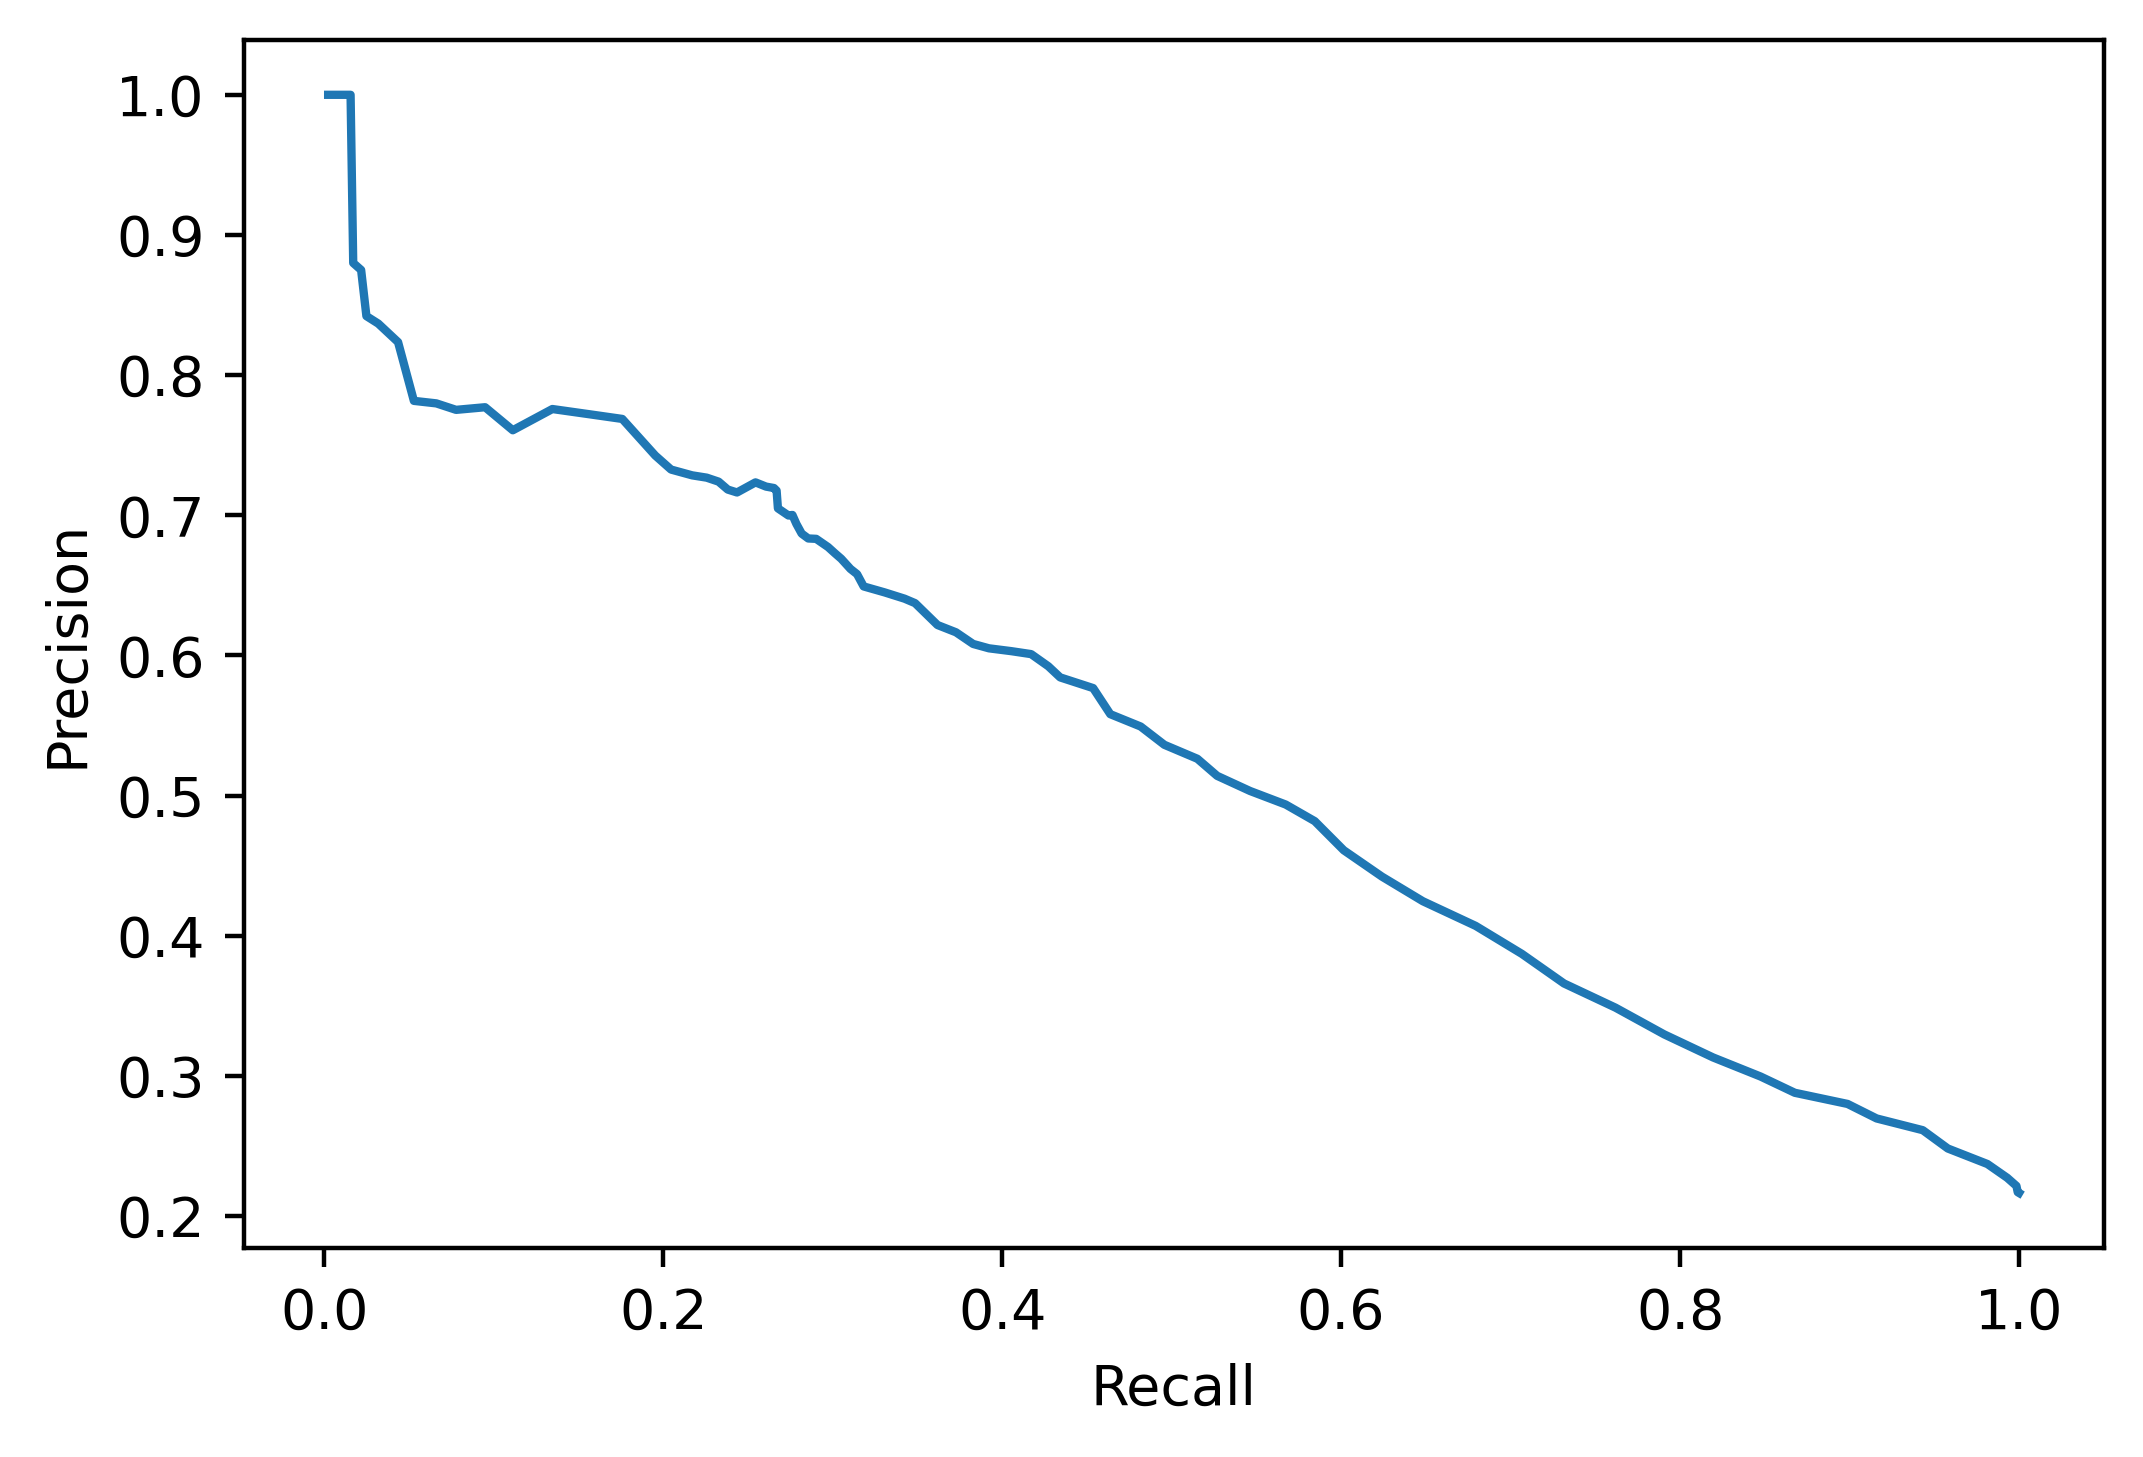

In [215]:
plt.plot(n_true_pos/sum(y_test_all), np.divide(n_true_pos, n_pos_pred))
plt.xlabel('Recall')
plt.ylabel('Precision')

<b>Finally, plot precision and recall separately on the y-axis against threshold on the x-axis.</b>

C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


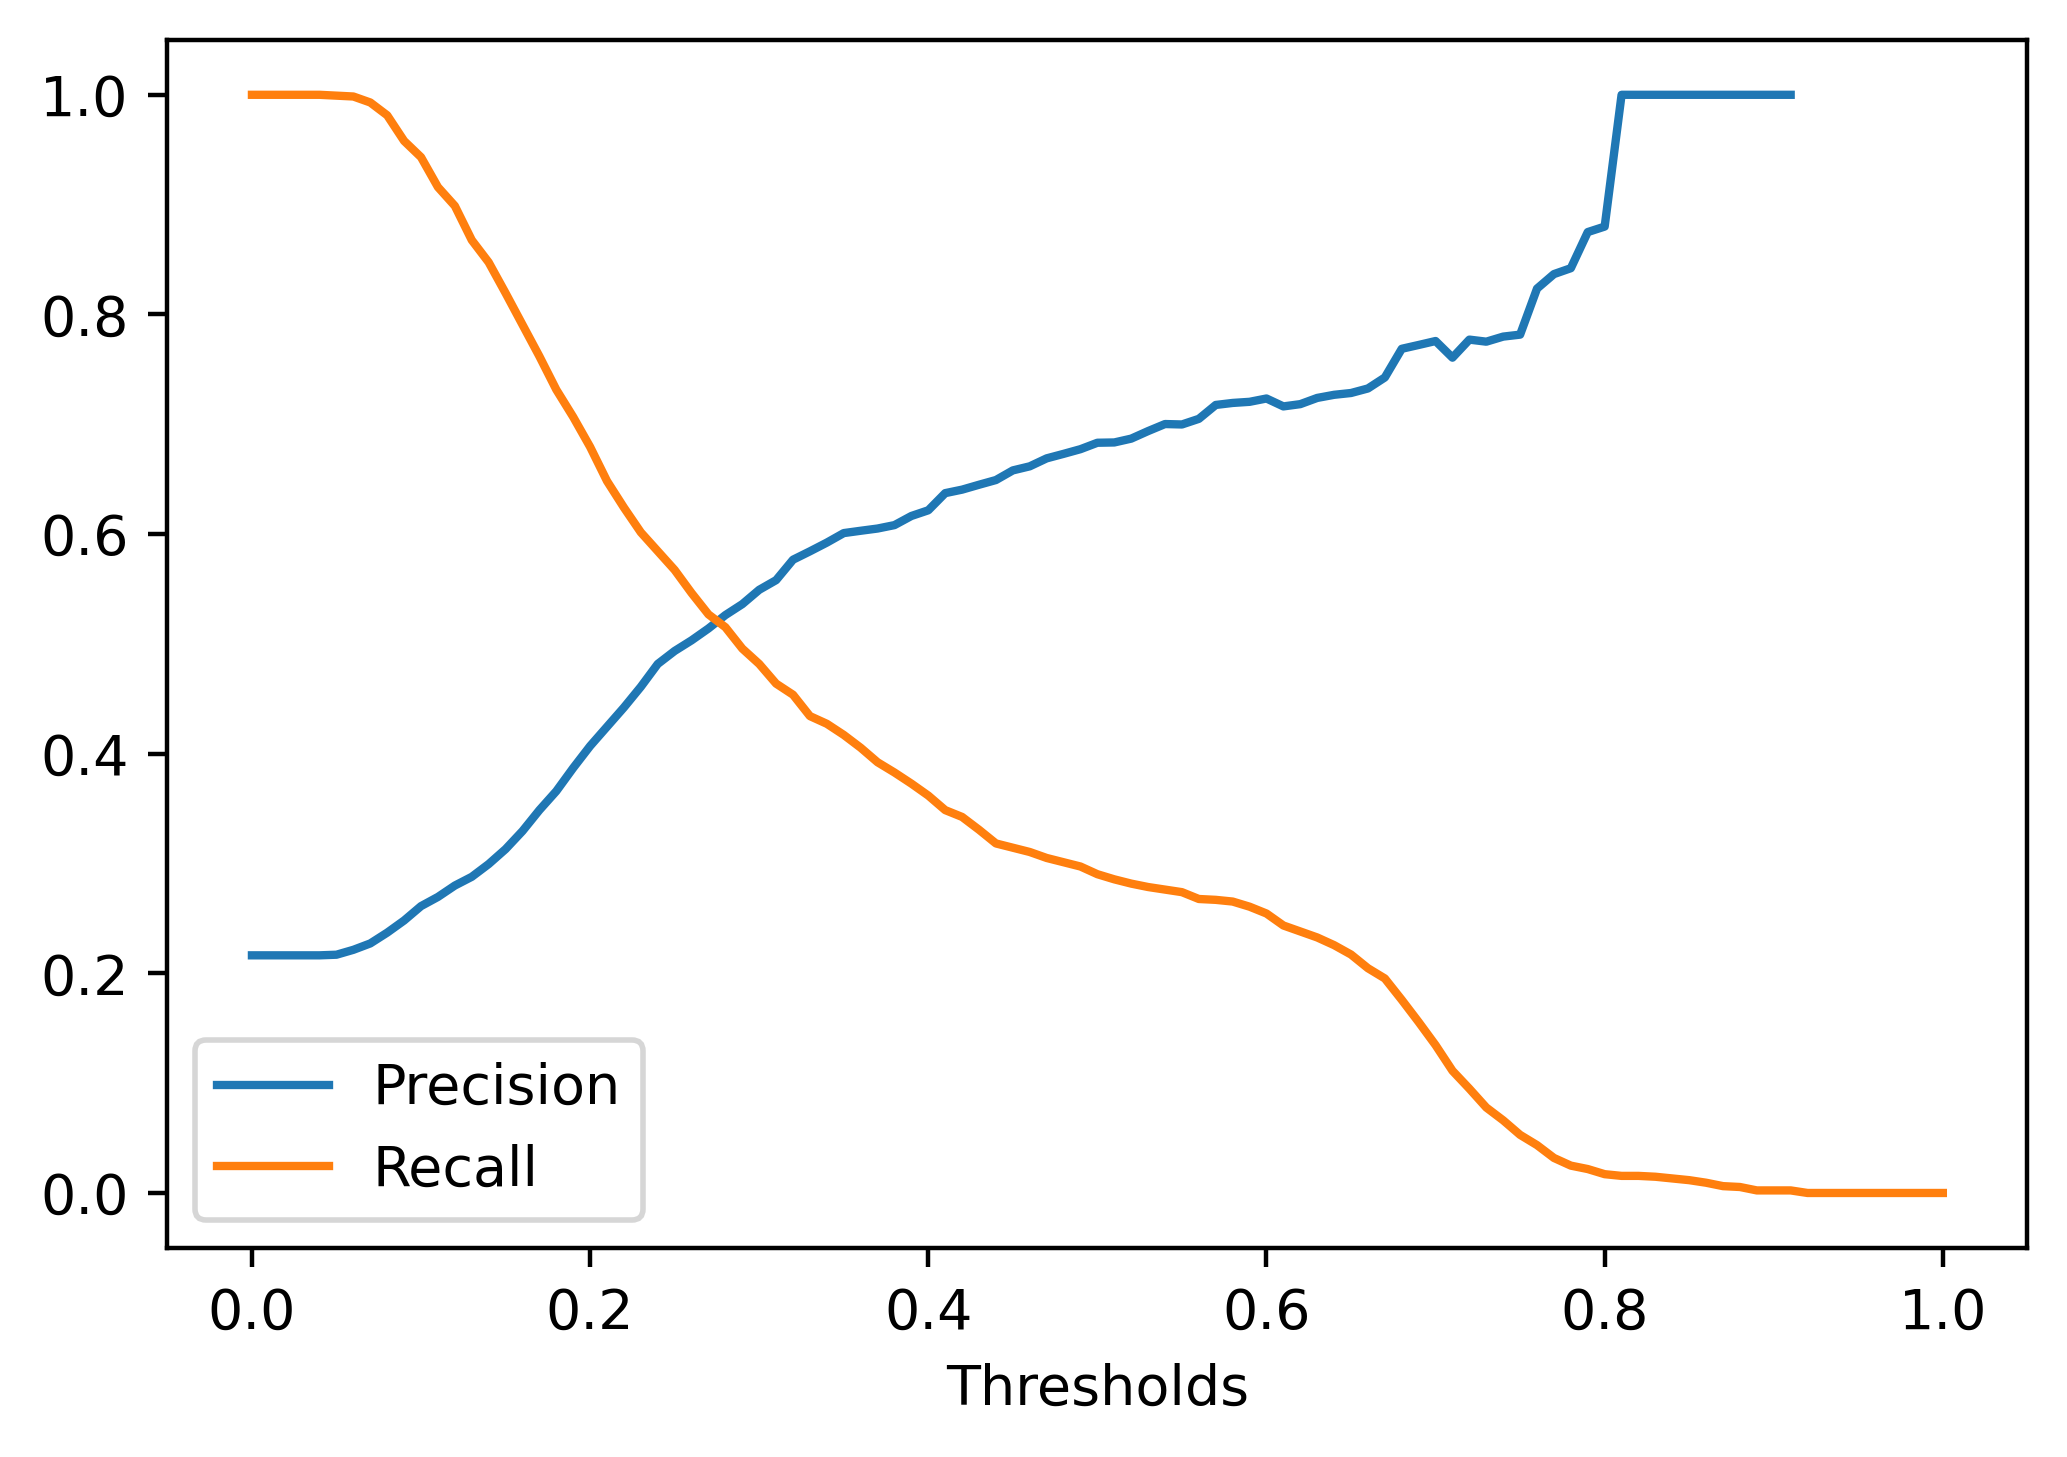

In [216]:
plt.plot(thresholds, np.divide(n_true_pos, n_pos_pred), label='Precision')
plt.plot(thresholds, n_true_pos/sum(y_test_all), label='Recall')
plt.xlabel('Thresholds')
plt.legend()